In [1]:
import os
import glob
import random
import time
from utils import mfccs_and_spec
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from random import shuffle
from hparam import hparam as hp
from torch.functional import F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable, Function
import torch.optim as optim
from data_load import TripletSpeakerDataset
from speech_embedder_net import SpeechEmbedder, GE2ELoss, get_centroids, get_cossim

/home/dexter/Desktop/Projects/Mini Project/FINAL_WORKING_Voice-Cloning/hparam.py:11: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


In [2]:
import librosa 
import librosa.display
import IPython
import pickle 
import numpy as np
import scipy 
import tensorflow as tf 
from sklearn.externals import joblib
from tensorflow.python.client import device_lib
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import Adam

/home/dexter/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [3]:
from utils import mfcc_for_accent
from data_preprocess import get_spectrogram_tisv

In [4]:
config = tf.compat.v1.ConfigProto(allow_soft_placement = True,
                        device_count = {'CPU' : 6,
                                       'GPU' : 0})

In [5]:
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [6]:
def make_accent_model():
    model = Sequential()

    model.add(Dense(50, input_shape = (14976,), activation = 'relu',name='input'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(75, activation = 'tanh', name='h1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh',name = 'h2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h3'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h4'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name = 'h5'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(100,  activation = 'tanh', name ='h6'))
    model.add(BatchNormalization())

    model.add(Dense(3,  activation = 'softmax', name = 'output'))
    return model

In [7]:
## Mel spectrograms and MFCCs for Indians 
def get_accent_mfccs(path):
    x, _ = librosa.load(path)
    x, mf = mfcc_for_accent(x)
    mf = mf.flatten()
    #print(type(x))
    # l.append(librosa.feature.mfcc(x, sr=f))
    
    dat = np.reshape(mf, (1,mf.shape[0]))
    return x, dat

In [8]:

embedder_net = SpeechEmbedder().to('cuda')
embedder_net.load_state_dict(torch.load(hp.model.model_path))
accent_net = make_accent_model()
accent_net.load_weights('accent_block_with_scottish.h5')
accent_net.pop()


#wav, sr = librosa.load(file_name)

def run_speaker_encoder(mfccs, embedder_net):
    mel_db = torch.transpose(mfccs, 1,2)
    #mel_db = torch.from_numpy(mel_db)
    #print(mel_db.shape)
    out = embedder_net(mel_db.to('cuda'))
    return out

In [9]:
from keras.utils import plot_model

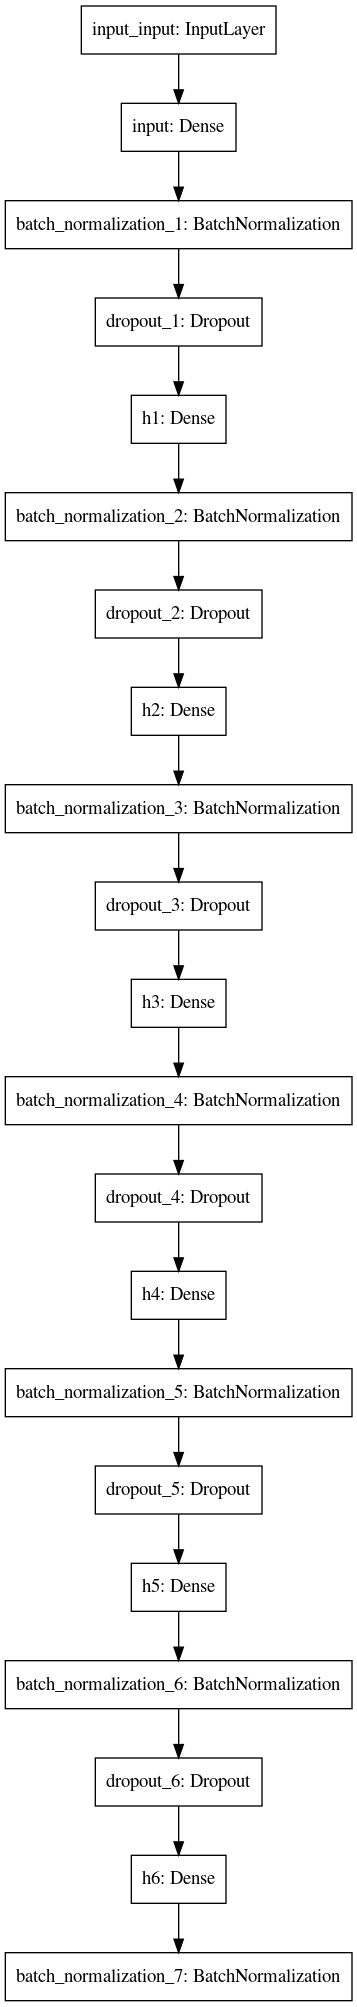

In [10]:
plot_model(accent_net, to_file='accent.png')

In [11]:
def get_both_embs(path):
    #for path in enumerate(train_dataset):
    _, accent_mfccs = get_accent_mfccs(path)
    speaker_mfccs = get_spectrogram_tisv(path)
    #print(accent_mfccs.shape)
    #print(speaker_mfccs.shape)
    speaker_mfccs = Variable(torch.from_numpy(speaker_mfccs)).to('cuda')
    speaker_emb = run_speaker_encoder(speaker_mfccs, embedder_net)
    #print(speaker_emb.shape)
    accent_emb = accent_net.predict(accent_mfccs)
    #print(accent_emb.shape)
    return speaker_emb.cpu().detach().numpy(), accent_emb

In [12]:
accent_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 50)                748850    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
h1 (Dense)                   (None, 75)                3825      
_________________________________________________________________
batch_normalization_2 (Batch (None, 75)                300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
h2 (Dense)                   (None, 100)              

In [13]:
dataset = TripletSpeakerDataset()
data_loader = torch.utils.data.DataLoader(dataset, drop_last=True)

In [13]:
for batch_idx, (anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path, speaker_positive_id, speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent) in enumerate(data_loader):
    print(anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path, speaker_positive_id, speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent)

('data/Scottish/p249/p249_263_mic2.flac',) ('data/Scottish/p249/p249_186_mic2.flac',) ('data/Scottish/p237/p237_101_mic2.flac',) ('data/American/p300/p300_129_mic1.flac',) ('p249',) ('p237',) ('p249',) ('Scottish',) ('American',)
('data/Scottish/p234/p234_171_mic1.flac',) ('data/Scottish/p234/p234_254_mic2.flac',) ('data/Scottish/p237/p237_259_mic2.flac',) ('data/Indian/p376/p376_041_mic2.flac',) ('p234',) ('p237',) ('p234',) ('Scottish',) ('Indian',)
('data/Scottish/p284/p284_377_mic2.flac',) ('data/Scottish/p284/p284_350_mic1.flac',) ('data/Scottish/p234/p234_018_mic2.flac',) ('data/Indian/p376/p376_320_mic1.flac',) ('p284',) ('p234',) ('p284',) ('Scottish',) ('Indian',)
('data/Irish/p295/p295_331_mic1.flac',) ('data/Irish/p295/p295_059_mic2.flac',) ('data/Irish/p298/p298_174_mic2.flac',) ('data/Scottish/p284/p284_101_mic2.flac',) ('p295',) ('p298',) ('p295',) ('Irish',) ('Scottish',)
('data/American/p299/p299_247_mic2.flac',) ('data/American/p299/p299_116_mic2.flac',) ('data/America

('data/American/p301/p301_314_mic1.flac',) ('data/American/p301/p301_164_mic2.flac',) ('data/American/p299/p299_116_mic1.flac',) ('data/Indian/p251/p251_165_mic2.flac',) ('p301',) ('p299',) ('p301',) ('American',) ('Indian',)
('data/Scottish/p284/p284_253_mic1.flac',) ('data/Scottish/p284/p284_198_mic1.flac',) ('data/Scottish/p249/p249_188_mic2.flac',) ('data/American/p300/p300_371_mic2.flac',) ('p284',) ('p249',) ('p284',) ('Scottish',) ('American',)
('data/Scottish/p249/p249_192_mic1.flac',) ('data/Scottish/p249/p249_058_mic2.flac',) ('data/Scottish/p284/p284_233_mic1.flac',) ('data/American/p299/p299_250_mic2.flac',) ('p249',) ('p284',) ('p249',) ('Scottish',) ('American',)
('data/Indian/p376/p376_364_mic1.flac',) ('data/Indian/p376/p376_092_mic2.flac',) ('data/Indian/p248/p248_232_mic1.flac',) ('data/Irish/p283/p283_035_mic1.flac',) ('p376',) ('p248',) ('p376',) ('Indian',) ('Irish',)
('data/American/p299/p299_201_mic2.flac',) ('data/American/p299/p299_302_mic1.flac',) ('data/Ameri

('data/Scottish/p234/p234_277_mic2.flac',) ('data/Scottish/p234/p234_348_mic2.flac',) ('data/Scottish/p249/p249_144_mic2.flac',) ('data/Indian/p251/p251_215_mic1.flac',) ('p234',) ('p249',) ('p234',) ('Scottish',) ('Indian',)
('data/Indian/p376/p376_309_mic1.flac',) ('data/Indian/p376/p376_266_mic1.flac',) ('data/Indian/p248/p248_061_mic2.flac',) ('data/Irish/p298/p298_114_mic2.flac',) ('p376',) ('p248',) ('p376',) ('Indian',) ('Irish',)
('data/Scottish/p234/p234_032_mic1.flac',) ('data/Scottish/p234/p234_034_mic1.flac',) ('data/Scottish/p237/p237_278_mic1.flac',) ('data/Irish/p298/p298_005_mic1.flac',) ('p234',) ('p237',) ('p234',) ('Scottish',) ('Irish',)
('data/Indian/p376/p376_393_mic1.flac',) ('data/Indian/p376/p376_294_mic2.flac',) ('data/Indian/p248/p248_346_mic2.flac',) ('data/Irish/p298/p298_085_mic1.flac',) ('p376',) ('p248',) ('p376',) ('Indian',) ('Irish',)
('data/Indian/p248/p248_143_mic2.flac',) ('data/Indian/p248/p248_159_mic1.flac',) ('data/Indian/p376/p376_162_mic2.fla

('data/Scottish/p249/p249_159_mic1.flac',) ('data/Scottish/p249/p249_130_mic1.flac',) ('data/Scottish/p234/p234_315_mic1.flac',) ('data/Indian/p251/p251_204_mic2.flac',) ('p249',) ('p234',) ('p249',) ('Scottish',) ('Indian',)
('data/Indian/p251/p251_230_mic2.flac',) ('data/Indian/p251/p251_087_mic2.flac',) ('data/Indian/p248/p248_107_mic1.flac',) ('data/Scottish/p249/p249_031_mic1.flac',) ('p251',) ('p248',) ('p251',) ('Indian',) ('Scottish',)
('data/Scottish/p234/p234_240_mic1.flac',) ('data/Scottish/p234/p234_245_mic1.flac',) ('data/Scottish/p284/p284_331_mic2.flac',) ('data/Indian/p251/p251_301_mic2.flac',) ('p234',) ('p284',) ('p234',) ('Scottish',) ('Indian',)
('data/Scottish/p234/p234_223_mic1.flac',) ('data/Scottish/p234/p234_236_mic1.flac',) ('data/Scottish/p249/p249_353_mic1.flac',) ('data/Indian/p248/p248_028_mic2.flac',) ('p234',) ('p249',) ('p234',) ('Scottish',) ('Indian',)
('data/Indian/p376/p376_265_mic1.flac',) ('data/Indian/p376/p376_195_mic2.flac',) ('data/Indian/p251

('data/Scottish/p284/p284_076_mic2.flac',) ('data/Scottish/p284/p284_421_mic1.flac',) ('data/Scottish/p249/p249_019_mic2.flac',) ('data/Irish/p298/p298_217_mic2.flac',) ('p284',) ('p249',) ('p284',) ('Scottish',) ('Irish',)
('data/American/p300/p300_229_mic1.flac',) ('data/American/p300/p300_240_mic2.flac',) ('data/American/p301/p301_119_mic2.flac',) ('data/Indian/p376/p376_322_mic2.flac',) ('p300',) ('p301',) ('p300',) ('American',) ('Indian',)
('data/Indian/p248/p248_277_mic2.flac',) ('data/Indian/p248/p248_231_mic1.flac',) ('data/Indian/p251/p251_368_mic1.flac',) ('data/Scottish/p234/p234_120_mic1.flac',) ('p248',) ('p251',) ('p248',) ('Indian',) ('Scottish',)
('data/American/p300/p300_275_mic1.flac',) ('data/American/p300/p300_089_mic1.flac',) ('data/American/p301/p301_244_mic1.flac',) ('data/Indian/p251/p251_319_mic1.flac',) ('p300',) ('p301',) ('p300',) ('American',) ('Indian',)
('data/Irish/p245/p245_225_mic1.flac',) ('data/Irish/p245/p245_175_mic2.flac',) ('data/Irish/p283/p283

('data/Scottish/p234/p234_279_mic1.flac',) ('data/Scottish/p234/p234_025_mic1.flac',) ('data/Scottish/p237/p237_059_mic2.flac',) ('data/Irish/p245/p245_309_mic2.flac',) ('p234',) ('p237',) ('p234',) ('Scottish',) ('Irish',)
('data/American/p300/p300_228_mic2.flac',) ('data/American/p300/p300_291_mic2.flac',) ('data/American/p299/p299_095_mic1.flac',) ('data/Indian/p251/p251_126_mic1.flac',) ('p300',) ('p299',) ('p300',) ('American',) ('Indian',)
('data/Indian/p251/p251_051_mic1.flac',) ('data/Indian/p251/p251_150_mic2.flac',) ('data/Indian/p376/p376_424_mic2.flac',) ('data/Scottish/p237/p237_217_mic1.flac',) ('p251',) ('p376',) ('p251',) ('Indian',) ('Scottish',)
('data/Indian/p248/p248_186_mic2.flac',) ('data/Indian/p248/p248_050_mic1.flac',) ('data/Indian/p251/p251_004_mic2.flac',) ('data/Scottish/p237/p237_061_mic1.flac',) ('p248',) ('p251',) ('p248',) ('Indian',) ('Scottish',)
('data/Indian/p248/p248_128_mic1.flac',) ('data/Indian/p248/p248_165_mic1.flac',) ('data/Indian/p251/p251_

('data/Irish/p295/p295_203_mic2.flac',) ('data/Irish/p295/p295_239_mic2.flac',) ('data/Irish/p283/p283_190_mic2.flac',) ('data/Indian/p376/p376_108_mic1.flac',) ('p295',) ('p283',) ('p295',) ('Irish',) ('Indian',)
('data/American/p299/p299_284_mic2.flac',) ('data/American/p299/p299_293_mic1.flac',) ('data/American/p301/p301_217_mic2.flac',) ('data/Scottish/p234/p234_009_mic1.flac',) ('p299',) ('p301',) ('p299',) ('American',) ('Scottish',)
('data/American/p299/p299_279_mic1.flac',) ('data/American/p299/p299_105_mic2.flac',) ('data/American/p300/p300_123_mic2.flac',) ('data/Irish/p295/p295_327_mic2.flac',) ('p299',) ('p300',) ('p299',) ('American',) ('Irish',)
('data/American/p300/p300_331_mic2.flac',) ('data/American/p300/p300_213_mic1.flac',) ('data/American/p299/p299_239_mic2.flac',) ('data/Indian/p248/p248_092_mic1.flac',) ('p300',) ('p299',) ('p300',) ('American',) ('Indian',)
('data/Indian/p248/p248_029_mic2.flac',) ('data/Indian/p248/p248_147_mic2.flac',) ('data/Indian/p376/p376_

('data/Scottish/p237/p237_267_mic2.flac',) ('data/Scottish/p237/p237_276_mic2.flac',) ('data/Scottish/p249/p249_180_mic1.flac',) ('data/Indian/p376/p376_160_mic2.flac',) ('p237',) ('p249',) ('p237',) ('Scottish',) ('Indian',)
('data/Irish/p298/p298_290_mic2.flac',) ('data/Irish/p298/p298_198_mic1.flac',) ('data/Irish/p295/p295_125_mic2.flac',) ('data/American/p300/p300_033_mic2.flac',) ('p298',) ('p295',) ('p298',) ('Irish',) ('American',)
('data/American/p300/p300_089_mic2.flac',) ('data/American/p300/p300_354_mic1.flac',) ('data/American/p301/p301_158_mic1.flac',) ('data/Scottish/p284/p284_021_mic2.flac',) ('p300',) ('p301',) ('p300',) ('American',) ('Scottish',)
('data/Indian/p376/p376_228_mic2.flac',) ('data/Indian/p376/p376_200_mic1.flac',) ('data/Indian/p251/p251_126_mic2.flac',) ('data/Irish/p298/p298_189_mic2.flac',) ('p376',) ('p251',) ('p376',) ('Indian',) ('Irish',)
('data/Irish/p295/p295_289_mic2.flac',) ('data/Irish/p295/p295_347_mic2.flac',) ('data/Irish/p283/p283_418_mic

('data/Indian/p251/p251_306_mic2.flac',) ('data/Indian/p251/p251_300_mic2.flac',) ('data/Indian/p376/p376_024_mic1.flac',) ('data/Irish/p298/p298_217_mic1.flac',) ('p251',) ('p376',) ('p251',) ('Indian',) ('Irish',)
('data/Irish/p245/p245_102_mic1.flac',) ('data/Irish/p245/p245_040_mic2.flac',) ('data/Irish/p283/p283_335_mic1.flac',) ('data/American/p299/p299_382_mic2.flac',) ('p245',) ('p283',) ('p245',) ('Irish',) ('American',)
('data/Indian/p376/p376_309_mic1.flac',) ('data/Indian/p376/p376_319_mic2.flac',) ('data/Indian/p251/p251_239_mic2.flac',) ('data/American/p301/p301_258_mic1.flac',) ('p376',) ('p251',) ('p376',) ('Indian',) ('American',)
('data/Scottish/p249/p249_223_mic2.flac',) ('data/Scottish/p249/p249_067_mic2.flac',) ('data/Scottish/p234/p234_327_mic1.flac',) ('data/American/p300/p300_334_mic1.flac',) ('p249',) ('p234',) ('p249',) ('Scottish',) ('American',)
('data/Irish/p298/p298_302_mic2.flac',) ('data/Irish/p298/p298_074_mic2.flac',) ('data/Irish/p245/p245_245_mic1.fl

('data/Indian/p376/p376_179_mic2.flac',) ('data/Indian/p376/p376_081_mic1.flac',) ('data/Indian/p251/p251_207_mic1.flac',) ('data/American/p301/p301_291_mic1.flac',) ('p376',) ('p251',) ('p376',) ('Indian',) ('American',)
('data/Irish/p283/p283_134_mic2.flac',) ('data/Irish/p283/p283_328_mic2.flac',) ('data/Irish/p295/p295_077_mic1.flac',) ('data/Indian/p376/p376_119_mic1.flac',) ('p283',) ('p295',) ('p283',) ('Irish',) ('Indian',)
('data/Irish/p283/p283_141_mic2.flac',) ('data/Irish/p283/p283_033_mic2.flac',) ('data/Irish/p298/p298_224_mic2.flac',) ('data/Scottish/p237/p237_248_mic1.flac',) ('p283',) ('p298',) ('p283',) ('Irish',) ('Scottish',)
('data/Scottish/p284/p284_424_mic2.flac',) ('data/Scottish/p284/p284_197_mic1.flac',) ('data/Scottish/p237/p237_008_mic1.flac',) ('data/American/p300/p300_212_mic1.flac',) ('p284',) ('p237',) ('p284',) ('Scottish',) ('American',)
('data/Irish/p245/p245_186_mic1.flac',) ('data/Irish/p245/p245_091_mic1.flac',) ('data/Irish/p295/p295_089_mic2.flac

('data/American/p299/p299_083_mic2.flac',) ('data/American/p299/p299_185_mic1.flac',) ('data/American/p301/p301_283_mic2.flac',) ('data/Irish/p298/p298_277_mic1.flac',) ('p299',) ('p301',) ('p299',) ('American',) ('Irish',)
('data/Scottish/p249/p249_350_mic1.flac',) ('data/Scottish/p249/p249_310_mic1.flac',) ('data/Scottish/p234/p234_360_mic2.flac',) ('data/Irish/p283/p283_340_mic2.flac',) ('p249',) ('p234',) ('p249',) ('Scottish',) ('Irish',)
('data/Irish/p295/p295_006_mic1.flac',) ('data/Irish/p295/p295_386_mic1.flac',) ('data/Irish/p283/p283_424_mic2.flac',) ('data/Indian/p251/p251_025_mic2.flac',) ('p295',) ('p283',) ('p295',) ('Irish',) ('Indian',)
('data/Scottish/p234/p234_084_mic2.flac',) ('data/Scottish/p234/p234_284_mic1.flac',) ('data/Scottish/p237/p237_214_mic2.flac',) ('data/Indian/p248/p248_223_mic1.flac',) ('p234',) ('p237',) ('p234',) ('Scottish',) ('Indian',)
('data/American/p299/p299_225_mic1.flac',) ('data/American/p299/p299_375_mic2.flac',) ('data/American/p301/p301_

('data/Irish/p245/p245_316_mic2.flac',) ('data/Irish/p245/p245_258_mic2.flac',) ('data/Irish/p283/p283_356_mic1.flac',) ('data/Indian/p376/p376_066_mic2.flac',) ('p245',) ('p283',) ('p245',) ('Irish',) ('Indian',)
('data/American/p299/p299_135_mic2.flac',) ('data/American/p299/p299_013_mic2.flac',) ('data/American/p301/p301_096_mic1.flac',) ('data/Irish/p295/p295_215_mic2.flac',) ('p299',) ('p301',) ('p299',) ('American',) ('Irish',)
('data/Scottish/p284/p284_365_mic2.flac',) ('data/Scottish/p284/p284_068_mic2.flac',) ('data/Scottish/p249/p249_197_mic1.flac',) ('data/American/p299/p299_215_mic1.flac',) ('p284',) ('p249',) ('p284',) ('Scottish',) ('American',)
('data/Indian/p376/p376_034_mic2.flac',) ('data/Indian/p376/p376_061_mic2.flac',) ('data/Indian/p251/p251_313_mic2.flac',) ('data/Irish/p245/p245_035_mic1.flac',) ('p376',) ('p251',) ('p376',) ('Indian',) ('Irish',)
('data/Indian/p248/p248_217_mic1.flac',) ('data/Indian/p248/p248_065_mic2.flac',) ('data/Indian/p376/p376_268_mic1.f

('data/Irish/p295/p295_080_mic2.flac',) ('data/Irish/p295/p295_405_mic1.flac',) ('data/Irish/p245/p245_320_mic2.flac',) ('data/Scottish/p249/p249_095_mic1.flac',) ('p295',) ('p245',) ('p295',) ('Irish',) ('Scottish',)
('data/Irish/p295/p295_398_mic1.flac',) ('data/Irish/p295/p295_324_mic1.flac',) ('data/Irish/p283/p283_459_mic1.flac',) ('data/American/p301/p301_407_mic2.flac',) ('p295',) ('p283',) ('p295',) ('Irish',) ('American',)
('data/American/p301/p301_166_mic1.flac',) ('data/American/p301/p301_248_mic1.flac',) ('data/American/p300/p300_071_mic2.flac',) ('data/Irish/p298/p298_177_mic2.flac',) ('p301',) ('p300',) ('p301',) ('American',) ('Irish',)
('data/Scottish/p284/p284_394_mic1.flac',) ('data/Scottish/p284/p284_132_mic1.flac',) ('data/Scottish/p249/p249_117_mic2.flac',) ('data/Irish/p245/p245_020_mic1.flac',) ('p284',) ('p249',) ('p284',) ('Scottish',) ('Irish',)
('data/Scottish/p284/p284_314_mic2.flac',) ('data/Scottish/p284/p284_126_mic1.flac',) ('data/Scottish/p249/p249_080_

KeyboardInterrupt: 

In [ ]:
speaker_positive_id[0], speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent

In [ ]:
anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path

In [14]:
class PairwiseDistance(Function):
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        #print("above assert: ",x1, x2)
        assert x1.size() == x2.size()
        eps = 1e-4 / x1.size(1)
        diff = torch.abs(x1 - x2)
        out = torch.pow(diff, self.norm).sum(dim=1)
        return torch.pow(out + eps, 1. / self.norm)

class TripletLoss(Function):
    """
    Triplet loss function.
    """
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)  # norm 2

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(torch.from_numpy(anchor), positive)
        d_n = self.pdist.forward(torch.from_numpy(anchor), torch.from_numpy(negative))

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0)
        loss = torch.mean(dist_hinge)
        return loss

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.inp1 = nn.Linear(in_features=256, out_features=100)
        self.inp2 = nn.Linear(in_features=100, out_features=100)
        self.b_n = nn.BatchNorm1d(128)
        
        self.drop_out = nn.Dropout(0.25)
        self.l1 = nn.Linear(200, 128)
        self.l2 = nn.Linear(128,128)
        self.out_acc = nn.Linear(128, 100)
        self.out_speak = nn.Linear(128,256)
        
    def forward(self, *args):
        speaker_emb, acc_emb = args[0], args[1]
        x1 = F.relu(self.inp1(speaker_emb))
        
        x2 = F.relu(self.inp2(x1))
        #print(x1.shape, x2.shape, speaker_emb.shape, acc_emb.shape)
        out = torch.cat((x1, x2), axis=1)
        out = self.l1(out)
        out = F.relu(out)
        out = F.relu(self.l2(out))
        
        mf_acc = self.out_acc(out)
        mf_sp = self.out_speak(out)
        return F.relu(mf_sp), F.relu(mf_acc)

In [16]:
def train():
    device = hp.device
    dataset = TripletSpeakerDataset()
    data_loader = torch.utils.data.DataLoader(dataset, drop_last=True)
    ae = AutoEncoder().to('cuda')
    writer = SummaryWriter('triplet_loss_logs')
    optimizer = optim.Adam(ae.parameters())
    optimizer.zero_grad()
    #ae.load_state_dict(torch.load(''))
    trip_loss = TripletLoss()
    total_loss = 0
    for epoch in range(20):
        for batch_id, (anchor_utter_path, positive_utter_path, negative_utter_path, accent_negative_path, speaker_positive_id, speaker_negative_id, speaker_anchor_id, positive_accent, negative_accent) in tqdm(enumerate(data_loader), total = len(data_loader)):
            anchor_utter_path, positive_utter_path, negative_utter_path = anchor_utter_path[0], positive_utter_path[0], negative_utter_path[0]
            accent_negative_path, speaker_positive_id, speaker_negative_id = accent_negative_path[0], speaker_positive_id[0], speaker_negative_id[0]
            speaker_anchor_id, positive_accent, negative_accent = speaker_anchor_id[0], positive_accent[0], negative_accent[0]
            
            try:
                pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(positive_utter_path)
                pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cuda'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cuda')
                anchor_utter_path
                anchor_speaker_embs, anchor_accent_embs = get_both_embs(anchor_utter_path)
                negative_speaker_embs, _ = get_both_embs(negative_utter_path)
                _, negative_accent_embs = get_both_embs(accent_negative_path)
            except ValueError:
                print("ValueError")
                continue
            except:
                continue
            positive_speaker_embs, positive_accent_embs = ae.forward(pre_positive_speaker_embs, pre_positive_accent_embs)
            positive_speaker_embs, positive_accent_embs = positive_speaker_embs.to('cpu'), positive_accent_embs.to('cpu')
            optimizer.zero_grad()
            #print(anchor_accent_embs.shape)
            accent_trip_loss = trip_loss.forward(anchor_accent_embs, positive_accent_embs, negative_accent_embs)
            speaker_trip_loss = trip_loss.forward(anchor_speaker_embs, positive_speaker_embs, negative_speaker_embs)
            criterion = accent_trip_loss + speaker_trip_loss
            total_loss += criterion
            
            
            
            criterion.backward()
            optimizer.step()
            writer.add_scalar('Loss', criterion, epoch*len(data_loader)+1)
            
            if (batch_id + 1) % 5 == 0:
                mesg = "{}\tEpoch:{},Iteration:{}\tLoss:{}\t\n".format(time.ctime(), epoch+1,
                        batch_id+1, criterion)
                print(mesg)
                if hp.train.log_file is not None:
                    with open(hp.train.log_file,'a') as f:
                        f.write(mesg)
            if hp.train.checkpoint_dir is not None and (batch_id + 1) % 100 == 0:
                ae.eval()
                ckpt_model_filename = "ckpt_epoch_" + str(batch_id+1) + "_batch_id_" + str(batch_id+1) + ".pth"
                ckpt_model_path = os.path.join("new_checkpoints/", ckpt_model_filename)
                torch.save(ae.state_dict(), ckpt_model_path)
                ae.to(device).train()
        ae.eval()
        save_model_filename = "final_epoch_" + str(epoch + 1) + "_batch_id_" + str(batch_id + 1) + ".model"
        save_model_path = os.path.join(hp.train.checkpoint_dir, save_model_filename)
        torch.save(ae.state_dict(), save_model_path)

        print("\nDone, trained model saved at", save_model_path)

In [14]:
train()

NameError: name 'train' is not defined

In [16]:
len(data_loader)

10956

In [17]:
ae = AutoEncoder().to('cuda')

In [18]:
pytorch_total_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)

In [19]:
pytorch_total_params

124220

In [20]:
pytorch_total_params = sum(p.numel() for p in embedder_net.parameters() if p.requires_grad)

In [21]:
dataset = TripletSpeakerDataset()
data_loader = torch.utils.data.DataLoader(dataset, drop_last=True)

In [22]:
from __future__ import print_function
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.manifold import TSNE
import time
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def preprocess_tsne(model, path):
    tsne = TSNE(verbose=1)
    utters = []
    files = glob.glob(path)
    speakers = []
    accents = []
    X1=[]
    for i,file in enumerate(files):
        if i%50!=0:
            continue
        try:
            pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(file)
        except:
            print('continuing')
            continue
        speaker = file.split('/')[-2]
        accent = file.split('/')[-3]
        pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cpu'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cpu')
        utt, _ = ae.forward(pre_positive_speaker_embs, pre_positive_accent_embs)
        print(i)
        utters.append(utt)
        speakers.append(speaker)
        accents.append(accent)
        X1.append(get_spectrogram_tisv(file))
    arr = [t.detach().numpy() for t in utters]
    y = np.asarray(speakers)
    print(speakers)
    print(np.asarray(arr).shape)
    X = np.squeeze(np.asarray(arr), 1)
    return X, y, X1


def tsne_visualize(X, y):
    feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
    df = pd.DataFrame(X,columns=feat_cols)
    df['y'] = y
    df['label'] = df['y'].apply(lambda i: str(i))
    print('Size of the dataframe: {}'.format(df.shape))
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    
    
    N = 10000
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[feat_cols].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.figure(figsize=(16,10))
    
    df2 = df.groupby(y).mean().reset_index()
    rndperm2 = np.random.permutation(df2.shape[0])
    """
    sns_plot = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
        palette=sns.color_palette("hls", 14),
        data=df.loc[rndperm,:],
        legend="full",
        alpha=1.0
    )
    sns_plot.figure.savefig('fig.png')
    """
    
    sns_plot2 = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="index",
        palette=sns.color_palette("hls", 14),
        data=df2.loc[rndperm2,:],
        legend="full",
        alpha=1.0
    )
    sns_plot2.figure.savefig('fig2.png')
    #plt.savefig("out.png")
    
    
    
    df_subset = df.loc[rndperm[:N],:].copy()
    data_subset = df_subset[feat_cols].values
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=10000)
    print(X.shape)
    tsne_results = tsne.fit_transform(pd.DataFrame(np.asarray(X)))
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    """
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 14),
        data=df_subset,
        legend="brief"
    )
    """
    return df

In [47]:
def preprocess_tsne(model, path):
    tsne = TSNE(verbose=1)
    utters = []
    files = glob.glob(path)
    speakers = []
    accents = []
    X1=[]
    for i,file in enumerate(files):
        if i%50!=0:
            continue
        try:
            pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(file)
        except:
            print('continuing')
            continue
        speaker = file.split('/')[-2]
        accent = file.split('/')[-3]
        pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cpu'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cpu')
        utt, _ = ae.forward(pre_positive_speaker_embs, pre_positive_accent_embs)
        print(i)
        utters.append(utt)
        speakers.append(speaker)
        accents.append(accent)
        X1.append(get_spectrogram_tisv(file))
    arr = [t.detach().numpy() for t in utters]
    #y = np.asarray(accents)
    y = np.asarray(speakers)
    print(speakers)
    print(np.asarray(arr).shape)
    X = np.squeeze(np.asarray(arr), 1)
    return X, y, X1


def tsne_visualize(X, y):
    feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
    df = pd.DataFrame(X,columns=feat_cols)
    df['y'] = y
    df['label'] = df['y'].apply(lambda i: str(i))
    print('Size of the dataframe: {}'.format(df.shape))
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    
    
    N = 10000
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[feat_cols].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.figure(figsize=(16,10))
    
    df2 = df.groupby(y).mean().reset_index()
    rndperm2 = np.random.permutation(df2.shape[0])
    """
    sns_plot = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="y",
        palette=sns.color_palette("hls", 14),
        data=df.loc[rndperm,:],
        legend="full",
        alpha=1.0
    )
    sns_plot.figure.savefig('fig.png')
    """
    
    sns_plot2 = sns.lineplot(
        x="pca-one", y="pca-two",
        #hue="index",
        #palette=sns.color_palette("hls", 4),
        data=df2.loc[rndperm2,:],
        legend="full",
        alpha=1.0
    )
    sns_plot2 = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="index",
        palette=sns.color_palette("hls", 14),
        data=df2.loc[rndperm2,:],
        legend="full",
        alpha=1.0
    )
    sns_plot2.figure.savefig('fig2.png')
    #plt.savefig("out.png")
    
    
    
    df_subset = df.loc[rndperm[:N],:].copy()
    data_subset = df_subset[feat_cols].values
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=10000)
    print(X.shape)
    tsne_results = tsne.fit_transform(pd.DataFrame(np.asarray(X)))
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    """
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 14),
        data=df_subset,
        legend="brief"
    )
    """
    return df2

In [42]:
hp.data.train_path

'./data/*/*/*.flac'

In [43]:
hp.data.train_path

'./data/*/*/*.flac'

In [44]:
ae = AutoEncoder().to('cpu')
ae.load_state_dict(torch.load("./new_checkpoints/ckpt_epoch_5_batch_id_8000.pth")['state_dict'])
X, y ,specs= preprocess_tsne(ae, hp.data.train_path)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
Not long enough
continuing
9950
1

Size of the dataframe: (218, 258)
Explained variation per principal component: [0.555938   0.23208155 0.08744881]
(218, 256)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 218 samples in 0.000s...
[t-SNE] Computed neighbors for 218 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 218 / 218
[t-SNE] Mean sigma: 0.064460
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.212555
[t-SNE] KL divergence after 1350 iterations: 0.068190
t-SNE done! Time elapsed: 0.8434152603149414 seconds


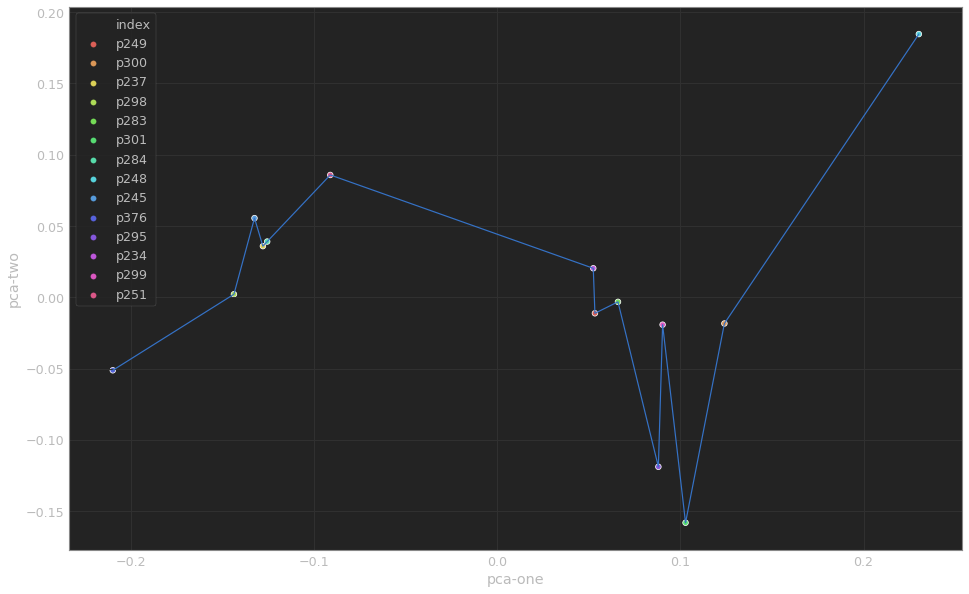

<Figure size 1152x720 with 0 Axes>

In [48]:
df = tsne_visualize(X, y)

p234 p237
p234 p245
p234 p248
p234 p249
p234 p251
p234 p283
p234 p284
p234 p295
p234 p298
p234 p299
p234 p300
p234 p301
p234 p376
p237 p245
p237 p248
p237 p249
p237 p251
p237 p283
p237 p284
p237 p295
p237 p298


/home/dexter/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


p237 p299
p237 p300
p237 p301
p237 p376
p245 p248
p245 p249
p245 p251
p245 p283
p245 p284
p245 p295
p245 p298
p245 p299
p245 p300
p245 p301
p245 p376
p248 p249
p248 p251
p248 p283
p248 p284
p248 p295
p248 p298
p248 p299
p248 p300
p248 p301
p248 p376
p249 p251
p249 p283
p249 p284
p249 p295
p249 p298
p249 p299
p249 p300
p249 p301
p249 p376
p251 p283
p251 p284
p251 p295
p251 p298
p251 p299
p251 p300
p251 p301
p251 p376
p283 p284
p283 p295
p283 p298
p283 p299
p283 p300
p283 p301
p283 p376
p284 p295
p284 p298
p284 p299
p284 p300
p284 p301
p284 p376
p295 p298
p295 p299
p295 p300
p295 p301
p295 p376
p298 p299
p298 p300
p298 p301
p298 p376
p299 p300
p299 p301
p299 p376
p300 p301
p300 p376
p301 p376


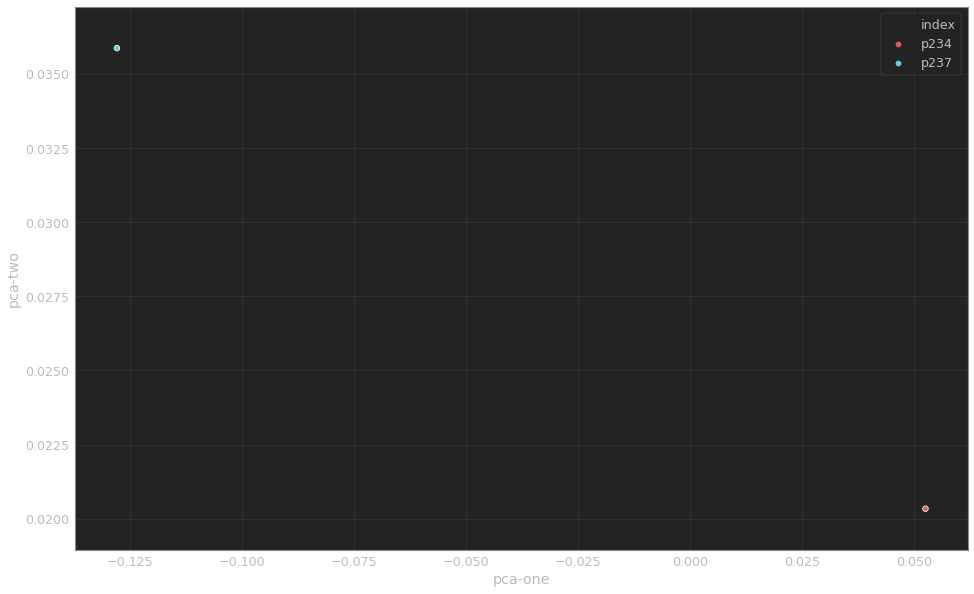

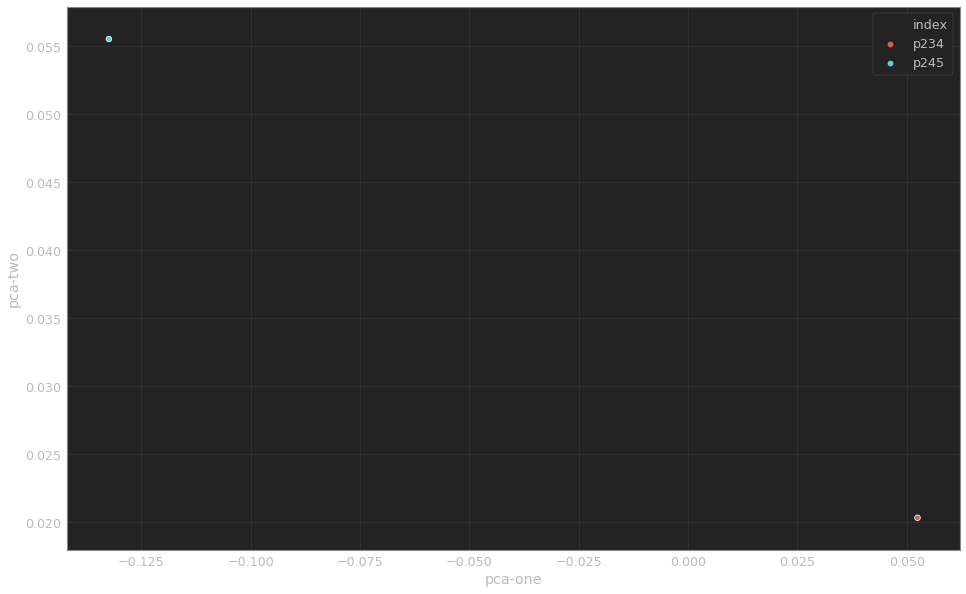

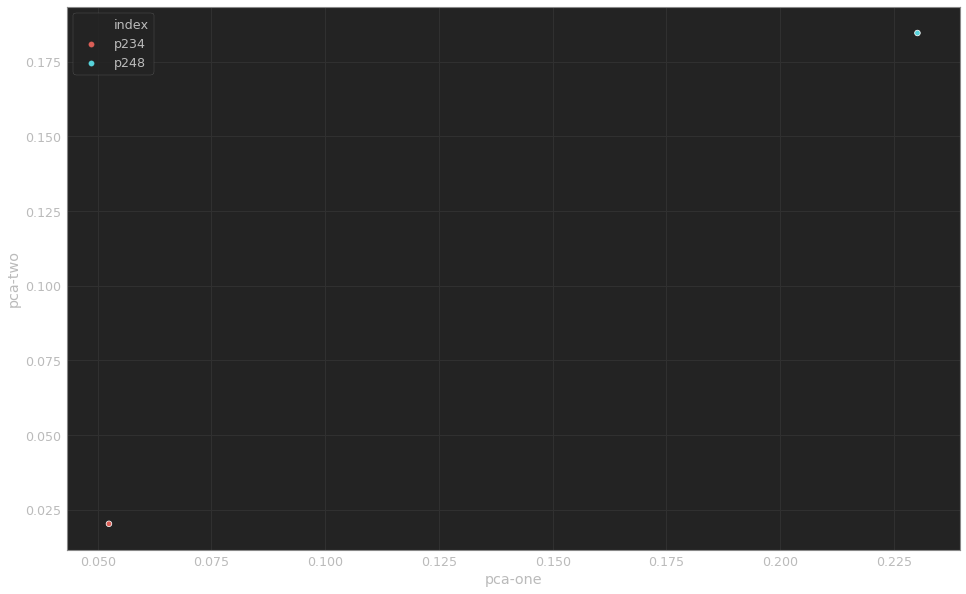

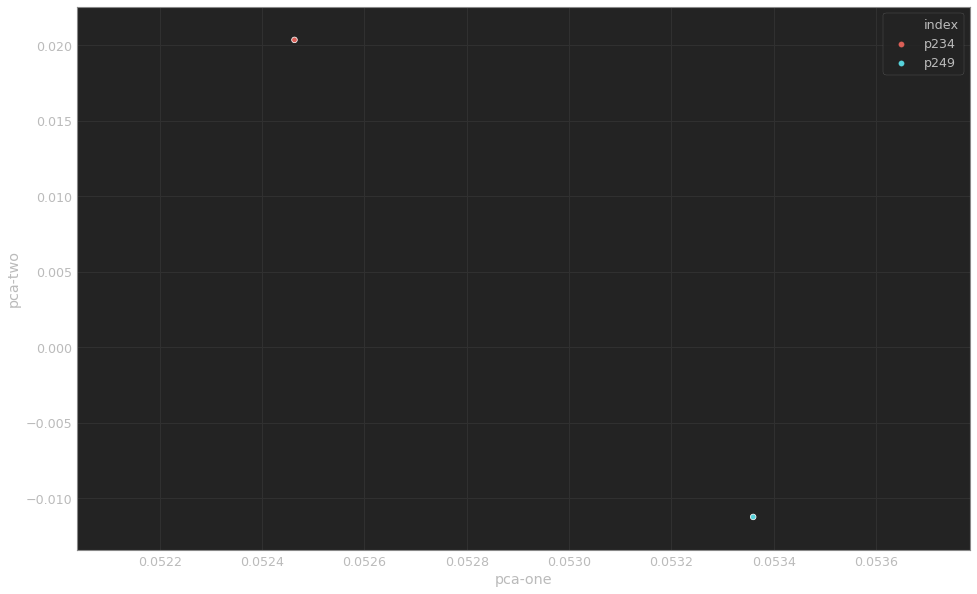

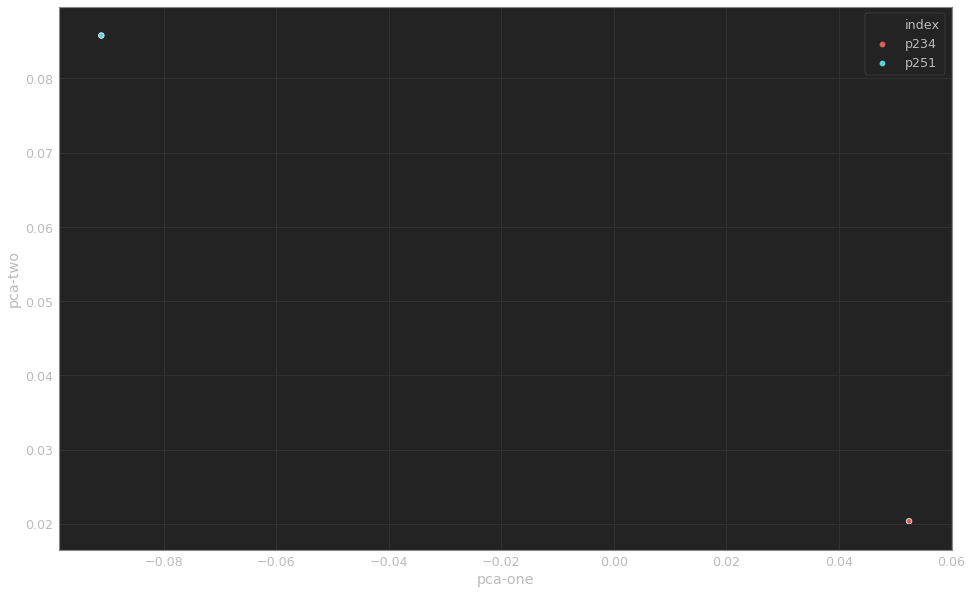

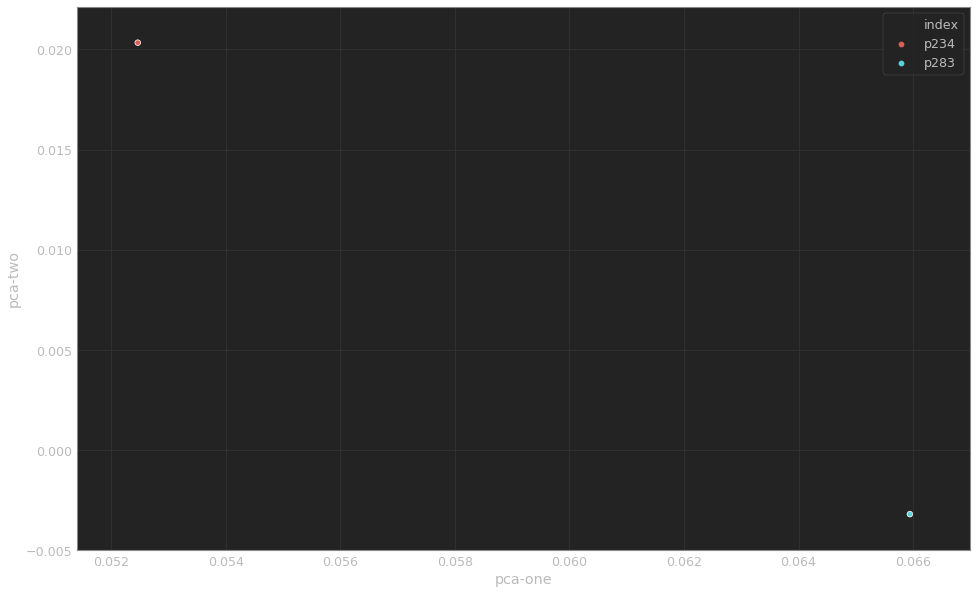

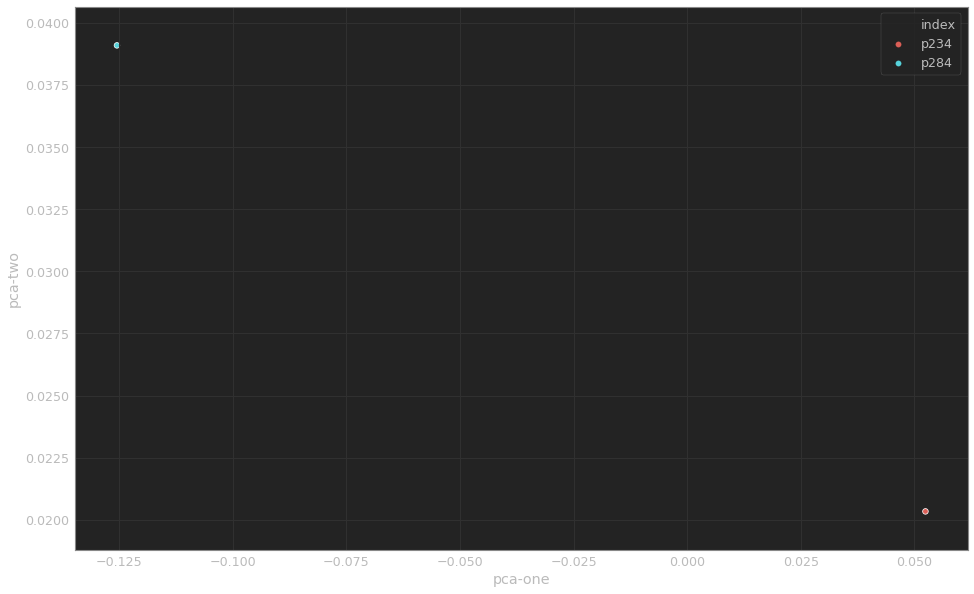

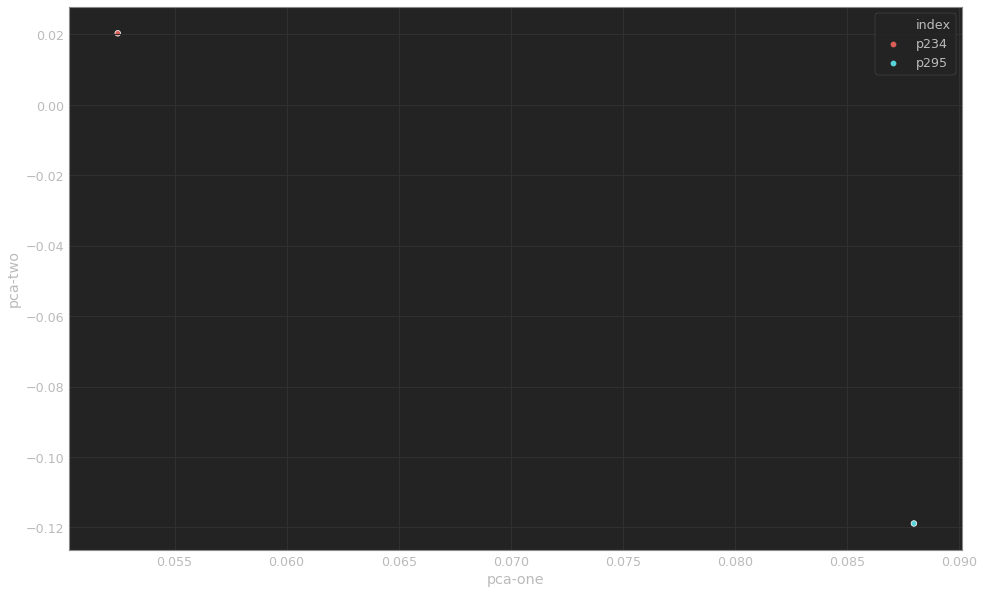

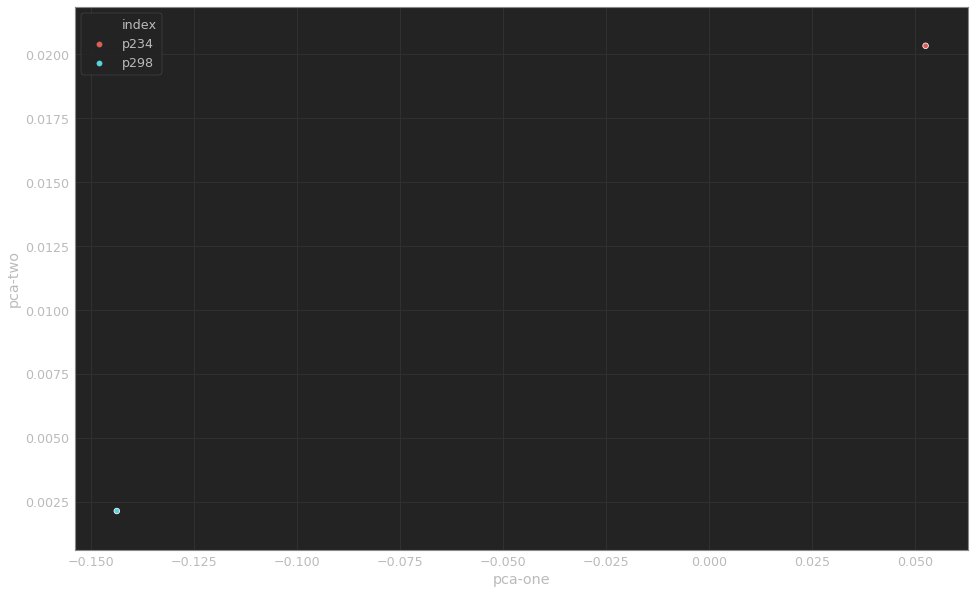

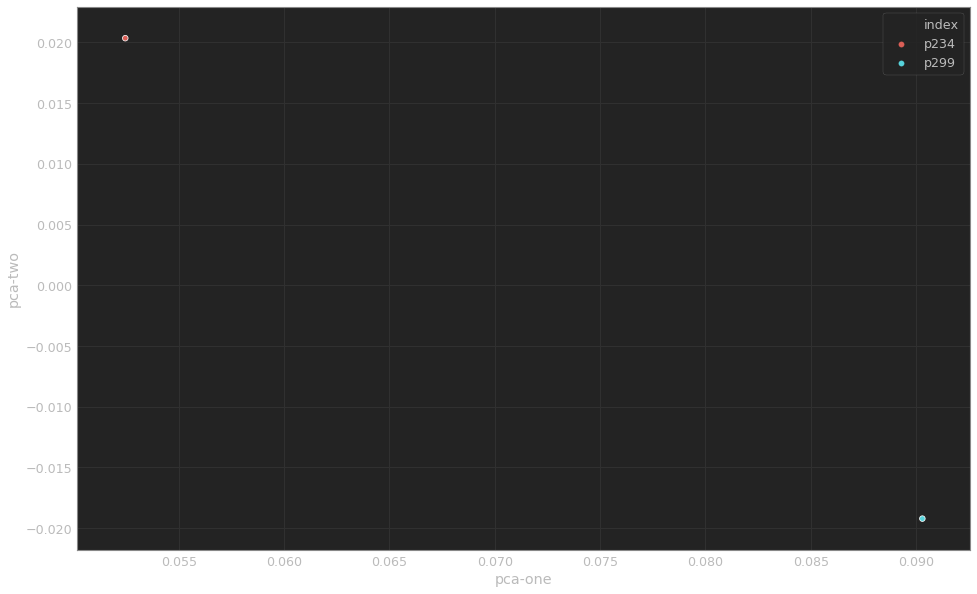

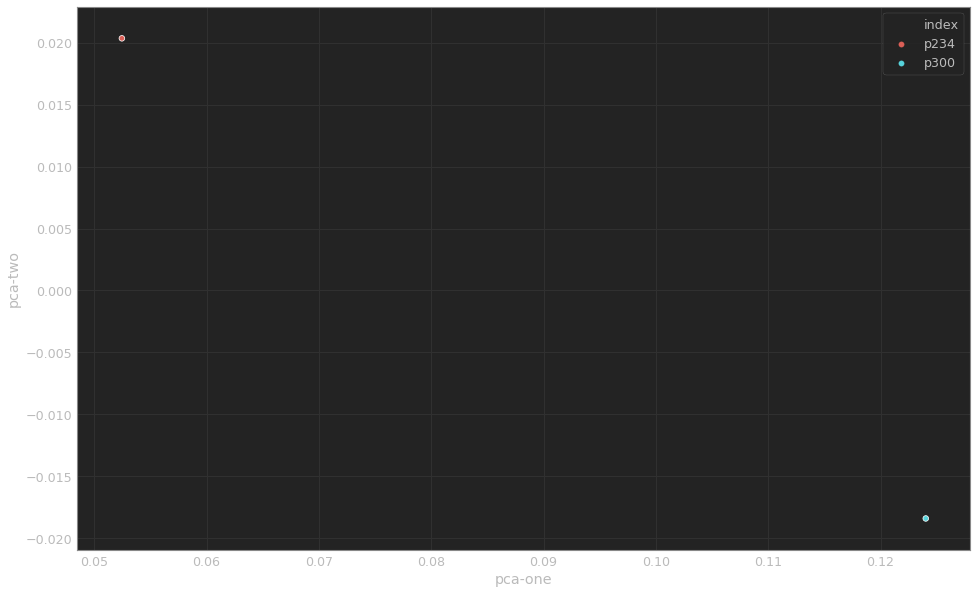

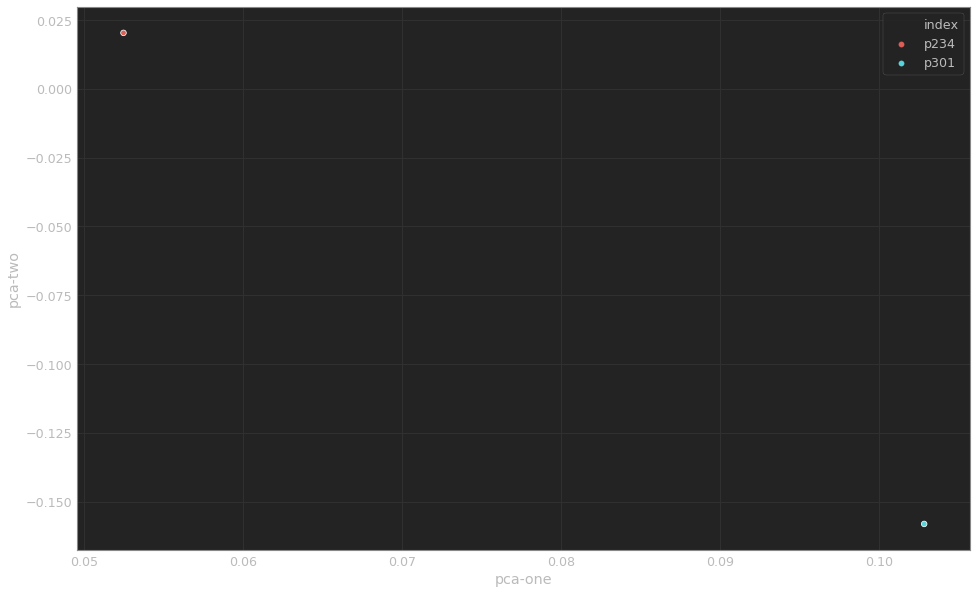

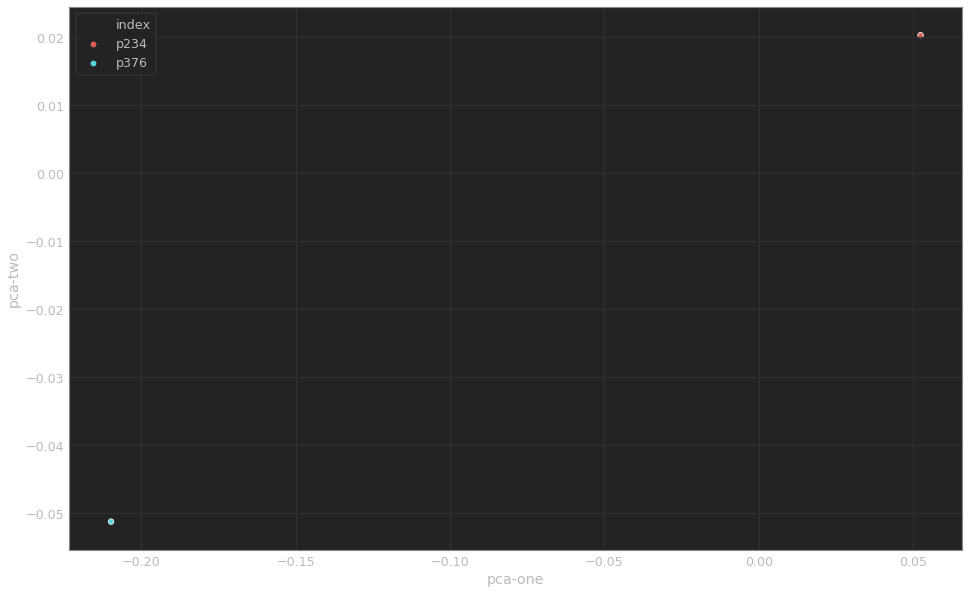

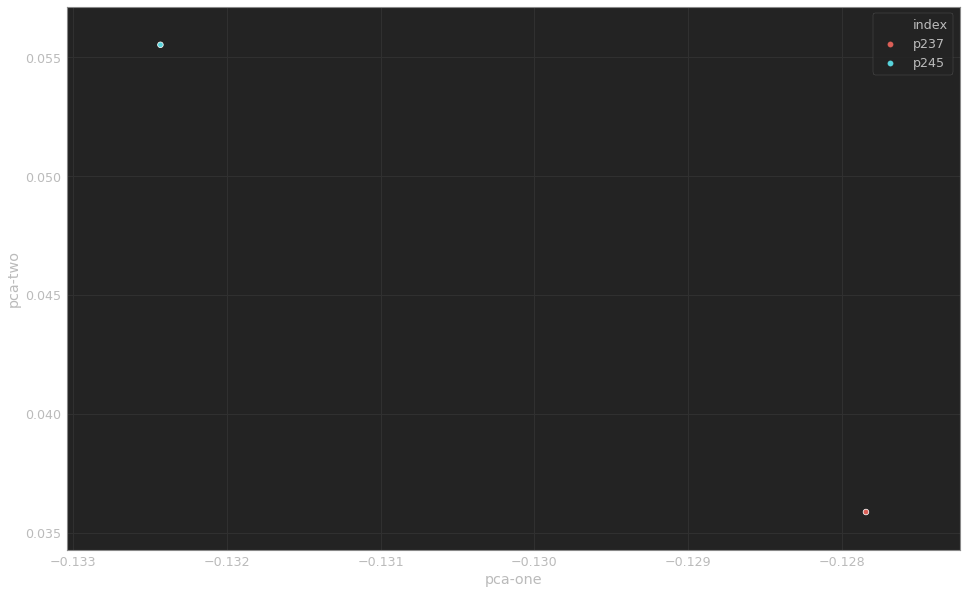

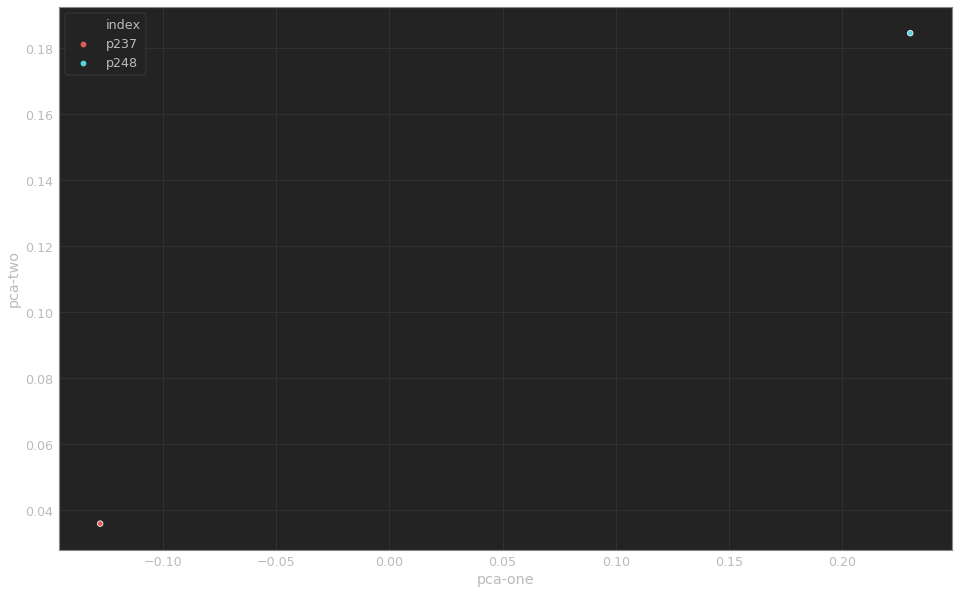

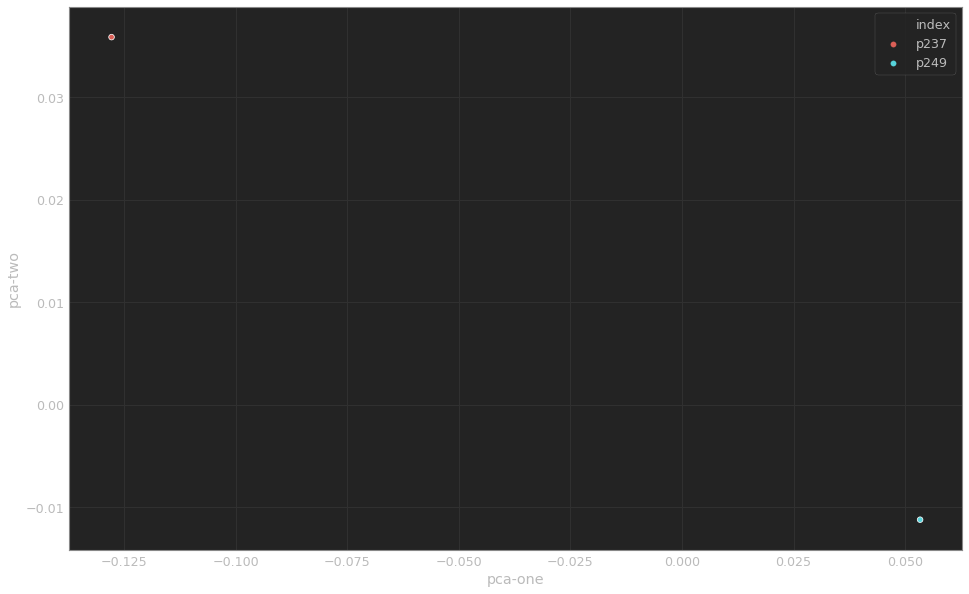

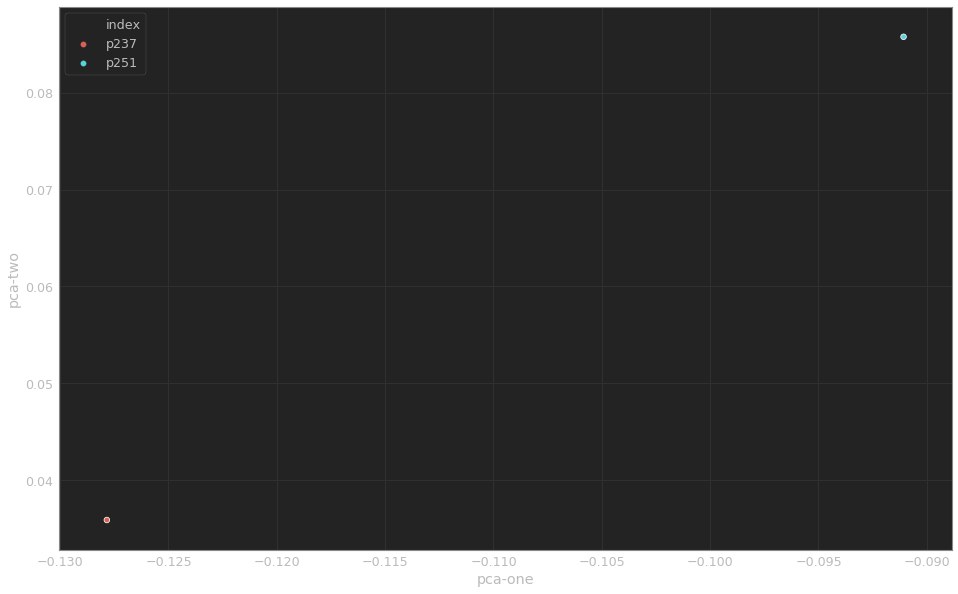

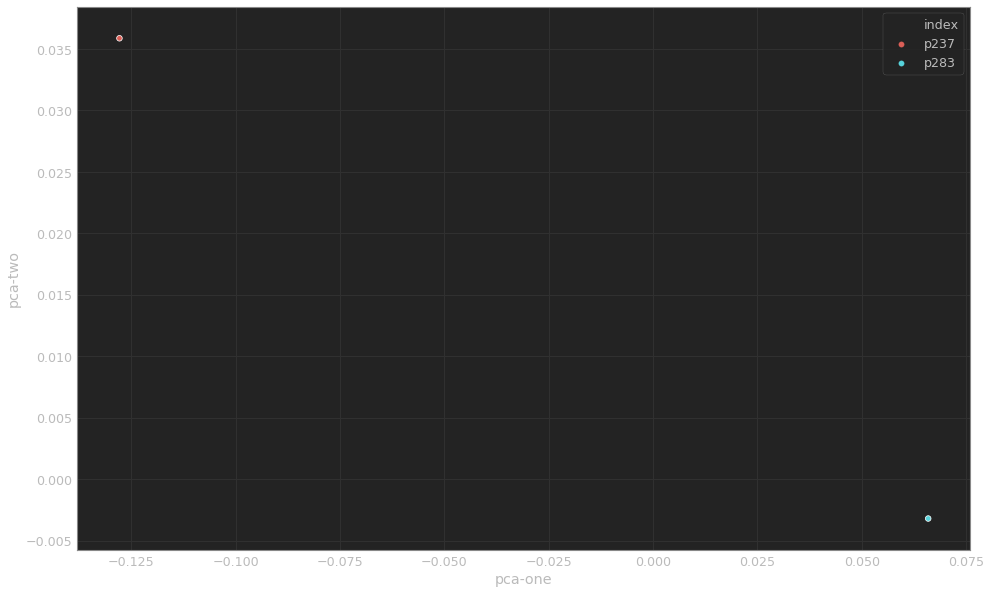

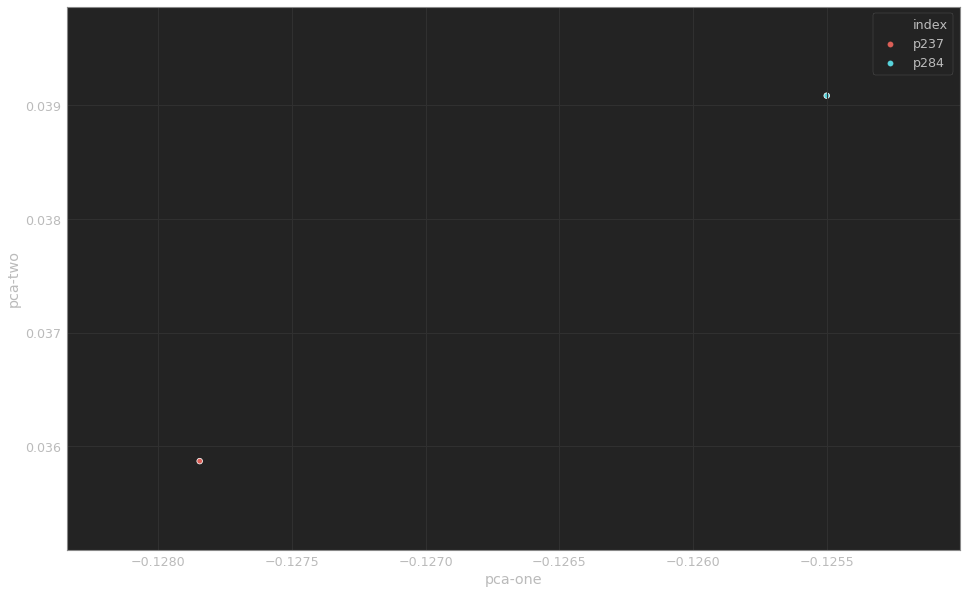

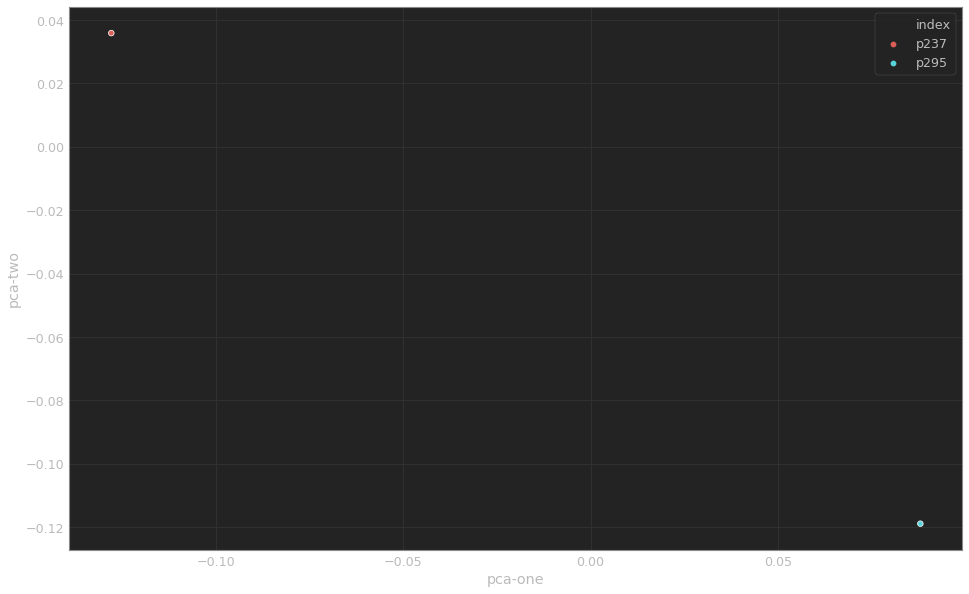

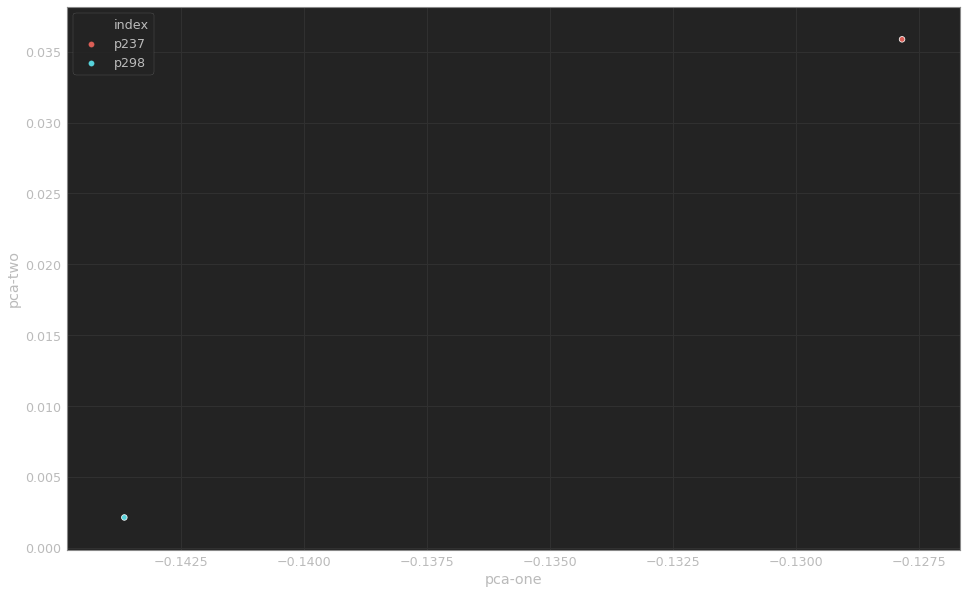

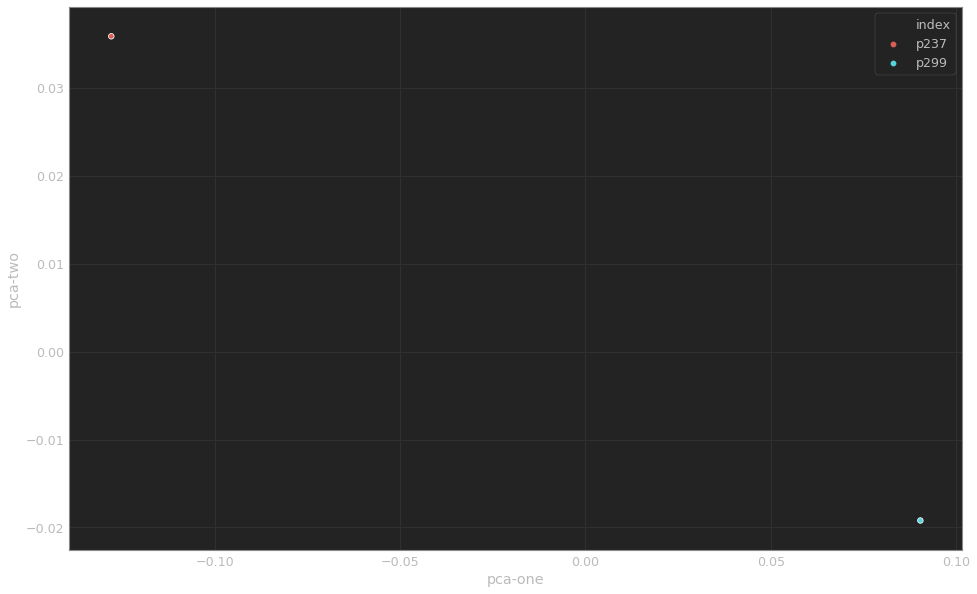

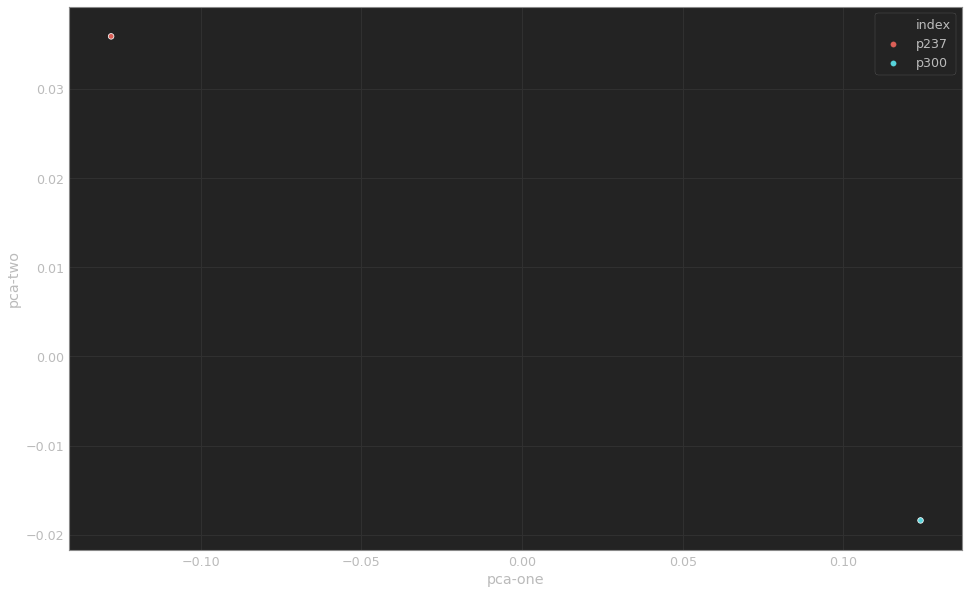

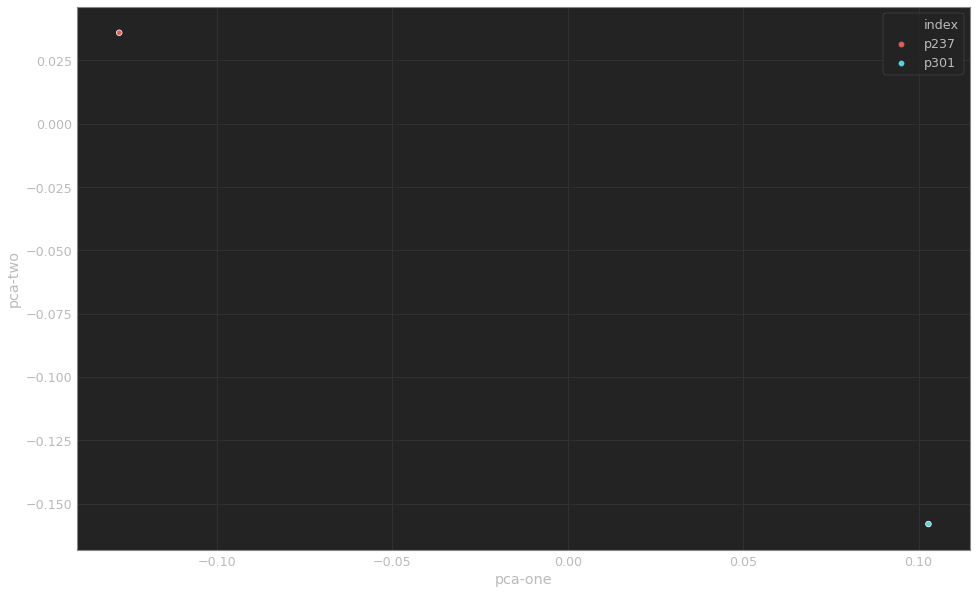

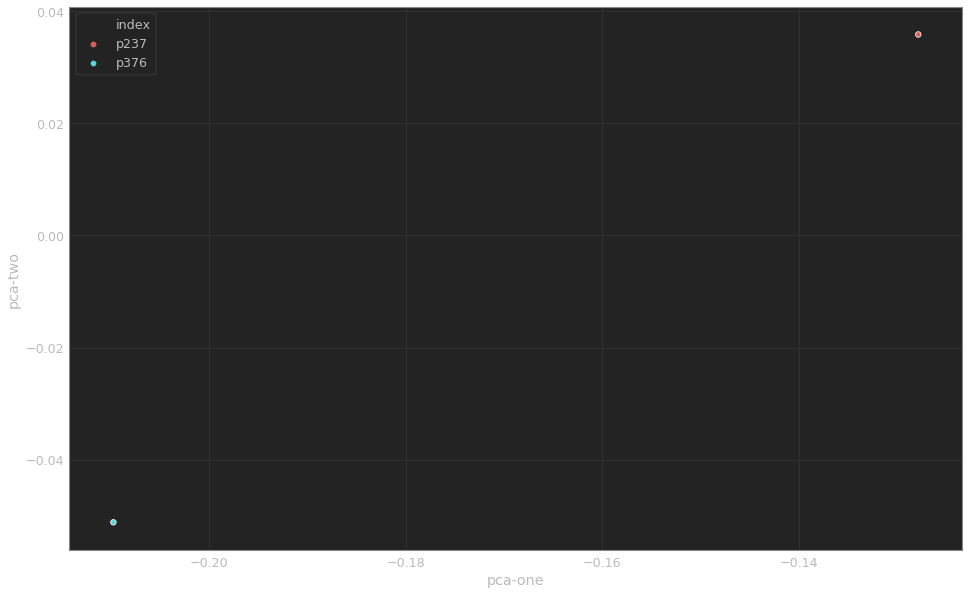

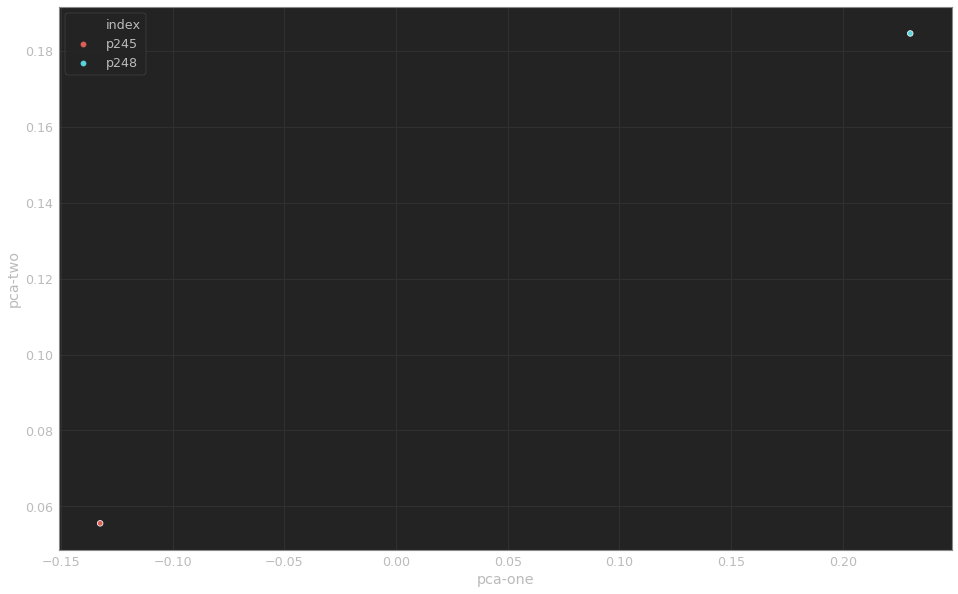

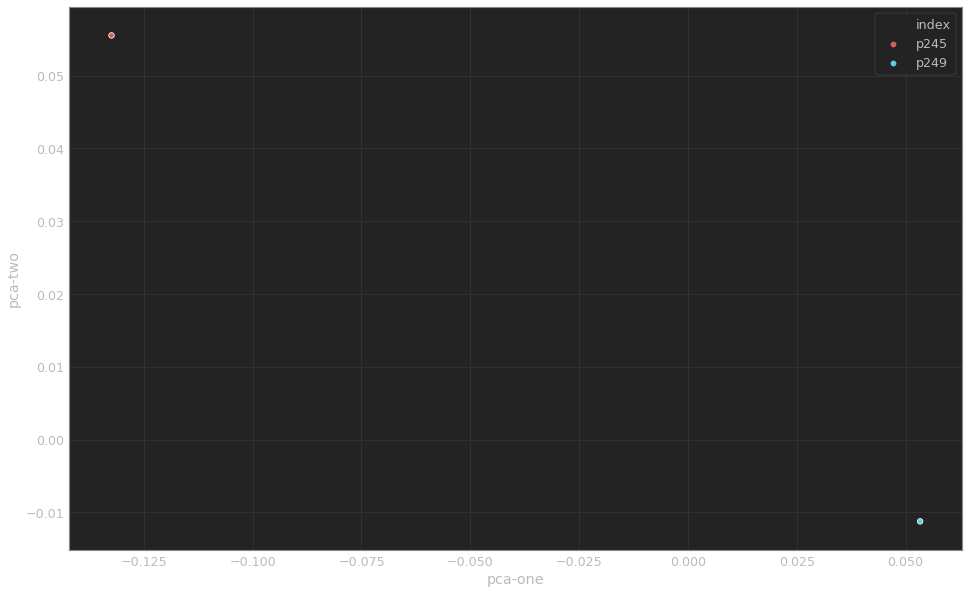

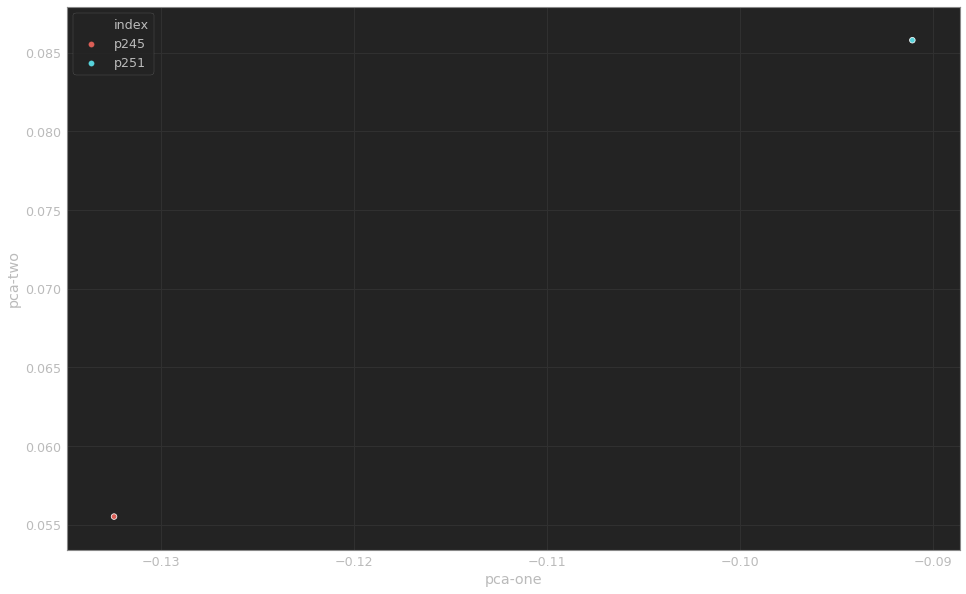

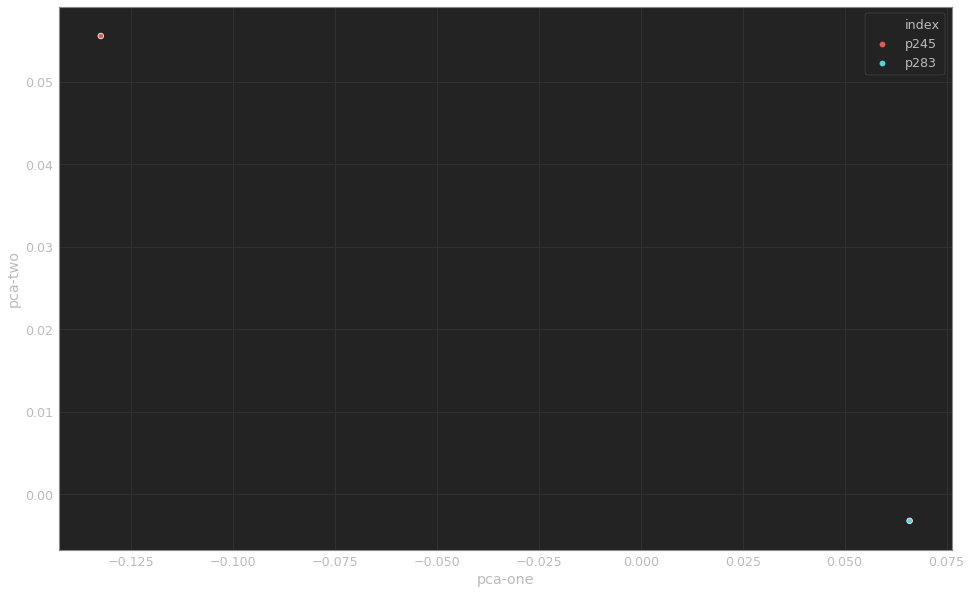

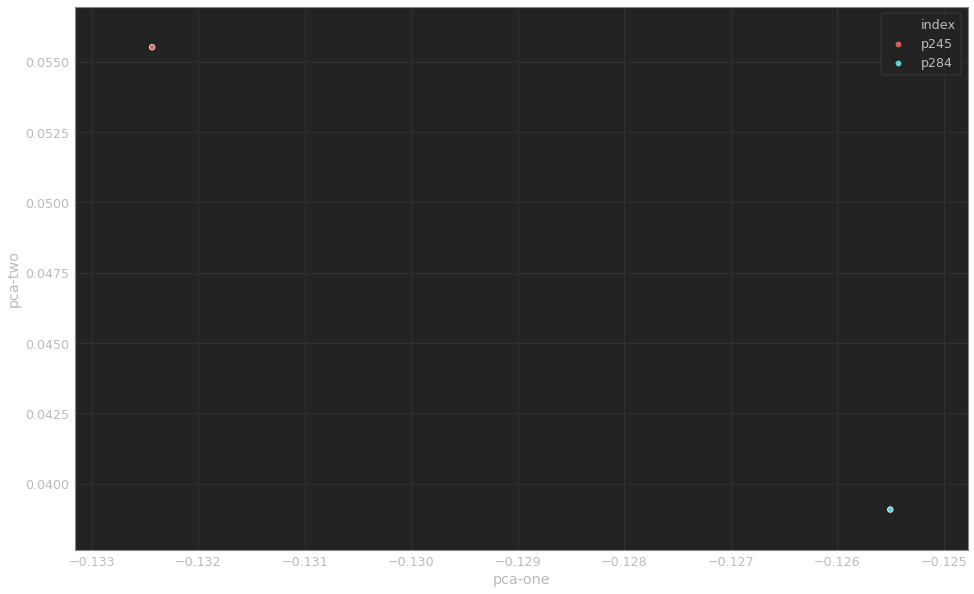

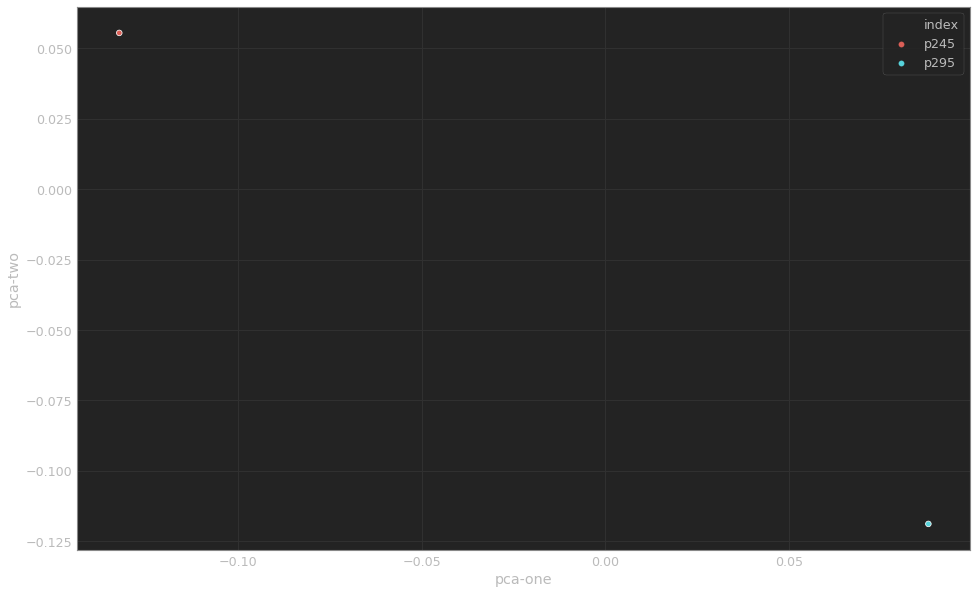

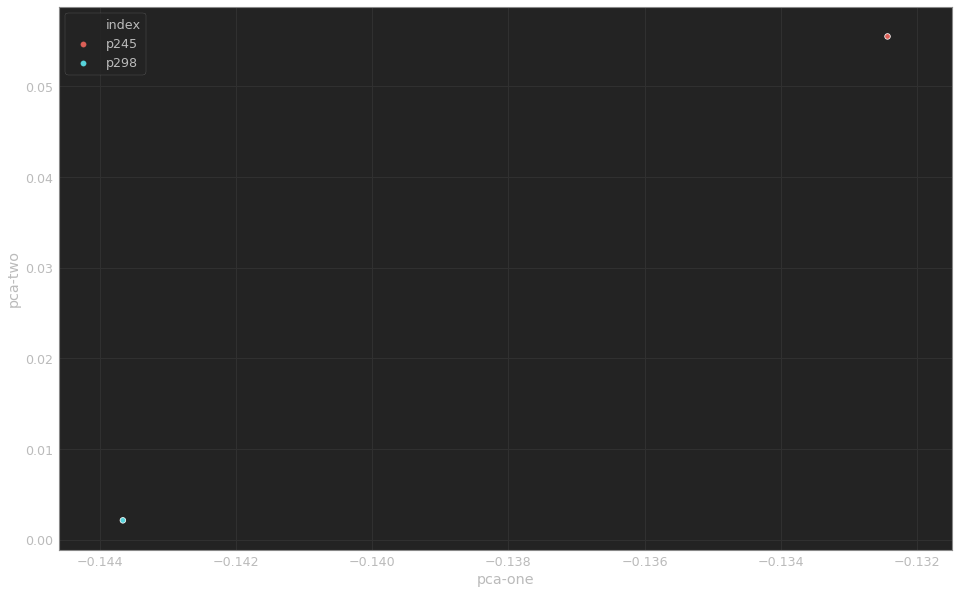

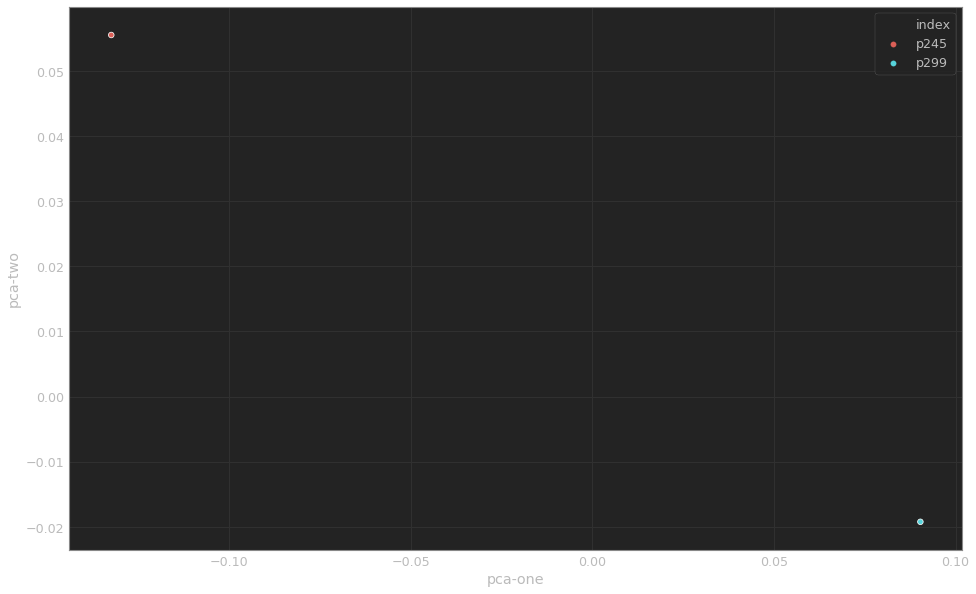

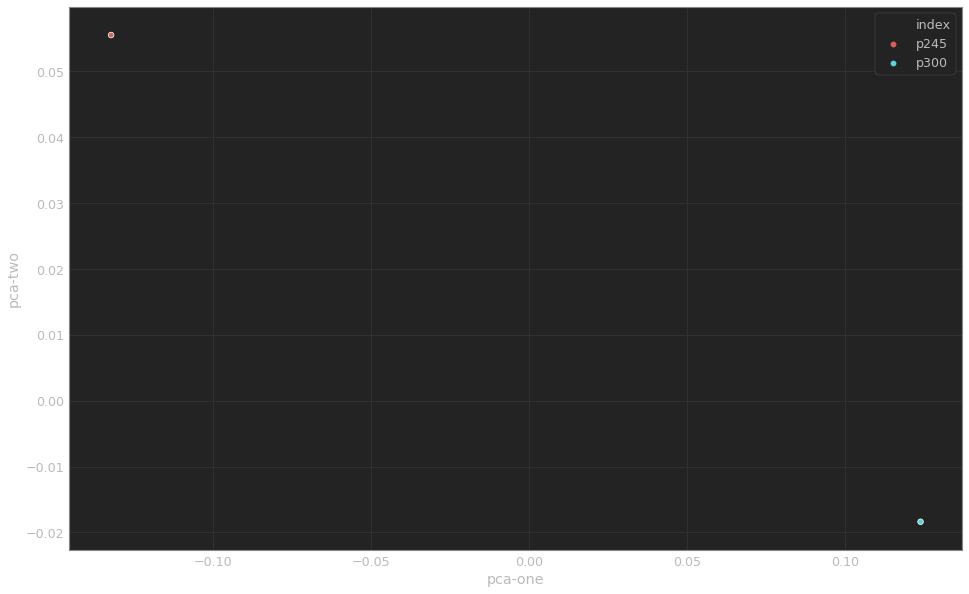

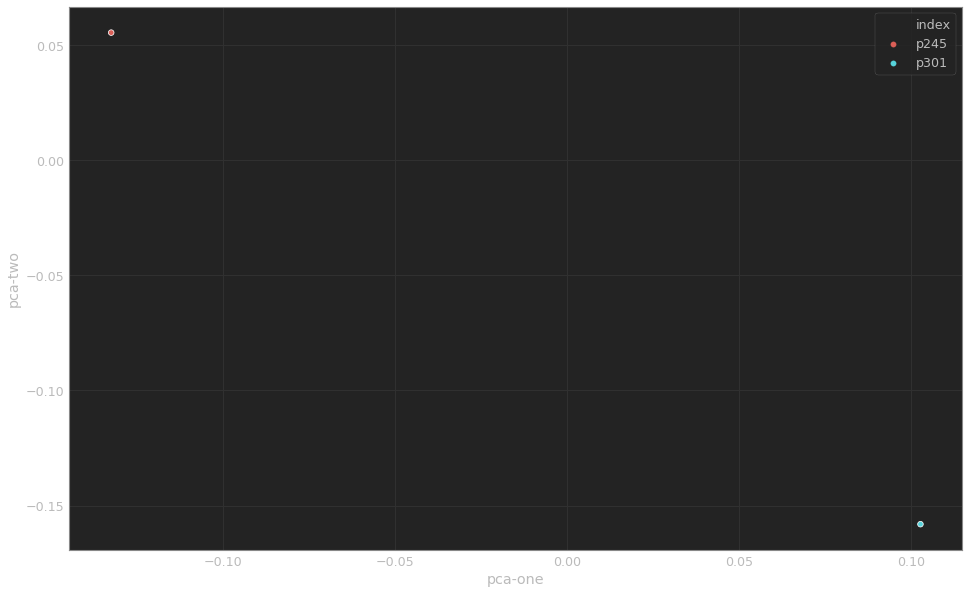

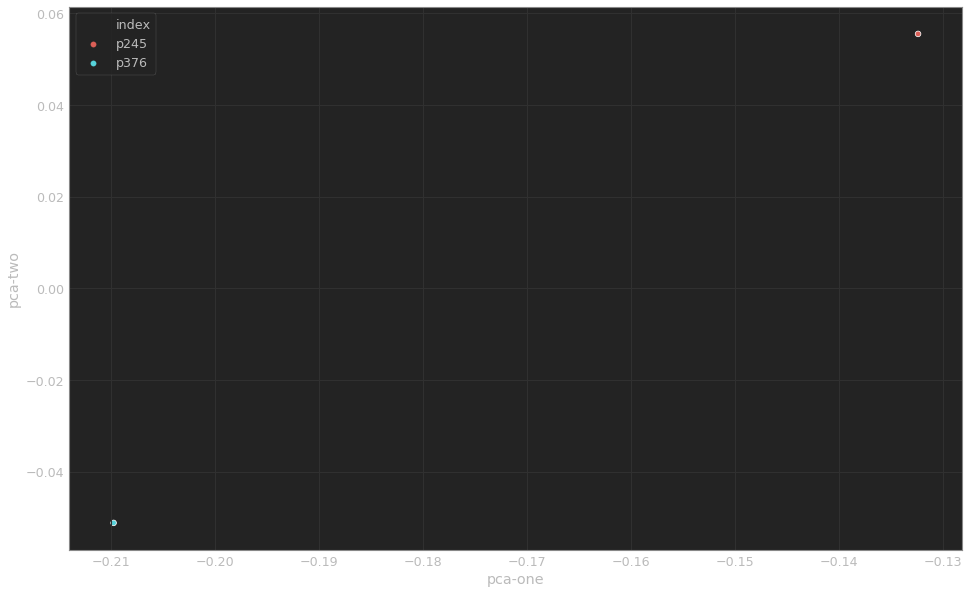

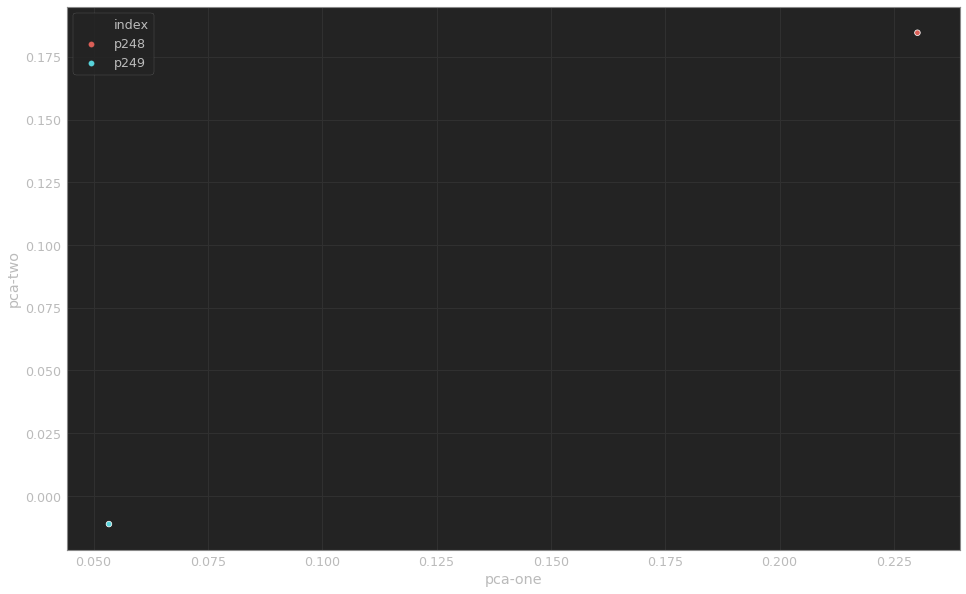

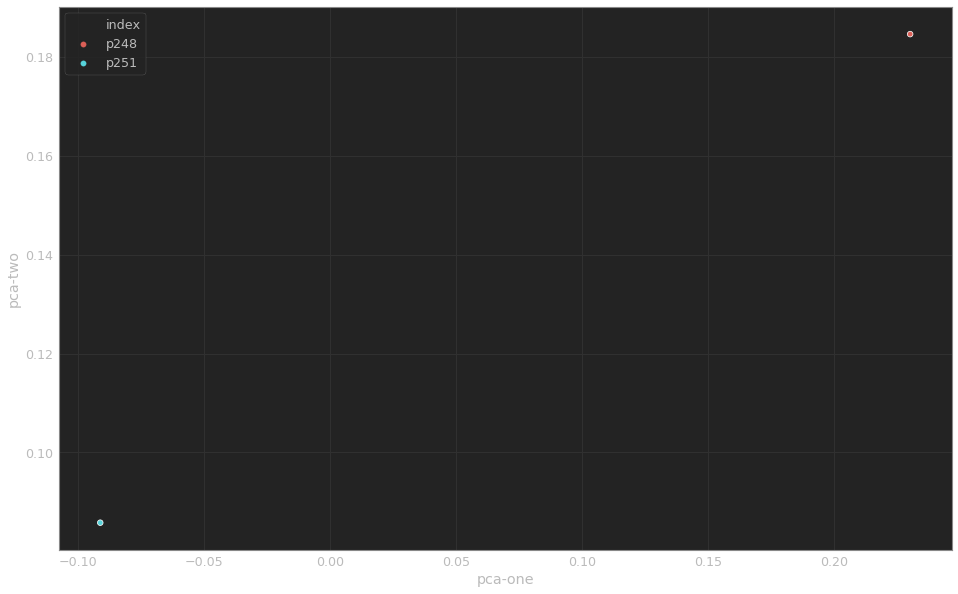

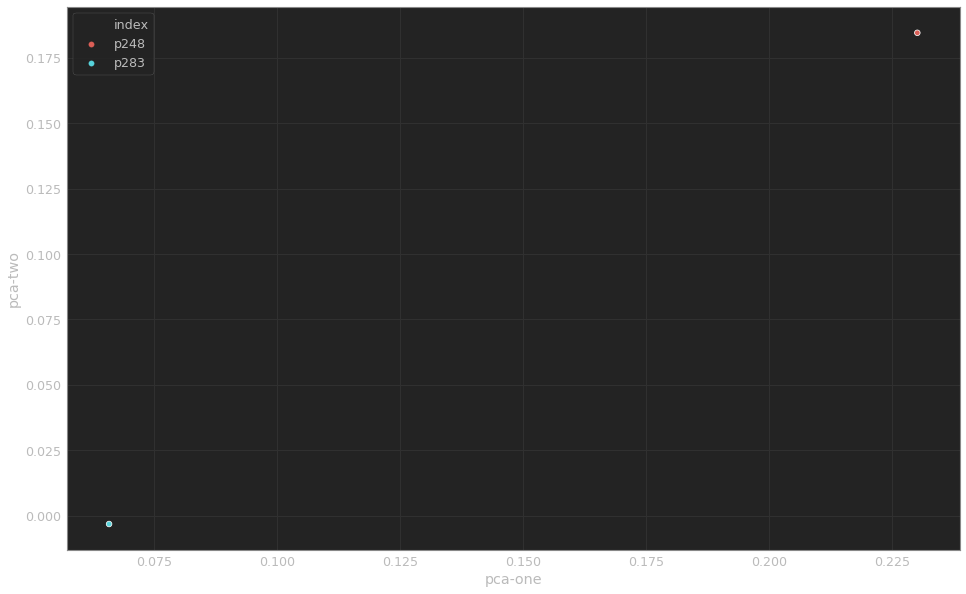

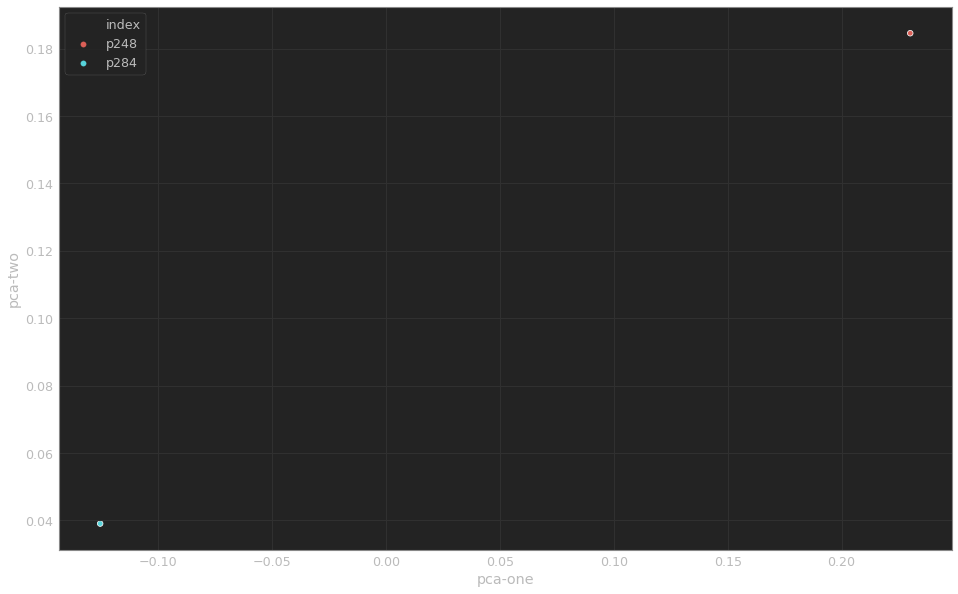

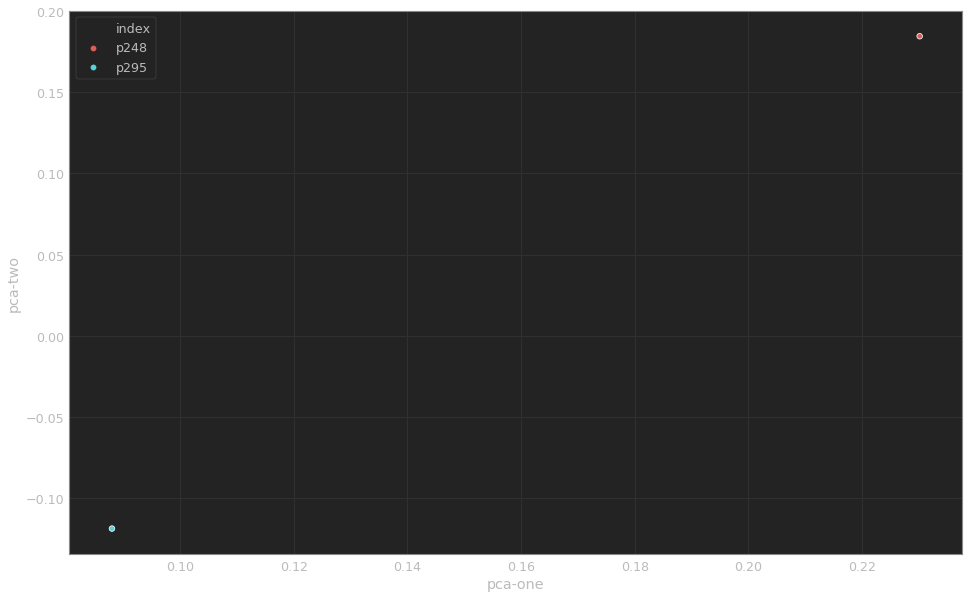

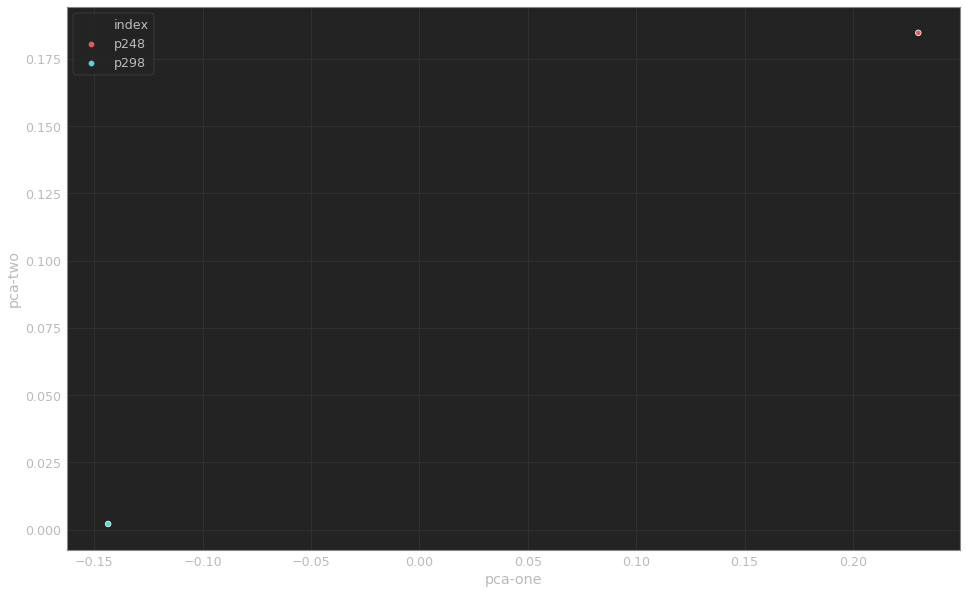

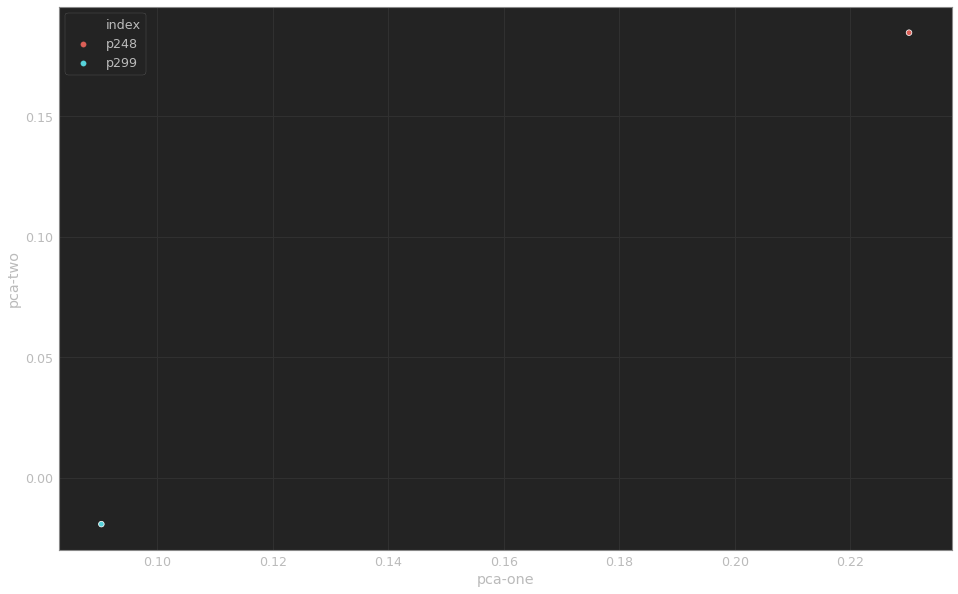

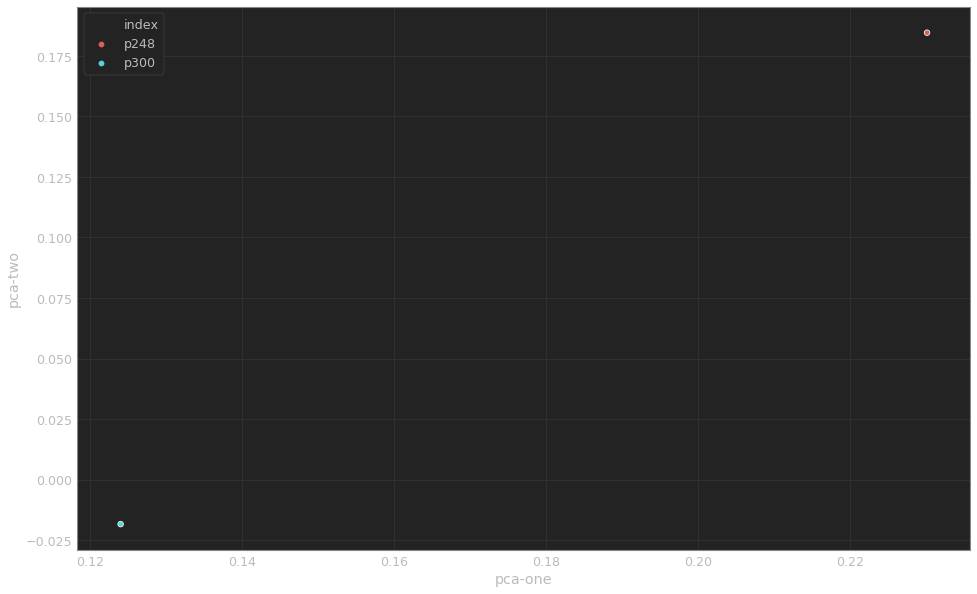

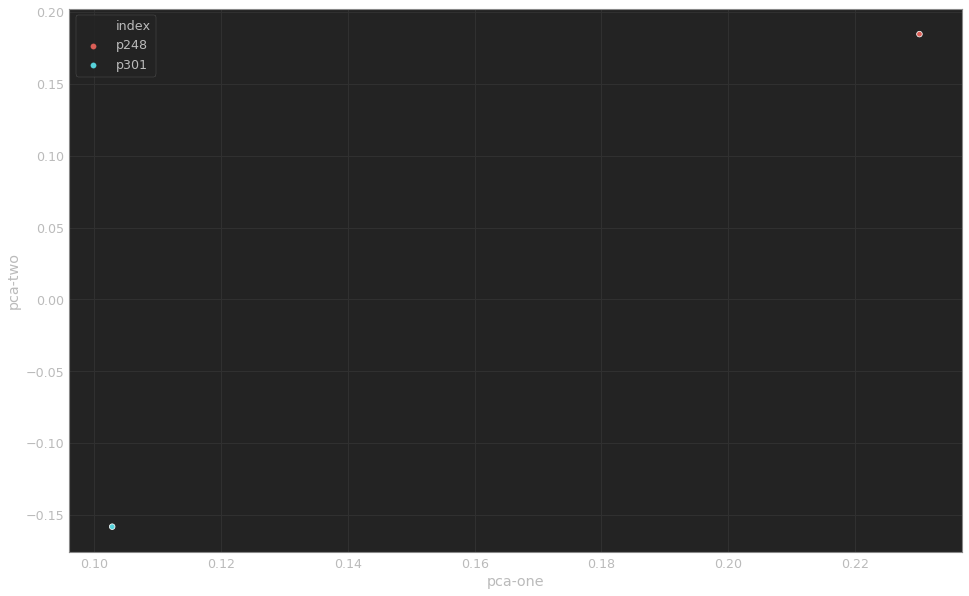

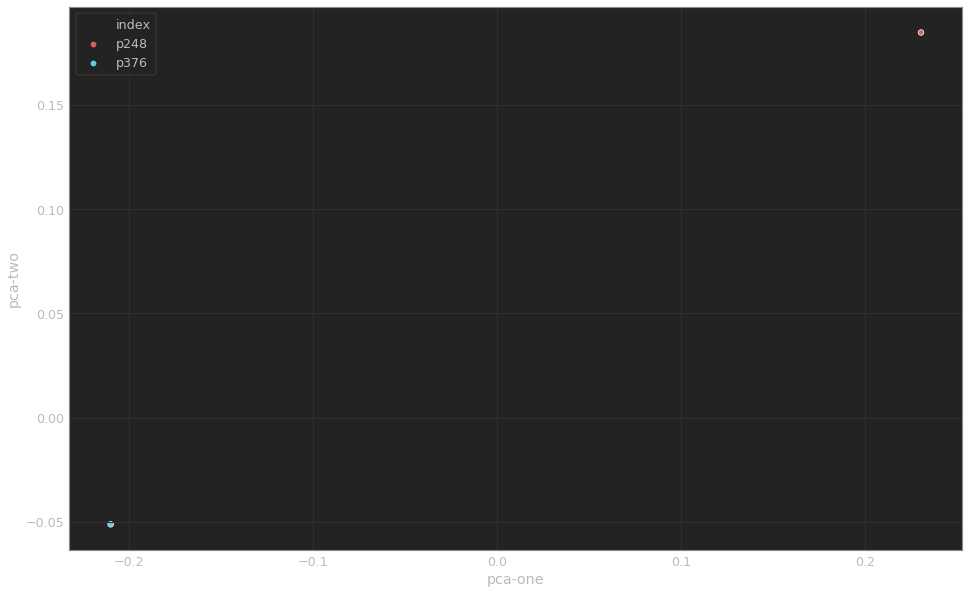

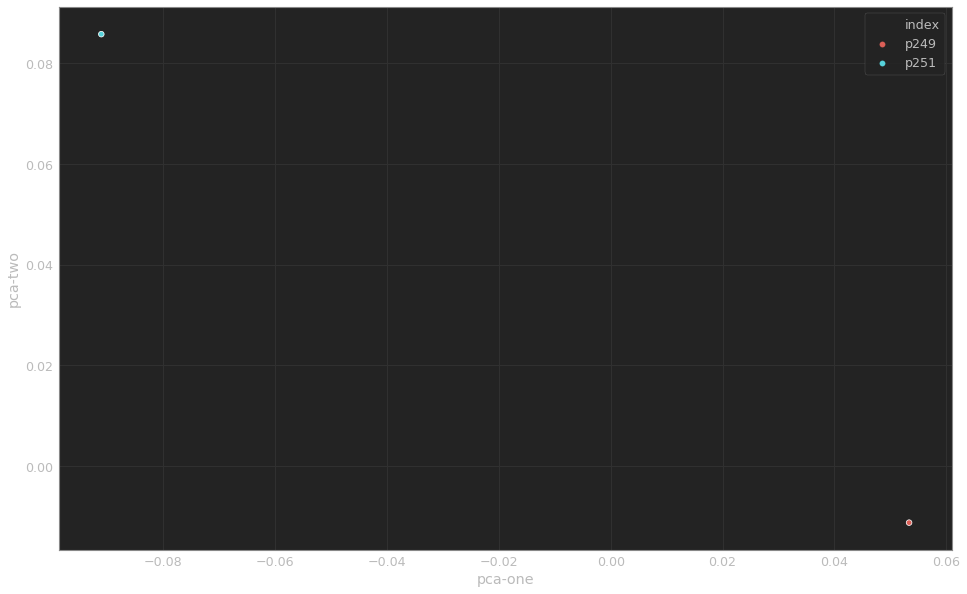

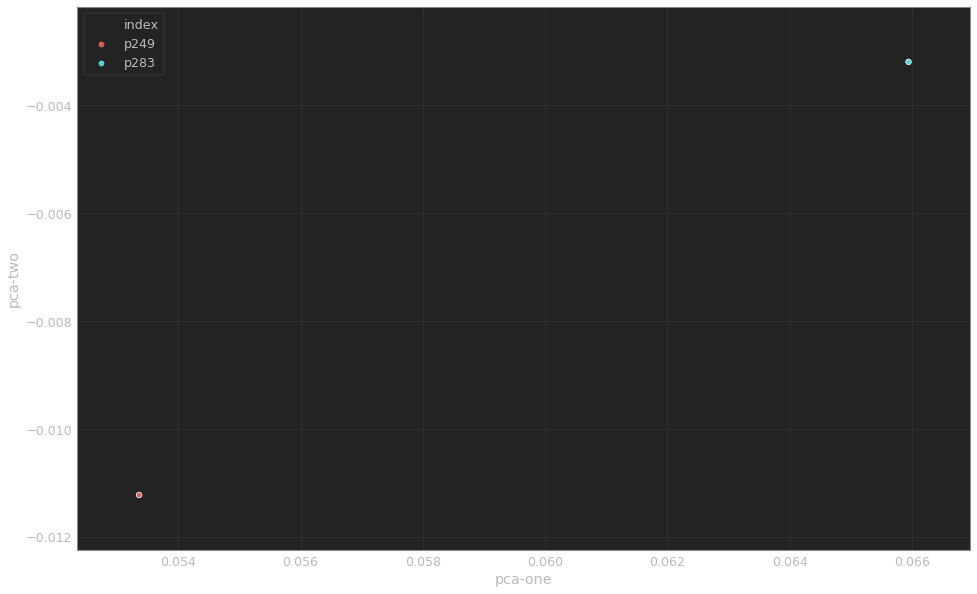

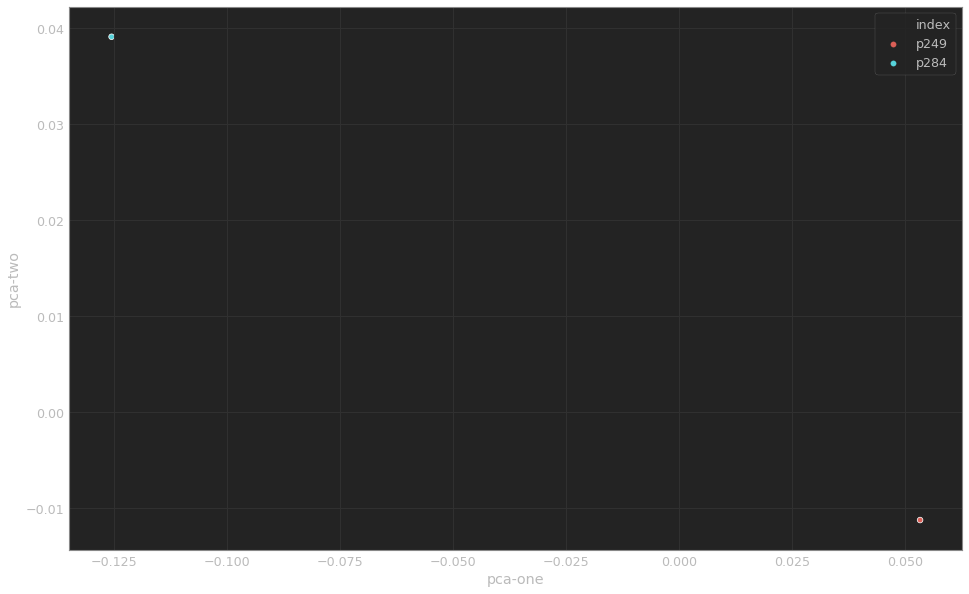

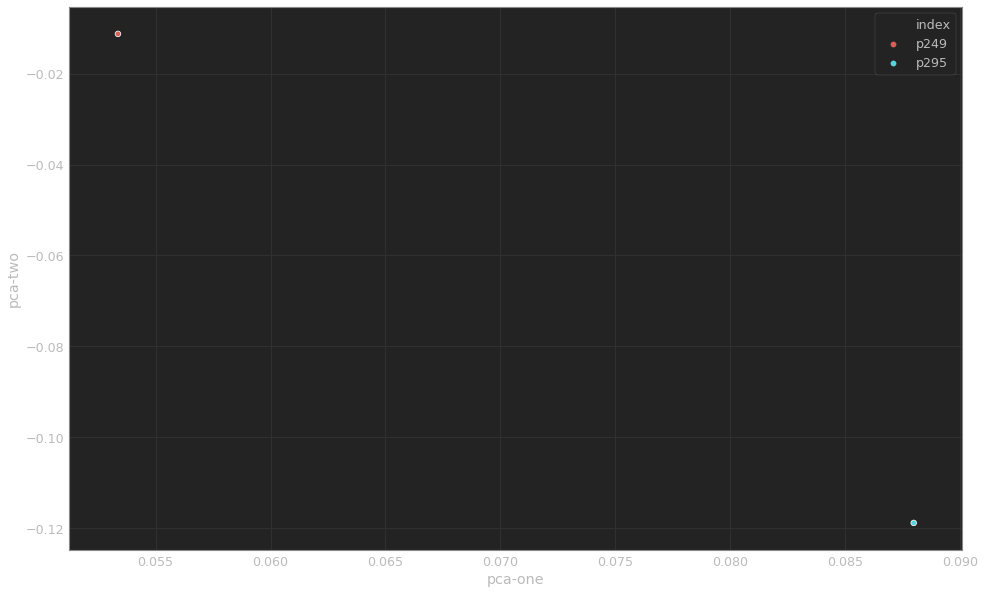

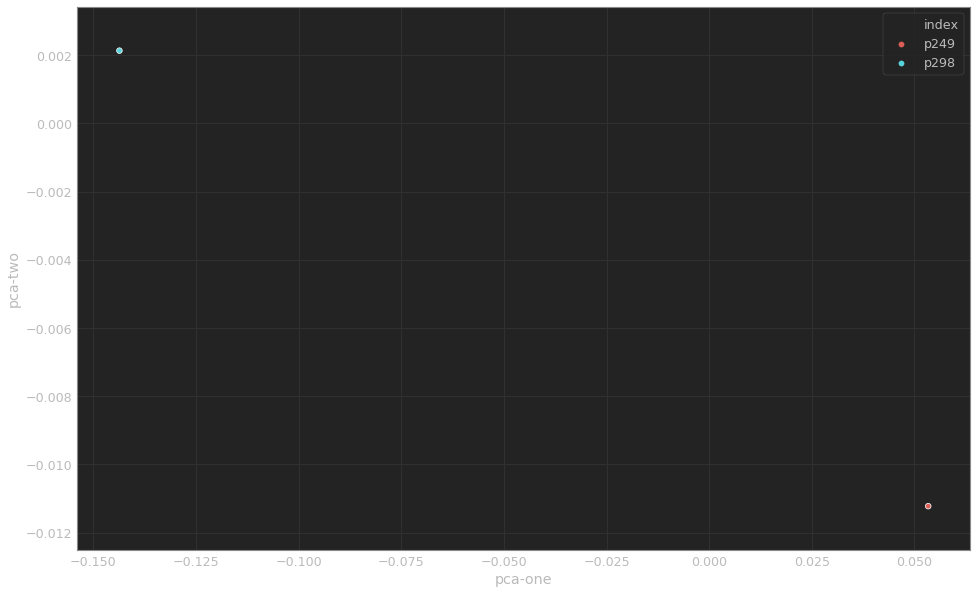

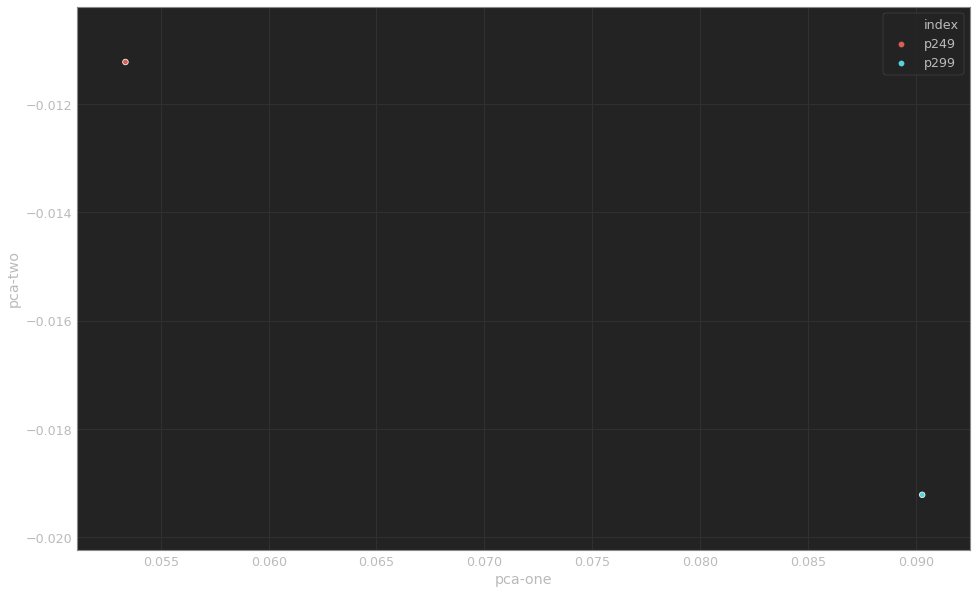

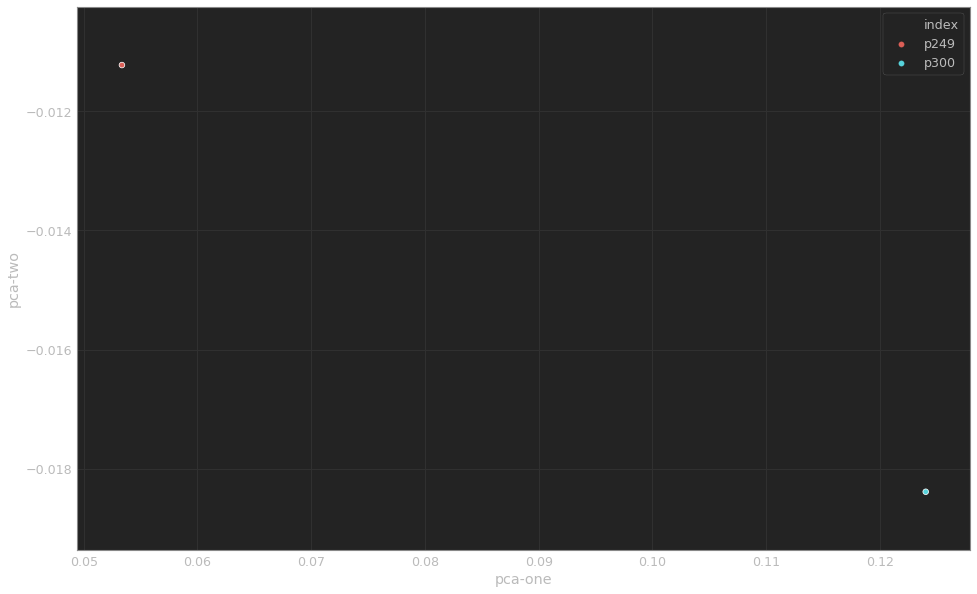

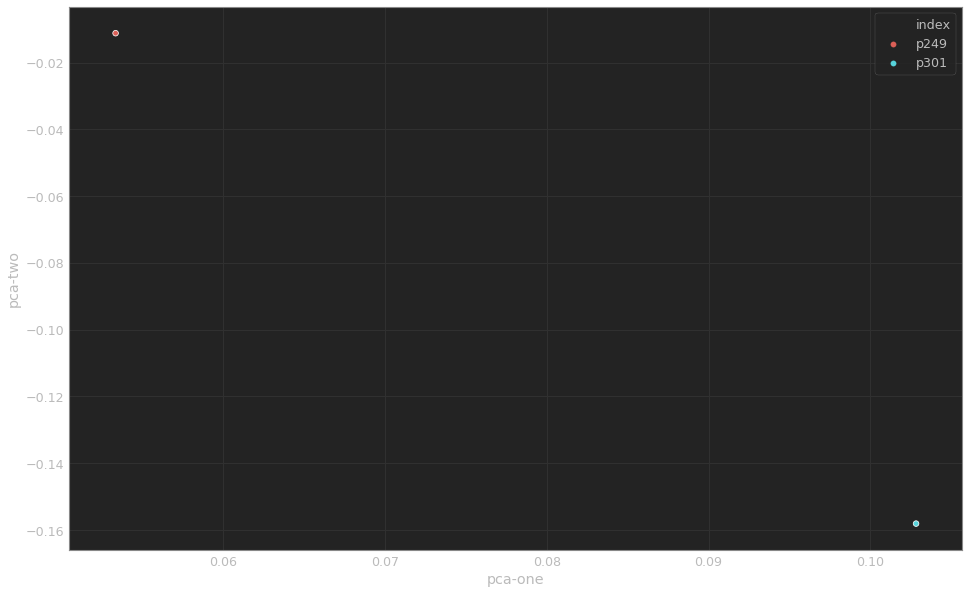

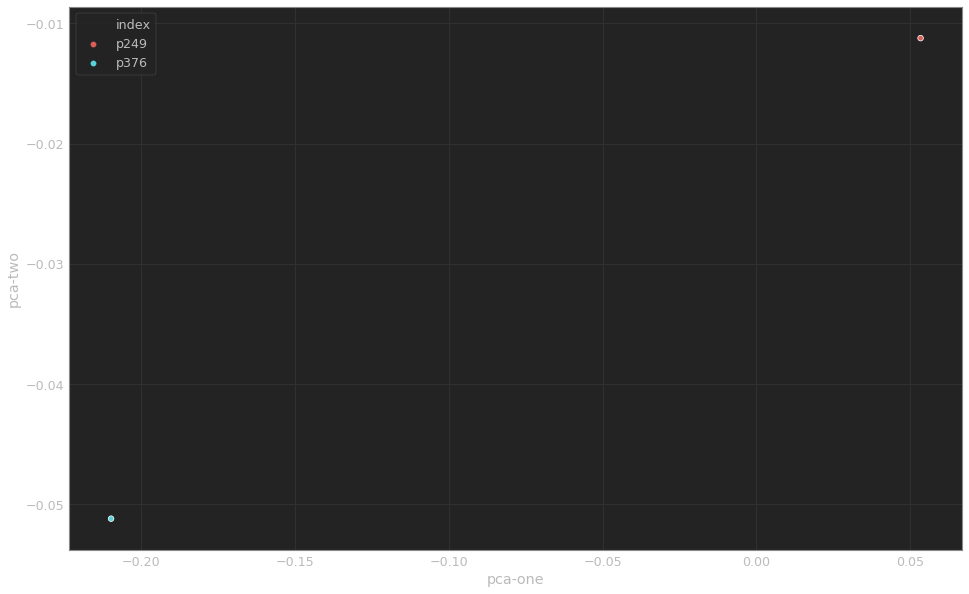

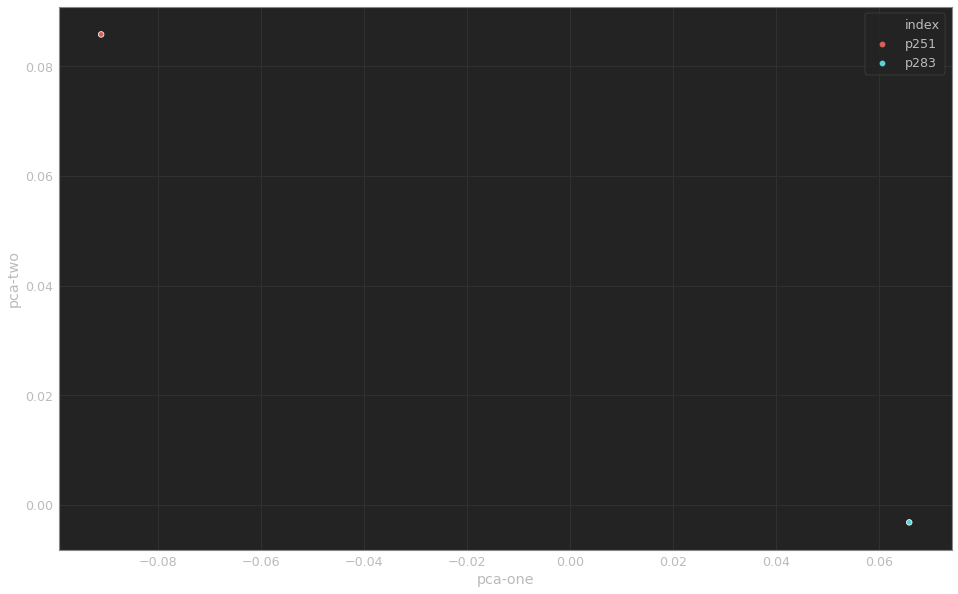

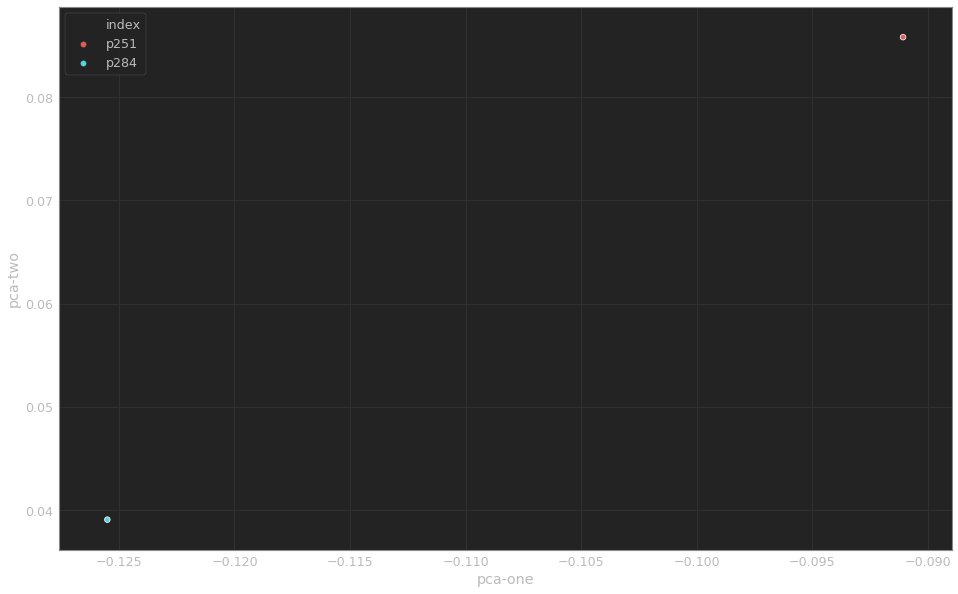

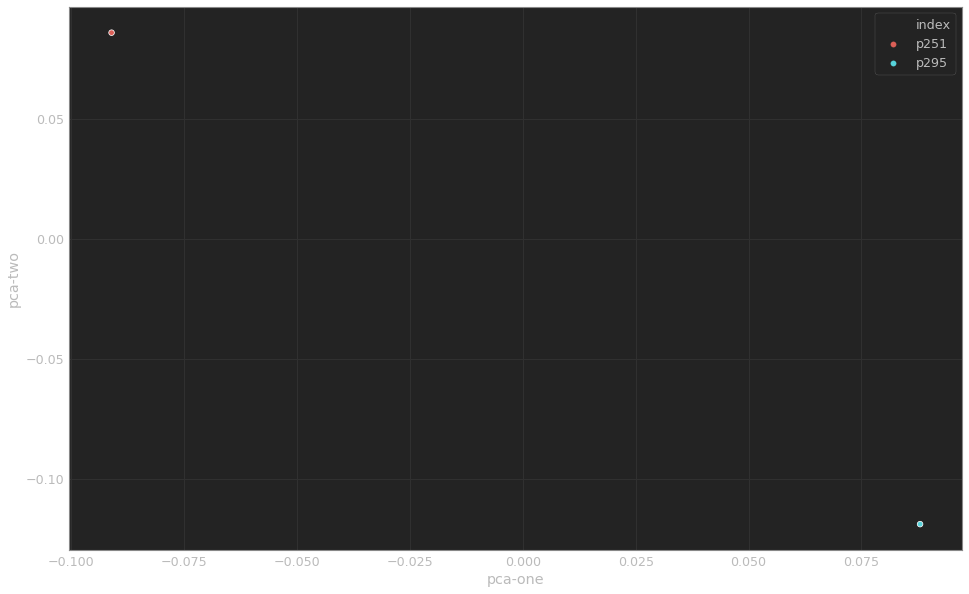

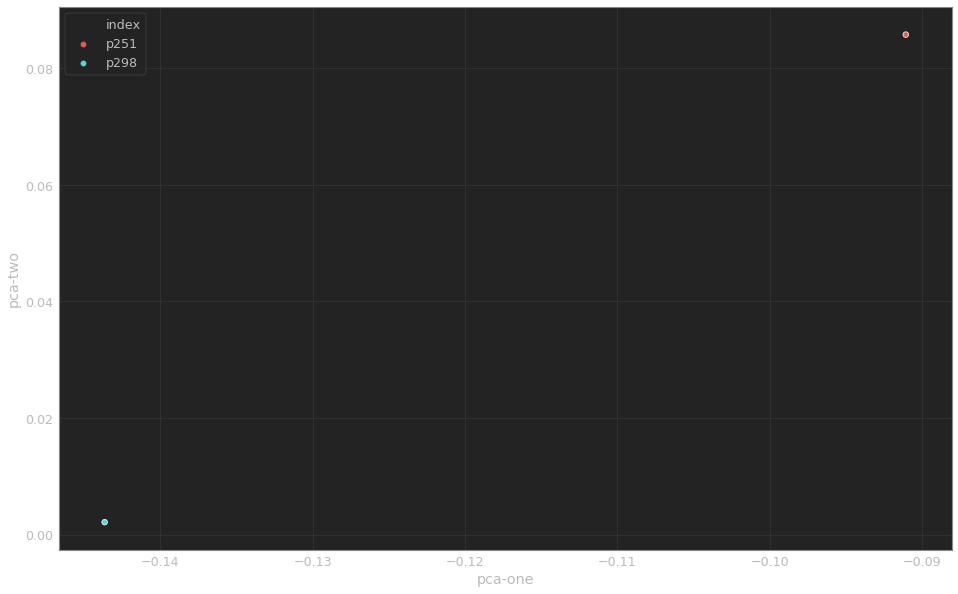

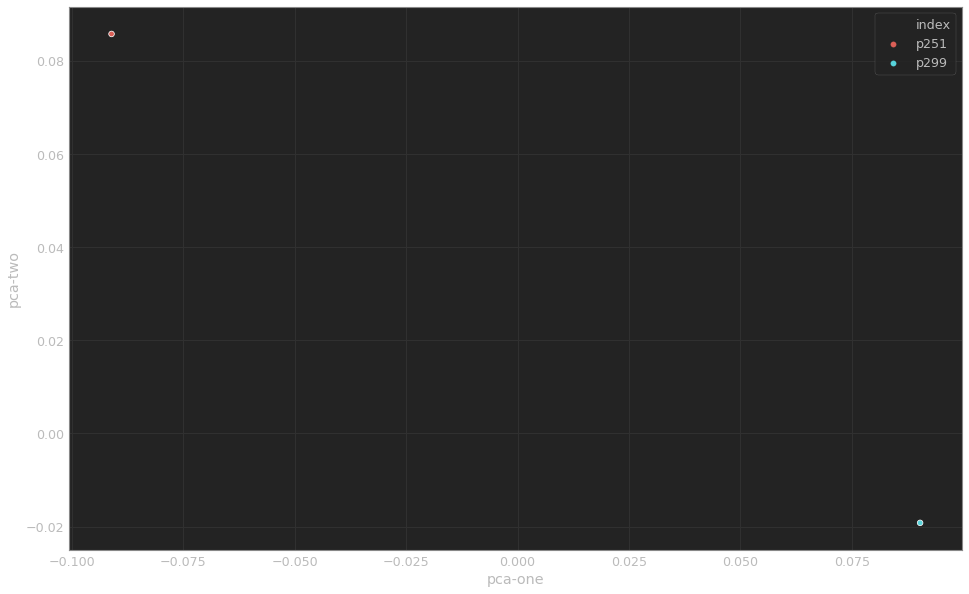

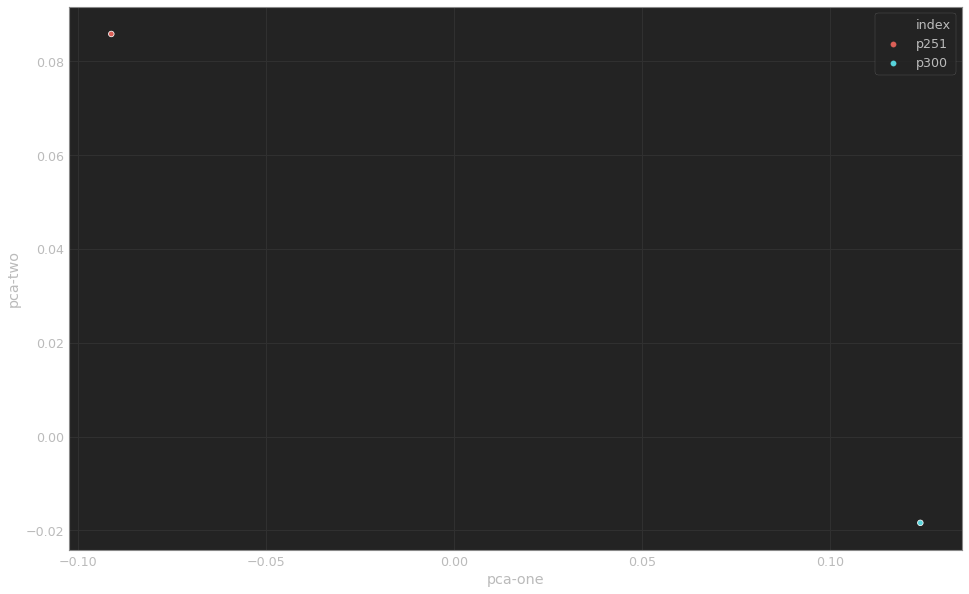

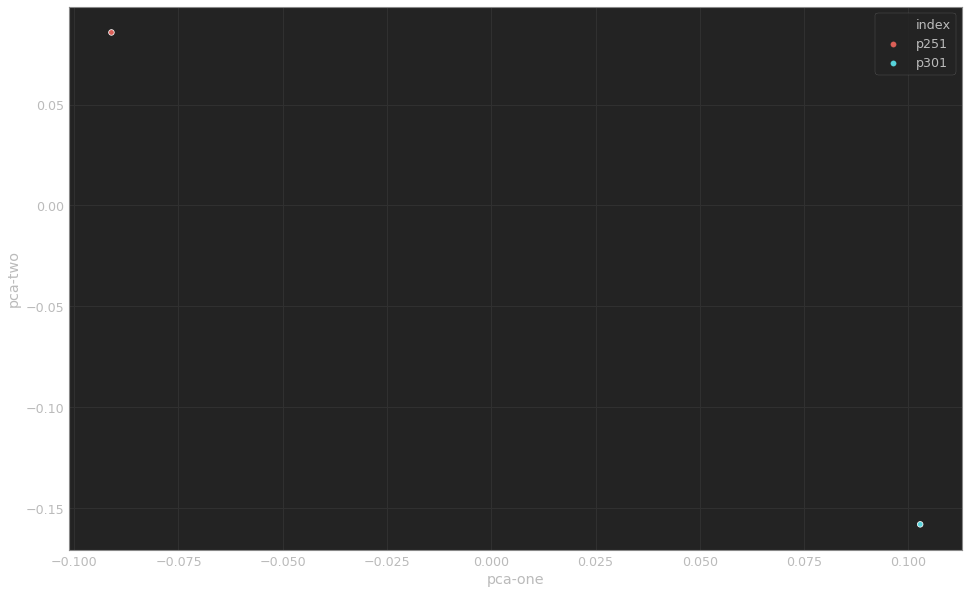

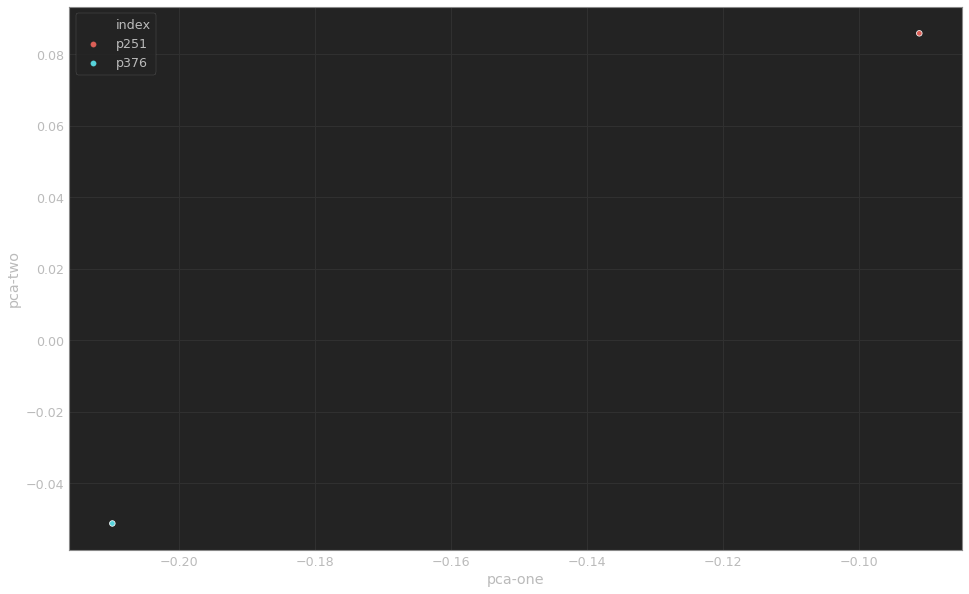

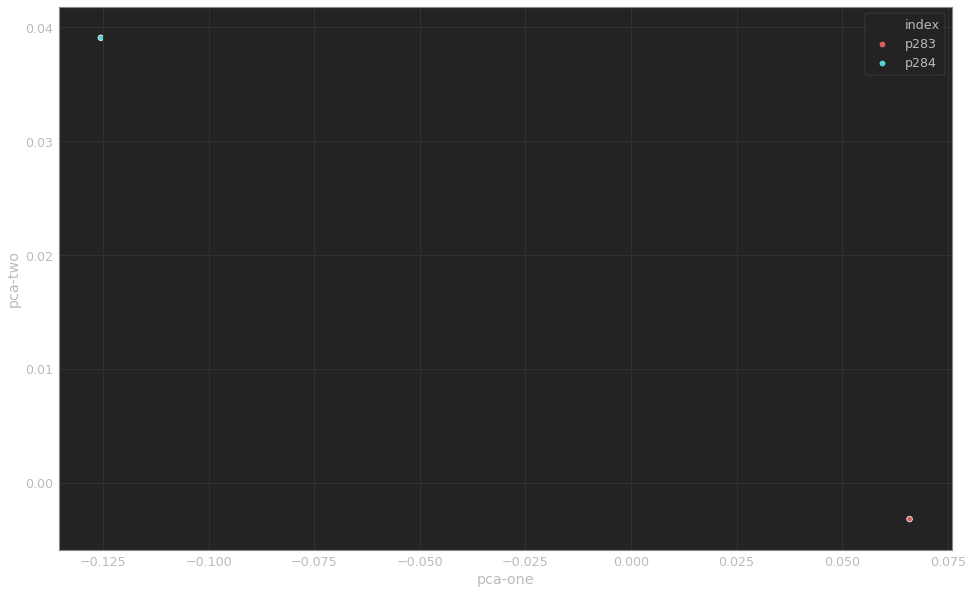

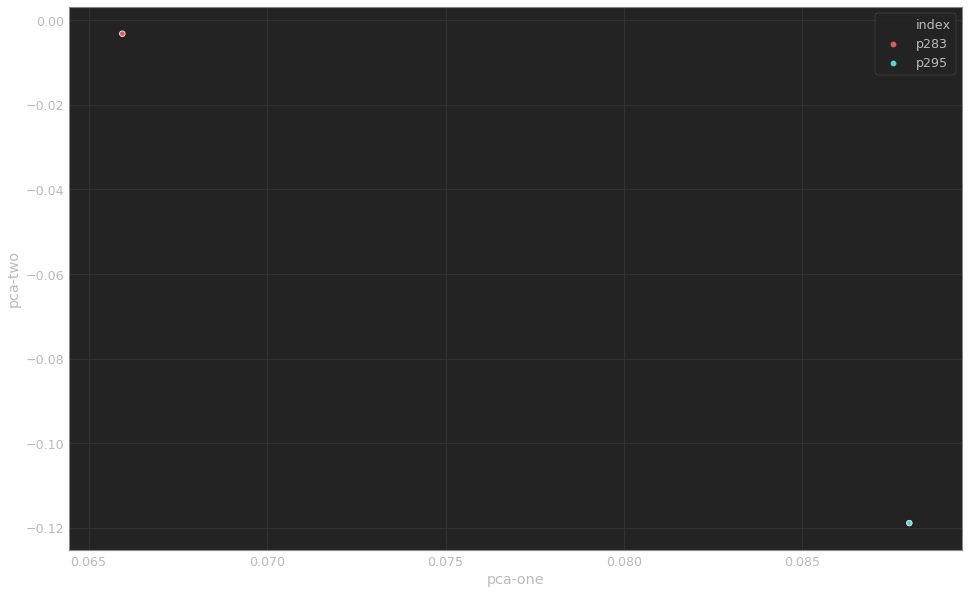

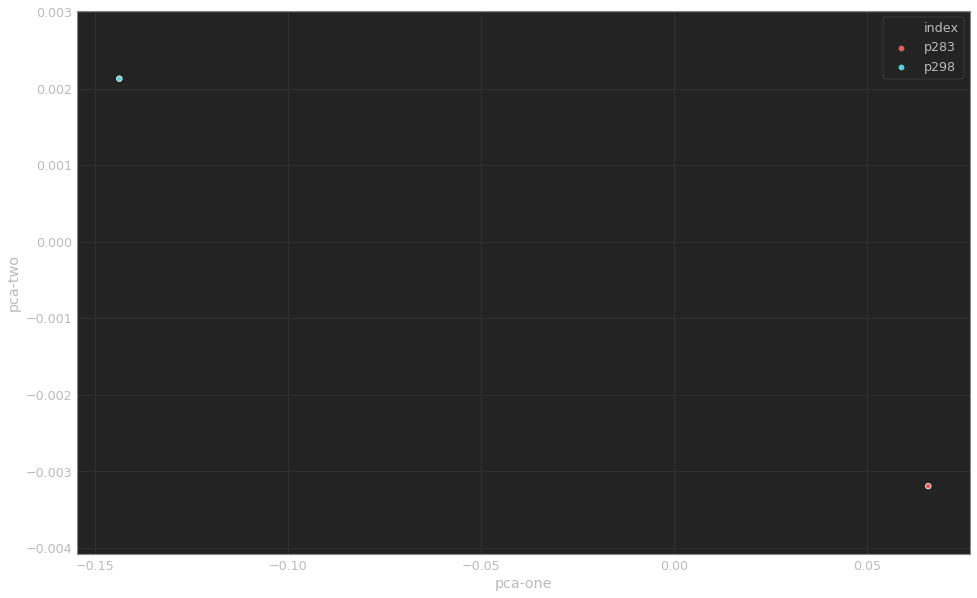

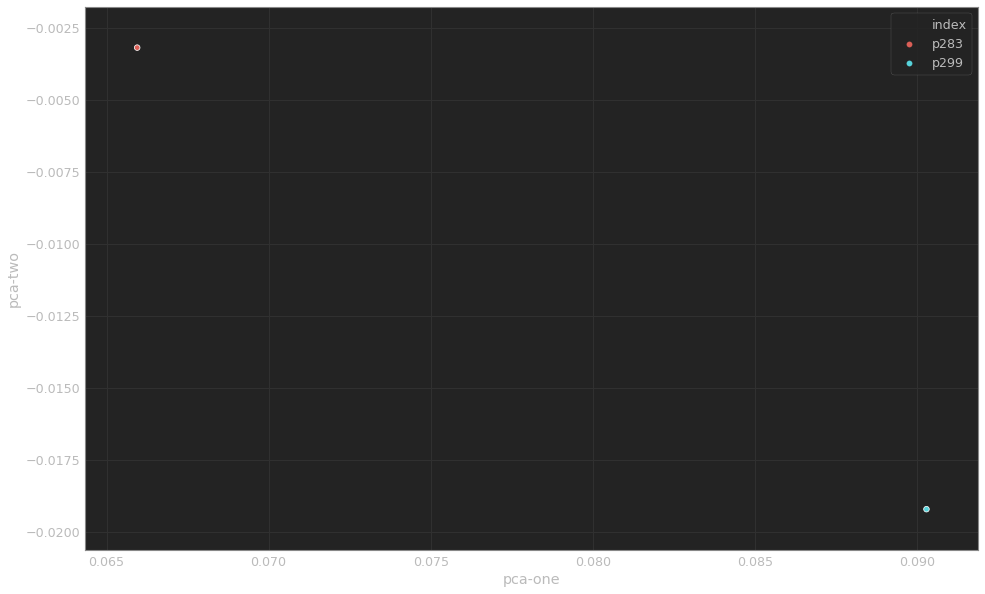

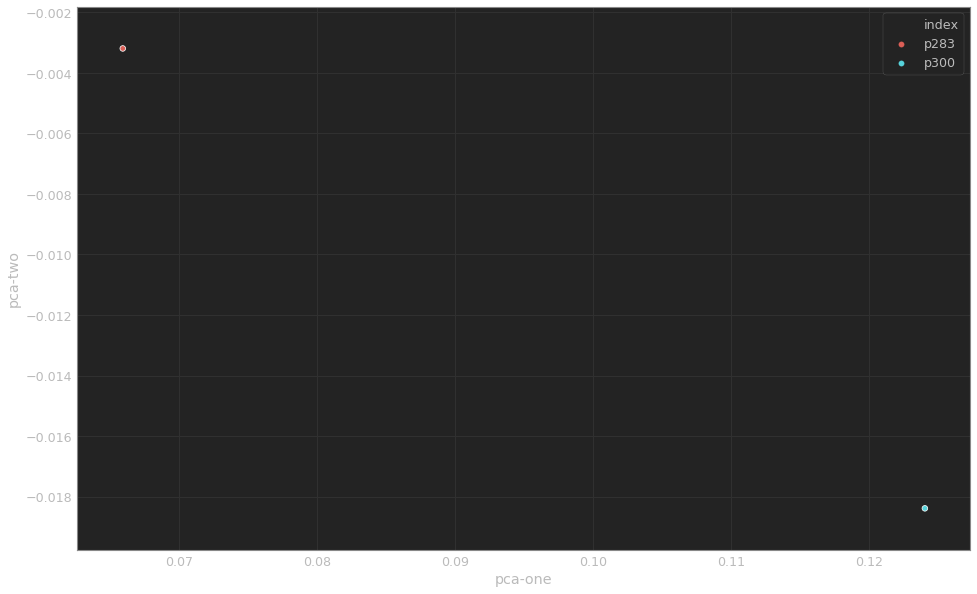

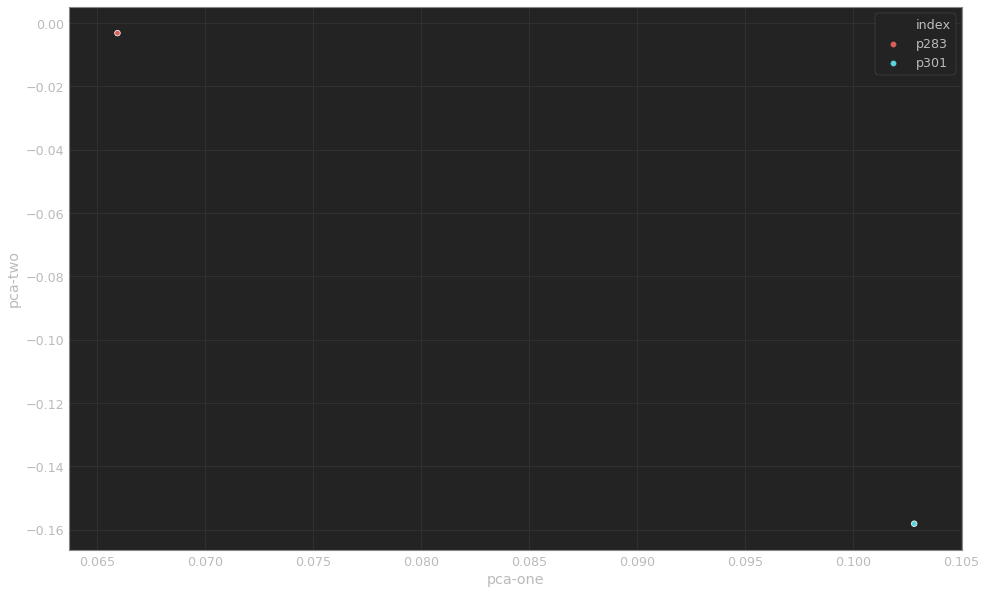

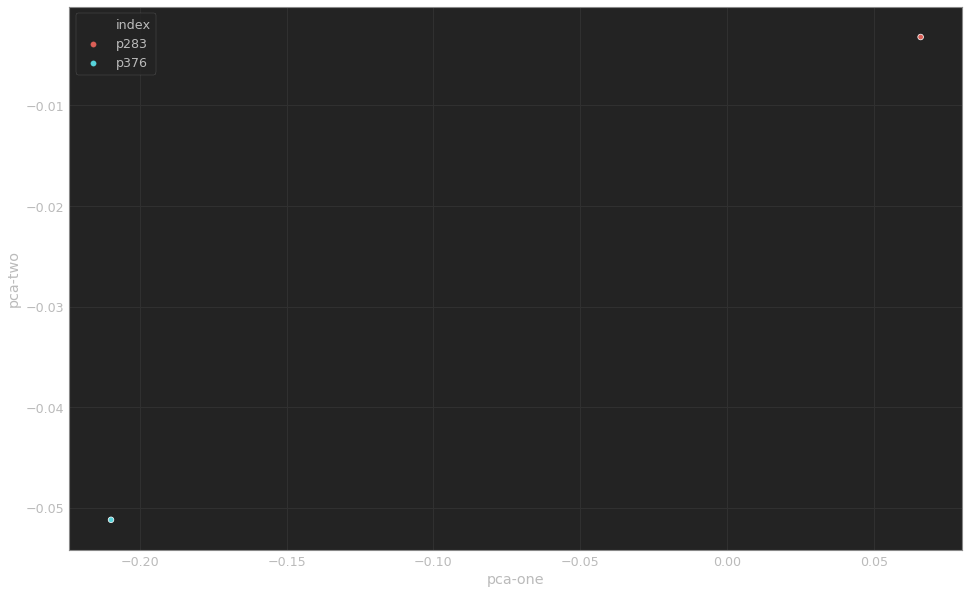

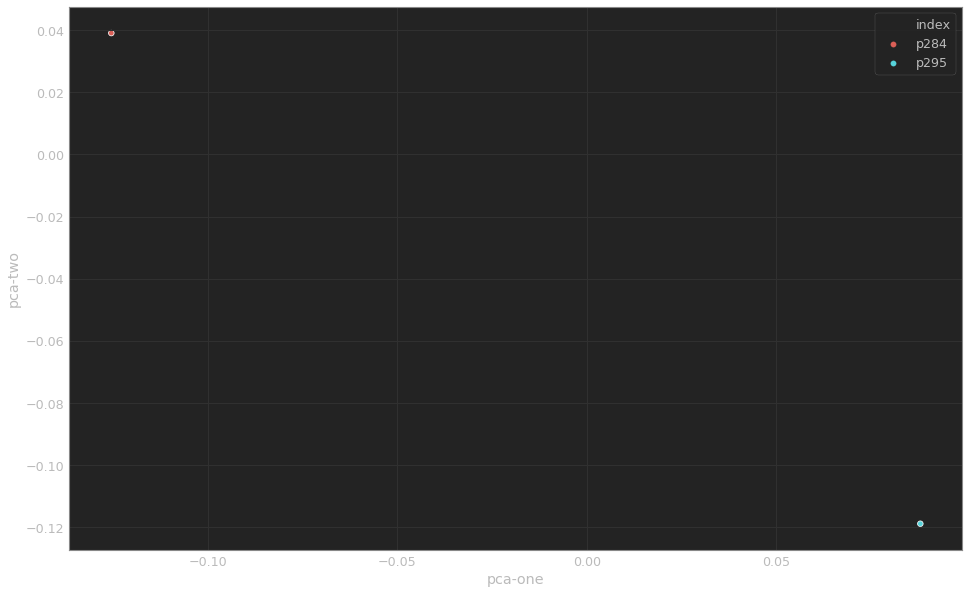

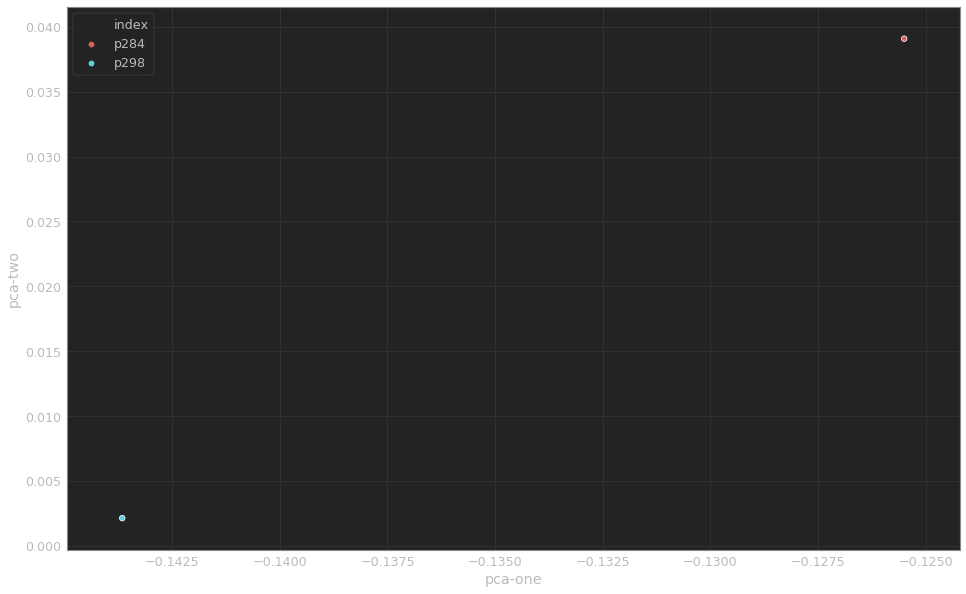

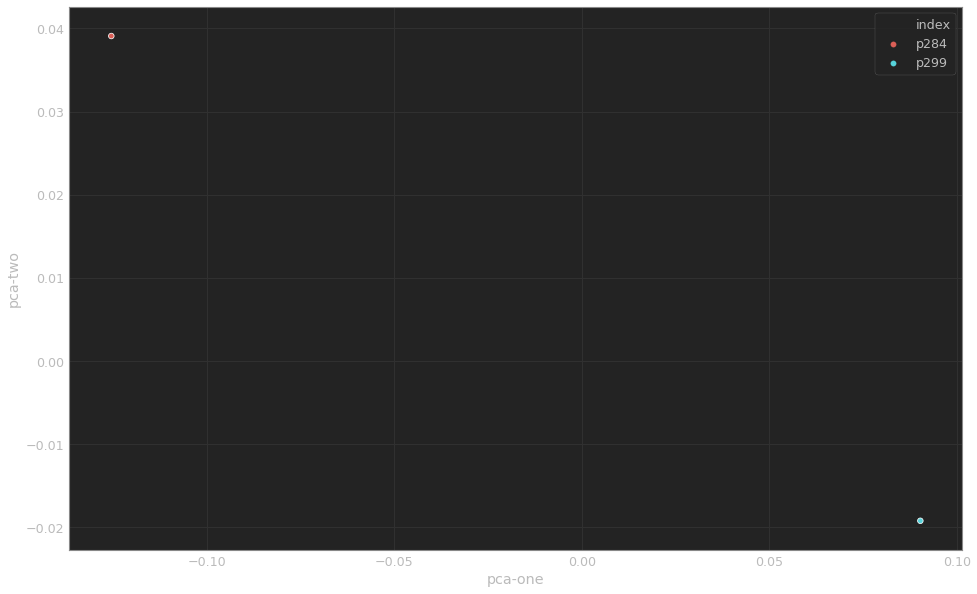

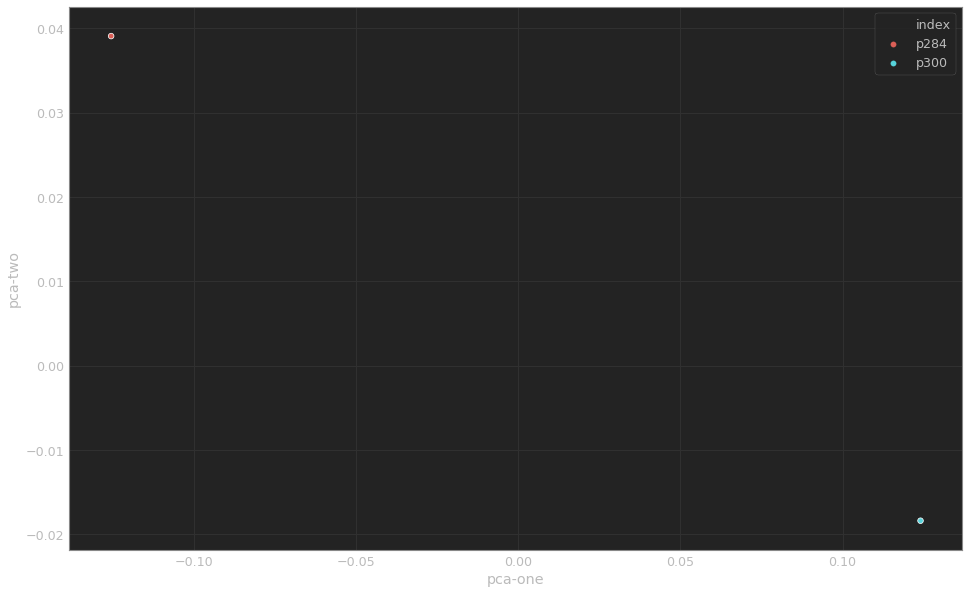

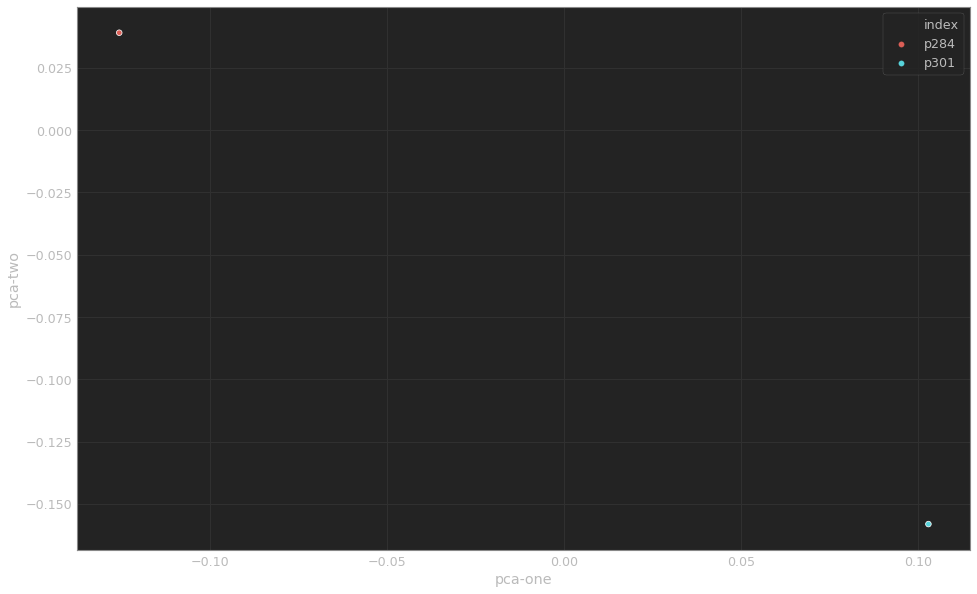

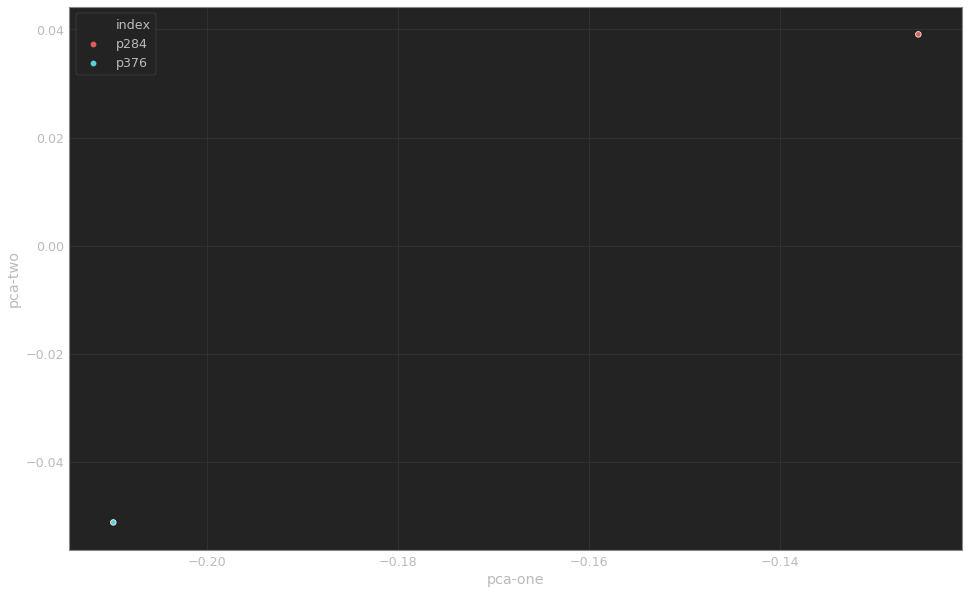

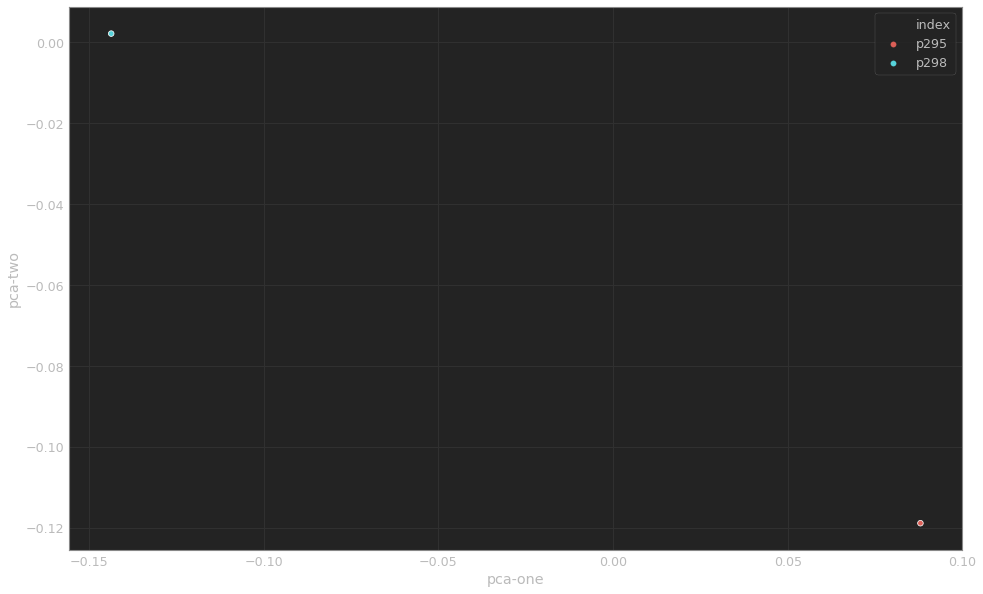

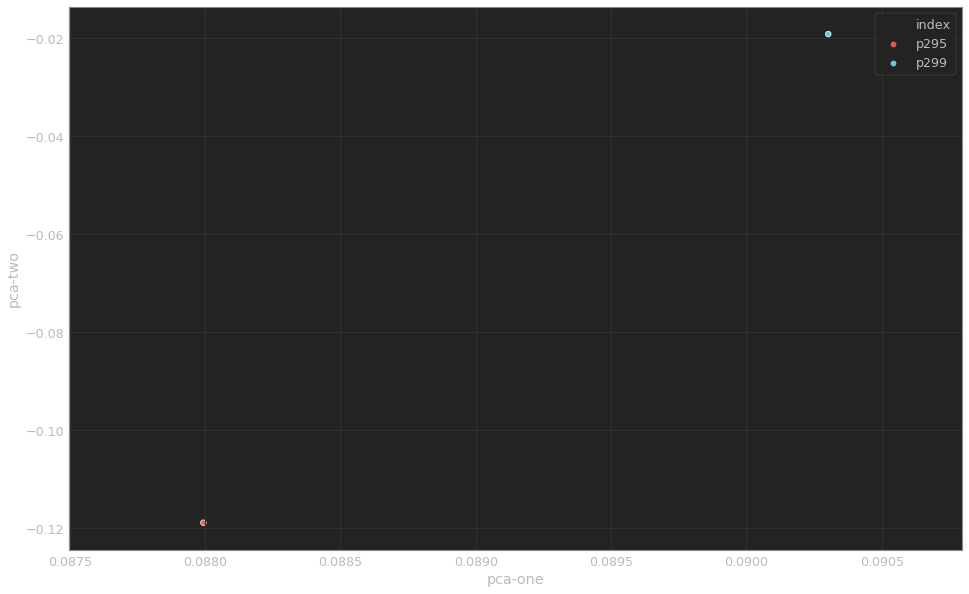

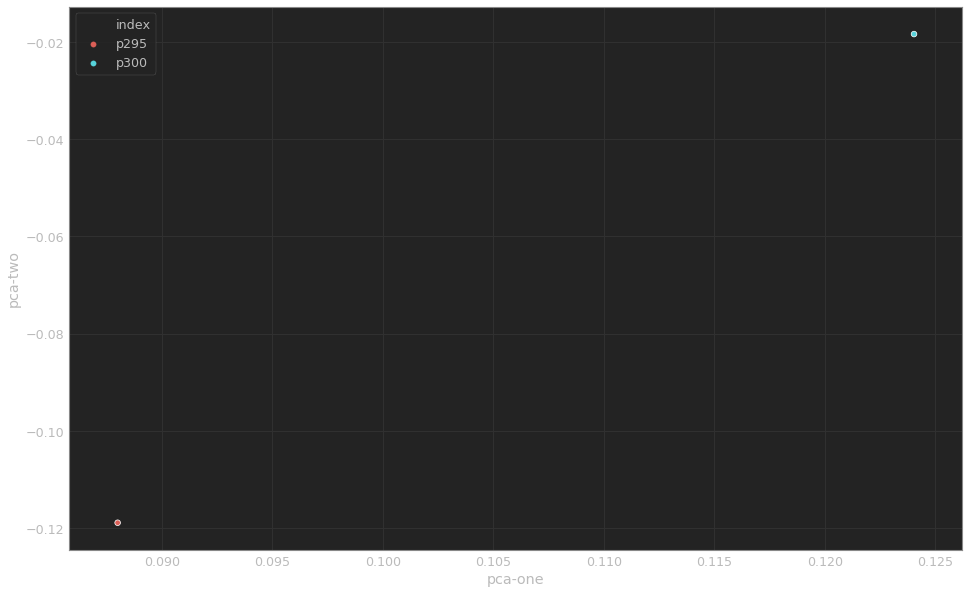

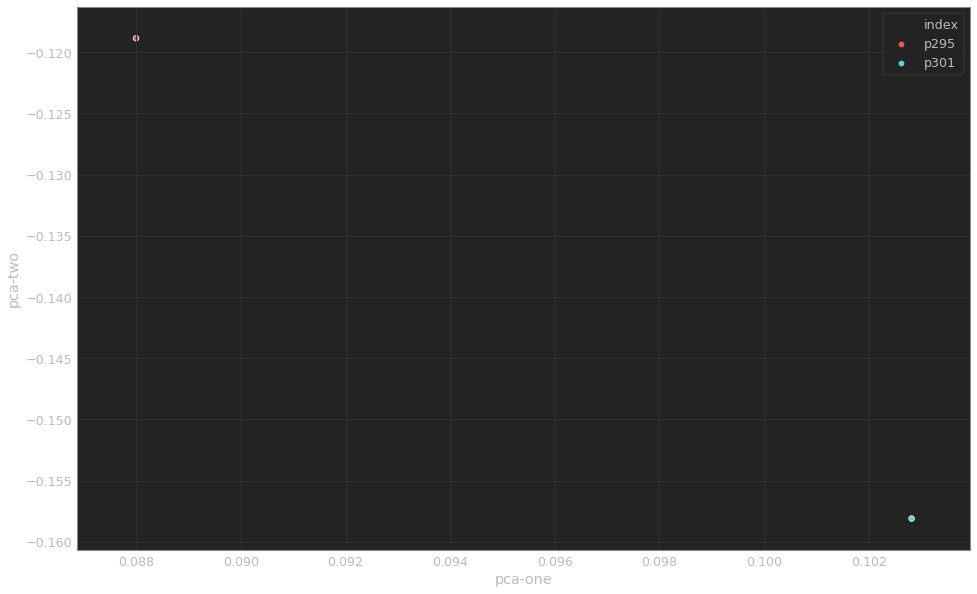

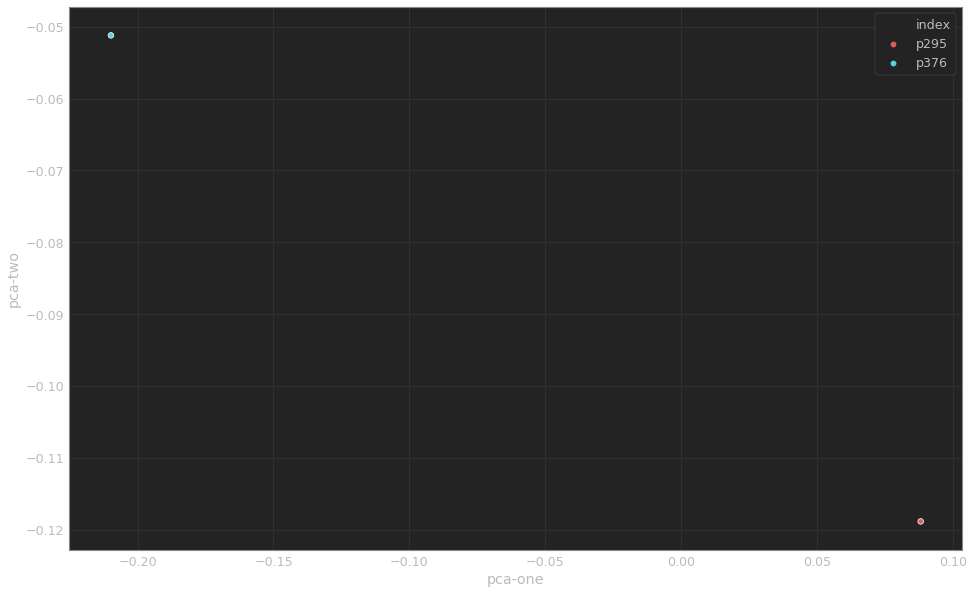

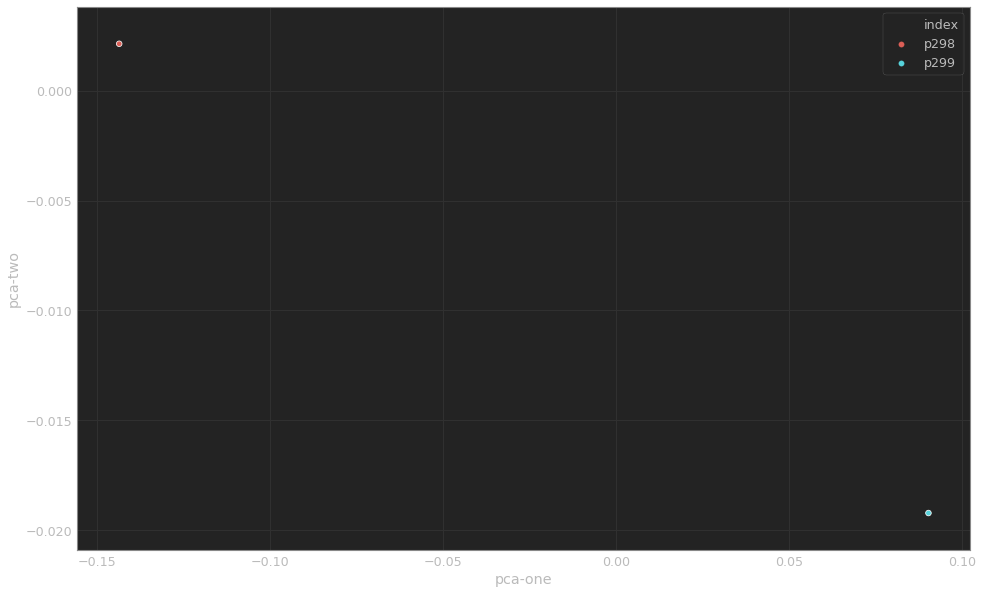

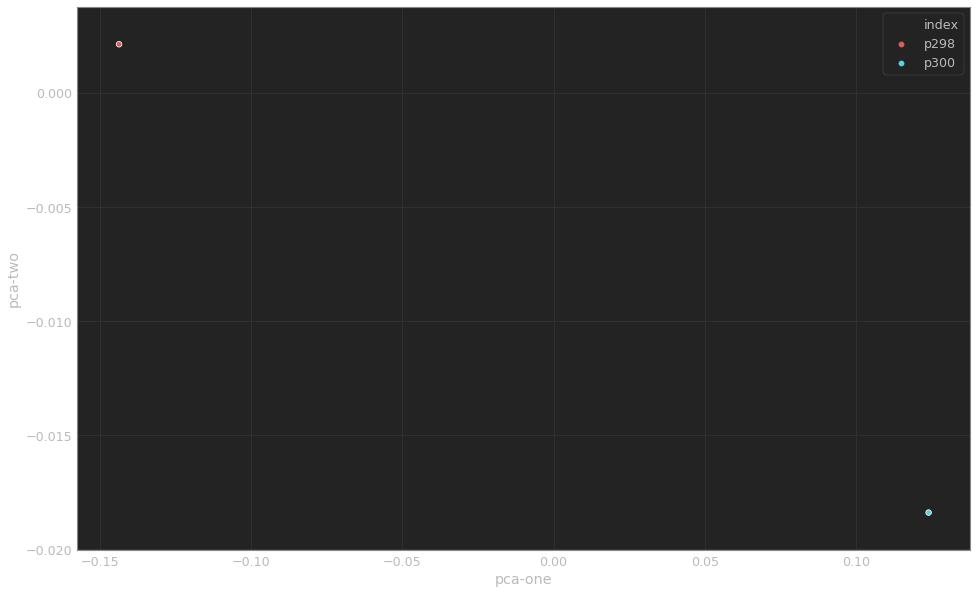

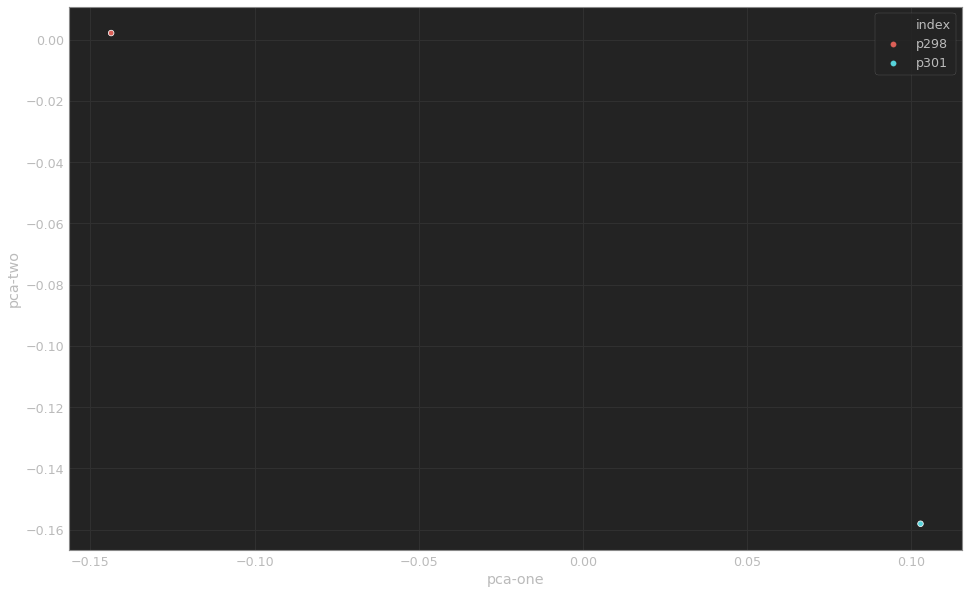

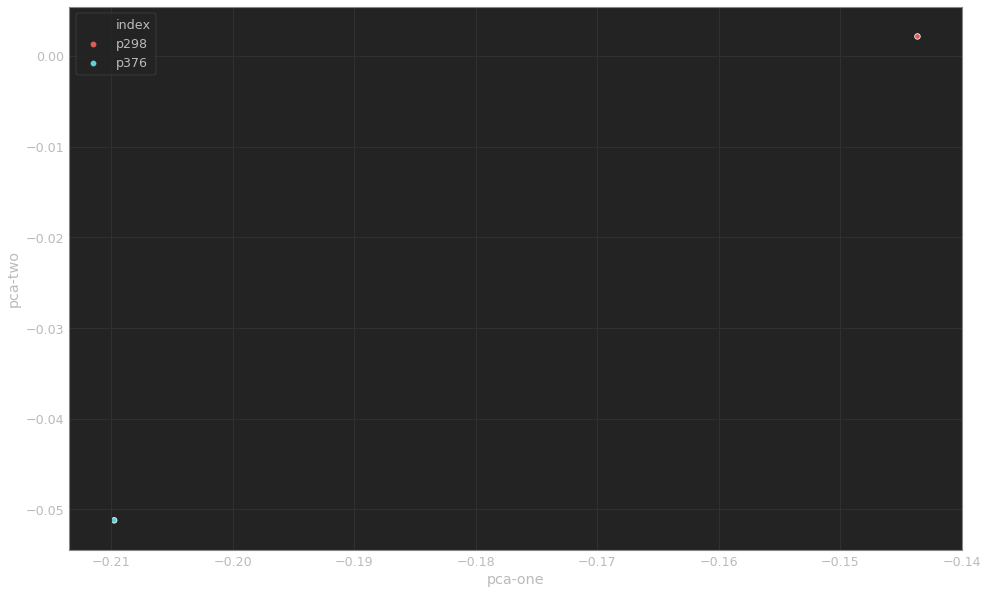

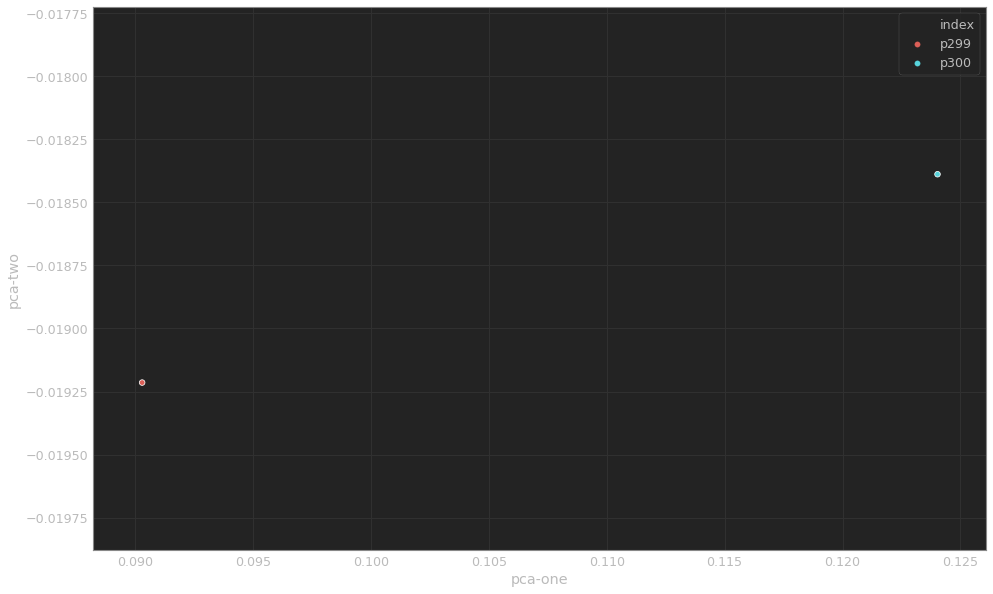

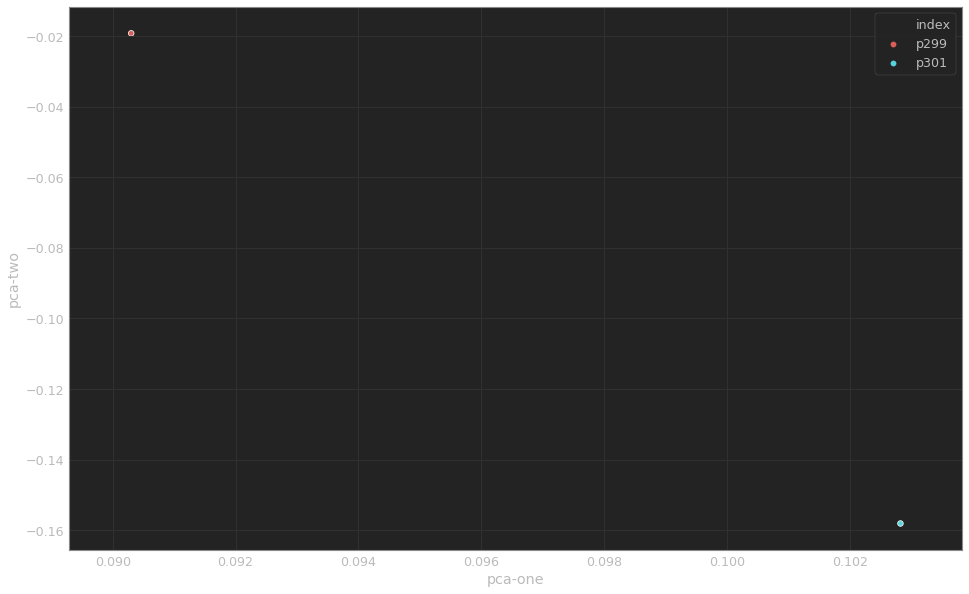

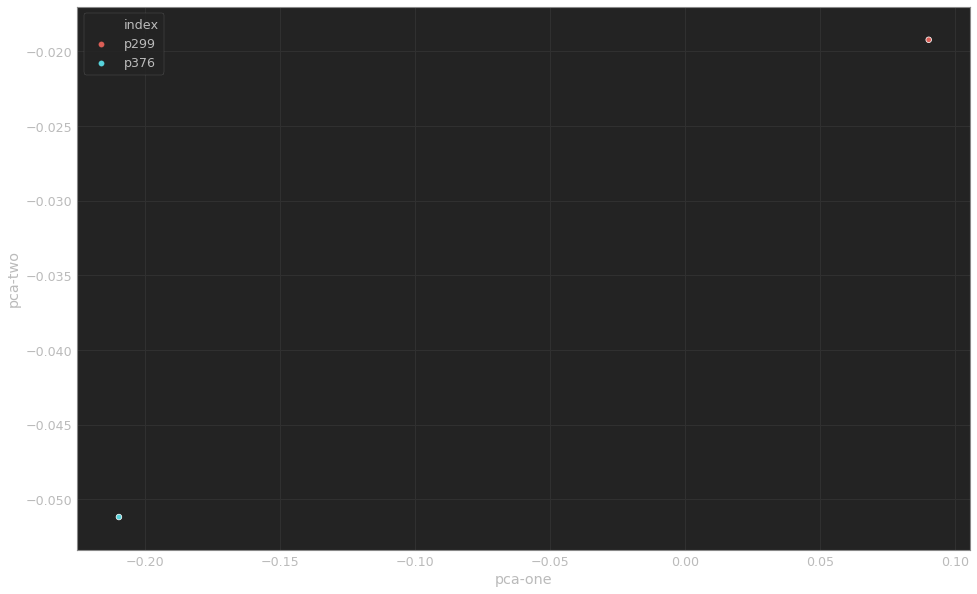

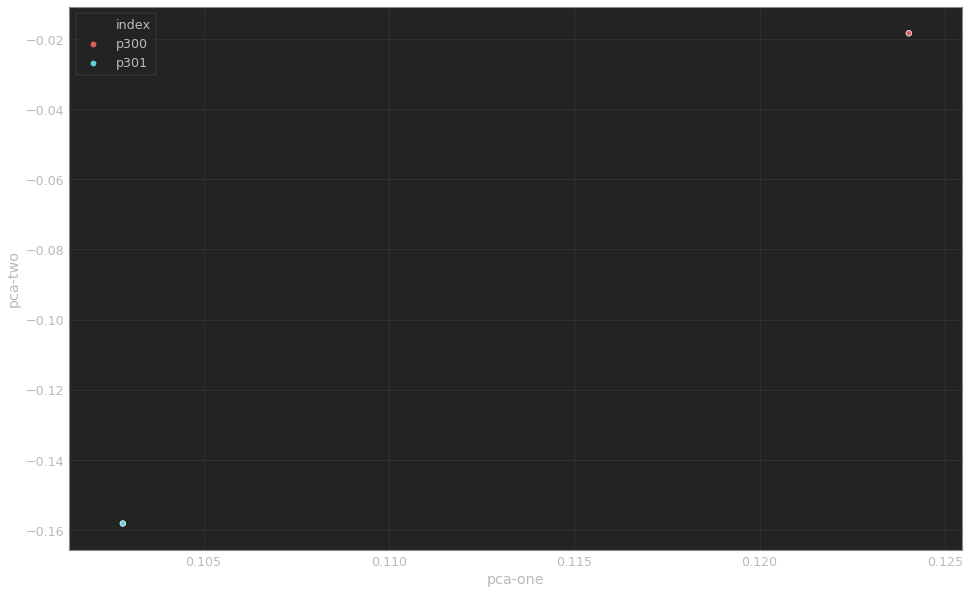

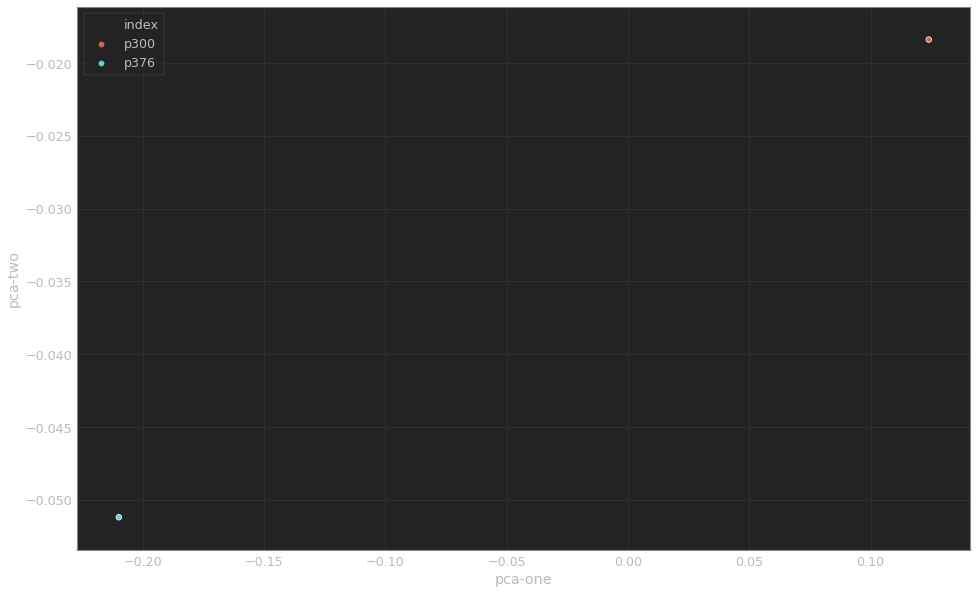

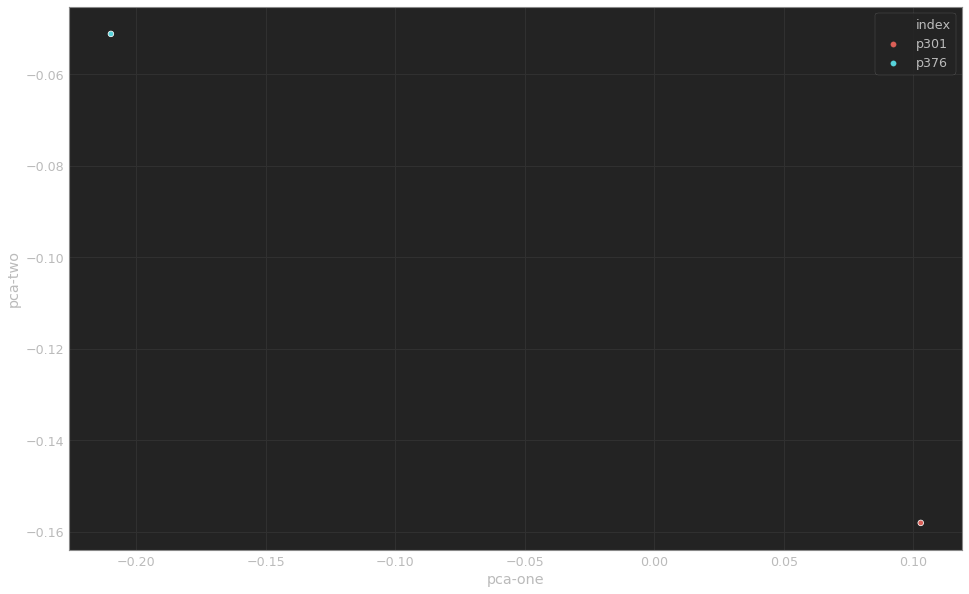

In [55]:
speeks = df['index'].values

whatevs = []
for i in range(len(speeks)):
    for j in range(i+1, len(speeks)):
        rndperm2 = [i,j]
        print(speeks[i], speeks[j])
        plt.figure(figsize=(16,10))
        sns_plot2 = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="index",
        palette=sns.color_palette("hls", 2),
        data=df.loc[rndperm2,:],
        legend="full",
        alpha=1.0
        )
        dist = np.sqrt((df['pca-one'][i] - df['pca-one'][j])**2 + (df['pca-two'][i] - df['pca-two'][j])**2)
        whatevs.append(dist)
        #sns_plot2.figure.savefig('{}{} - {}.png'.format(i, j, dist))

In [56]:
whatevs

[0.1809749085113922,
 0.18821133918680866,
 0.2419831175227657,
 0.03157518977311217,
 0.1577548643743852,
 0.02711903684833403,
 0.1789482912373302,
 0.14367108704787782,
 0.19696714294012688,
 0.054738225205641554,
 0.0813718355623453,
 0.18540884127406662,
 0.2718202327661022,
 0.020173252396814886,
 0.38766891881278676,
 0.1872232573527911,
 0.061999087695522016,
 0.19768564730942234,
 0.003979962499032548,
 0.26557457963151876,
 0.0372624837547107,
 0.22499309634124393,
 0.2576499070539238,
 0.3013807193595056,
 0.11955416277083622,
 0.384884374259437,
 0.19741437717505242,
 0.051253979300655235,
 0.20688020678911434,
 0.01783043124850447,
 0.28106380170852546,
 0.05455195049341686,
 0.23493558171925483,
 0.26689571503368614,
 0.31776524315196075,
 0.1317920715300788,
 0.2638229878611509,
 0.33608847807296055,
 0.24945986837936637,
 0.3842761072202976,
 0.33511227277378514,
 0.4159758386295032,
 0.2471798767794786,
 0.2290534756999183,
 0.365586070635445,
 0.49914050394102627,
 0.

In [58]:
np.sum(whatevs)/len(whatevs)

0.19214651200668417

Size of the dataframe: (218, 258)
Explained variation per principal component: [0.555938   0.23208155 0.08744881]
(218, 256)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 218 samples in 0.000s...
[t-SNE] Computed neighbors for 218 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 218 / 218
[t-SNE] Mean sigma: 0.064460
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.223721
[t-SNE] KL divergence after 1950 iterations: 0.068525
t-SNE done! Time elapsed: 1.7536802291870117 seconds


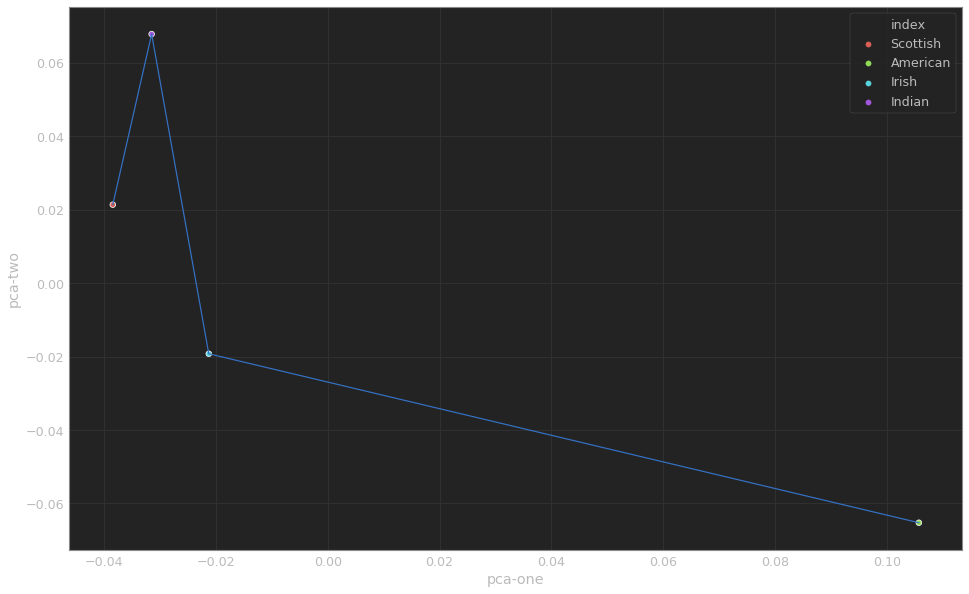

<Figure size 1152x720 with 0 Axes>

In [27]:
df = tsne_visualize(X, y)

In [30]:
df

,index,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pca-one,pca-two,pca-three
0,American,0.022479,0.0,0.0,0.0,0.086027,0.107050,0.0,0.089244,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105717,-0.065234,-0.006150
1,Indian,0.057171,0.0,0.0,0.0,0.072646,0.112138,0.0,0.069867,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.031486,0.067773,0.050169
2,Irish,0.049634,0.0,0.0,0.0,0.090769,0.122132,0.0,0.071302,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021269,-0.019245,-0.005159
3,Scottish,0.063542,0.0,0.0,0.0,0.093202,0.132469,0.0,0.064787,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.038435,0.021335,-0.030215


In [28]:
lens = []
for i in range(len(df)-1):
    dist = (df['pca-one'][i] - df['pca-one'][i+1])**2 + (df['pca-two'][i] - df['pca-two'][i+1])**2
    lens.append(np.sqrt(dist))
print(lens)

[0.19109067823452489, 0.08761537961312824, 0.04406072120927776]


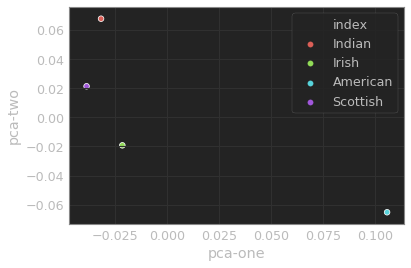

In [36]:
rndperm2 = np.random.permutation(df.shape[0])
sns_plot2 = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="index",
        palette=sns.color_palette("hls", 4),
        data=df.loc[rndperm2,:],
        legend="full",
        alpha=1.0
    )
sns_plot2.figure.savefig('fig24.png')
    #plt.savefig("out.png")

In [49]:
df

,index,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pca-one,pca-two,pca-three
0,p234,0.051439,0.0,0.0,0.0,0.087898,0.130141,0.0,0.080891,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052463,0.020339,-0.059582
1,p237,0.074663,0.0,0.0,0.0,0.102392,0.140806,0.0,0.043908,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.127844,0.035869,-0.010670
2,p245,0.084674,0.0,0.0,0.0,0.094183,0.137677,0.0,0.046450,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.132432,0.055513,0.001990
3,p248,0.003217,0.0,0.0,0.0,0.055924,0.085809,0.0,0.133337,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230162,0.184592,0.099620
4,p249,0.039744,0.0,0.0,0.0,0.092887,0.122503,0.0,0.086670,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053360,-0.011223,-0.049558
5,p251,0.083495,0.0,0.0,0.0,0.093134,0.140600,0.0,0.063795,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.091075,0.085788,-0.023130
6,p283,0.030340,0.0,0.0,0.0,0.096195,0.124013,0.0,0.092868,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065944,-0.003192,-0.064109
7,p284,0.086669,0.0,0.0,0.0,0.089868,0.136164,0.0,0.048820,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.125500,0.039085,-0.002992
8,p295,0.007673,0.0,0.0,0.0,0.088700,0.099463,0.0,0.095567,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087994,-0.118869,0.035810
9,p298,0.086471,0.0,0.0,0.0,0.083537,0.130382,0.0,0.041655,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.143660,0.002129,0.015058


array(['p234', 'p237', 'p245', 'p248', 'p249', 'p251', 'p283', 'p284',
       'p295', 'p298', 'p299', 'p300', 'p301', 'p376'], dtype=object)

American Indian
American Irish
American Scottish
Indian Irish
Indian Scottish
Irish Scottish


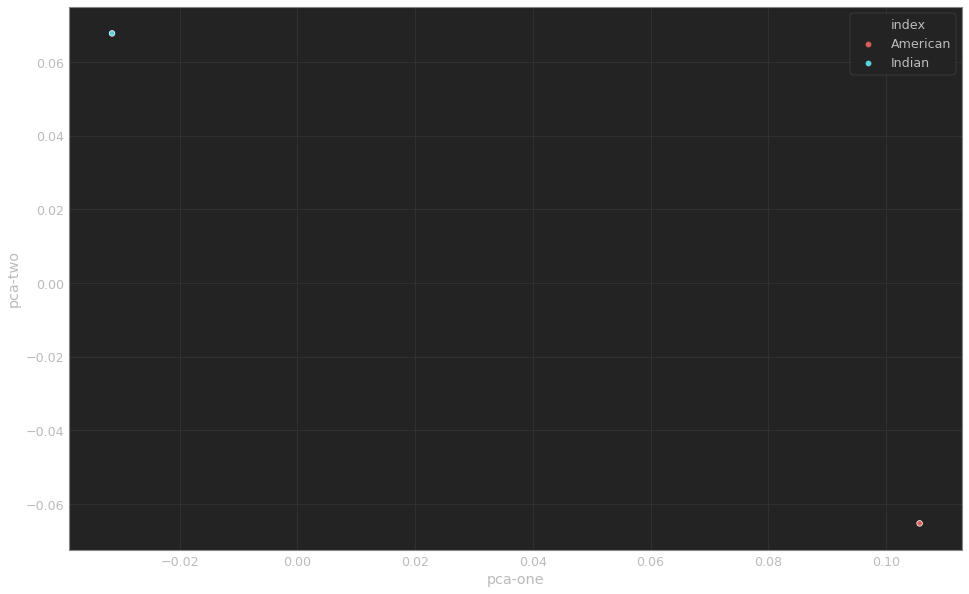

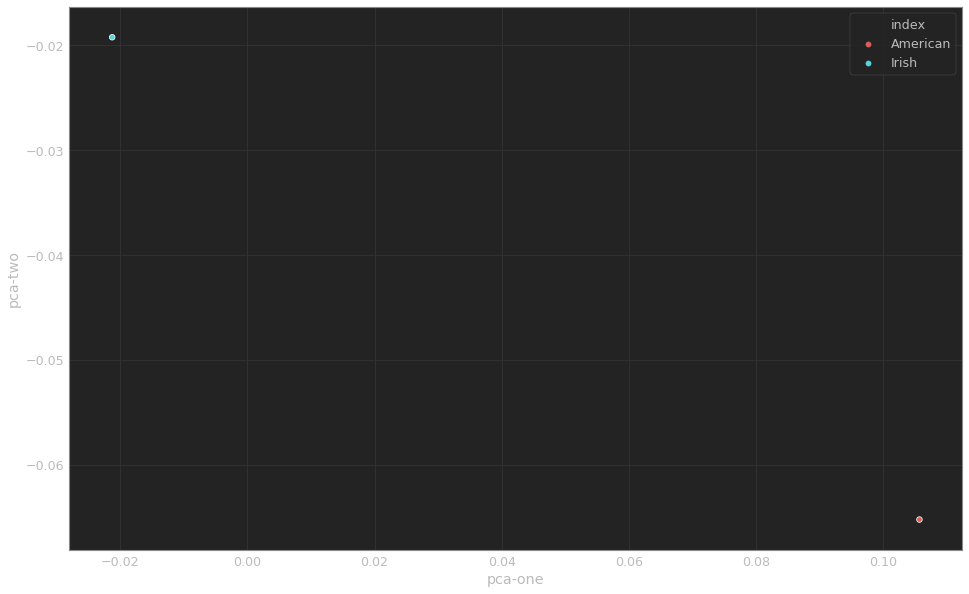

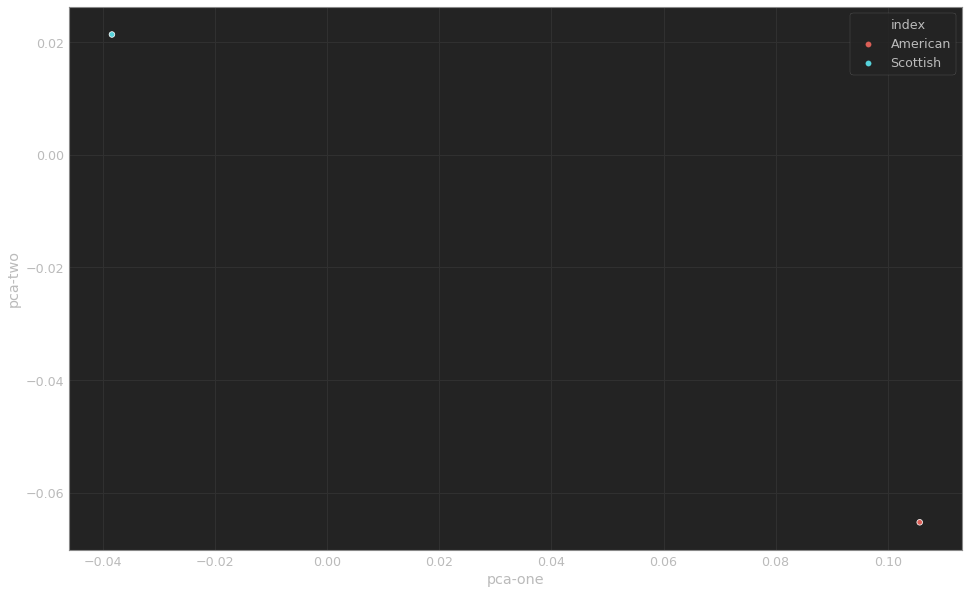

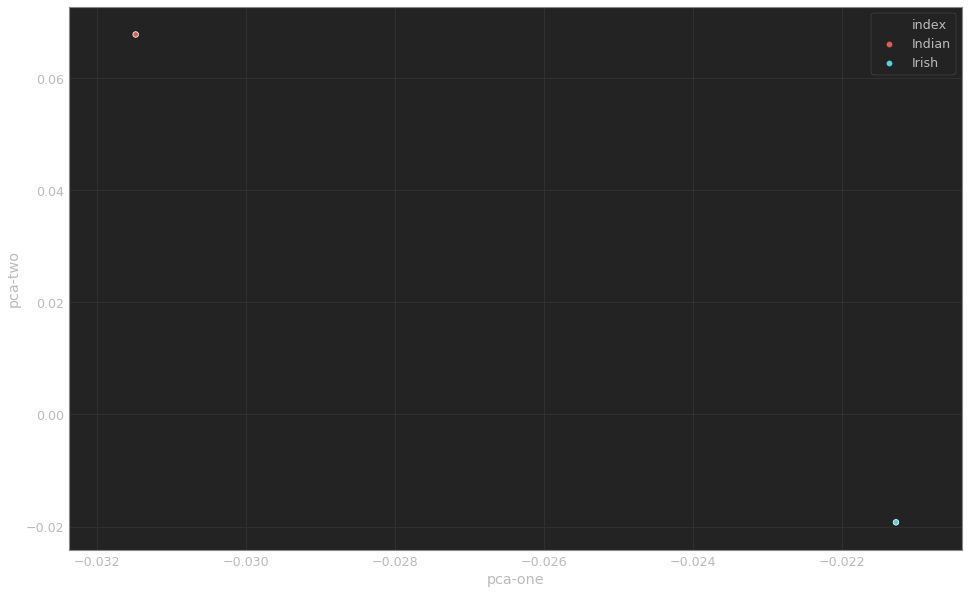

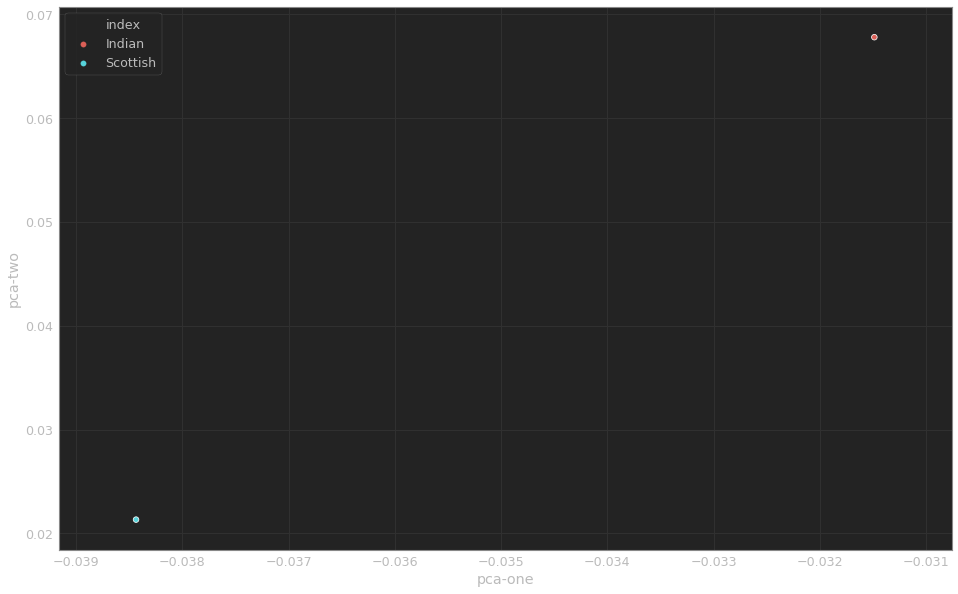

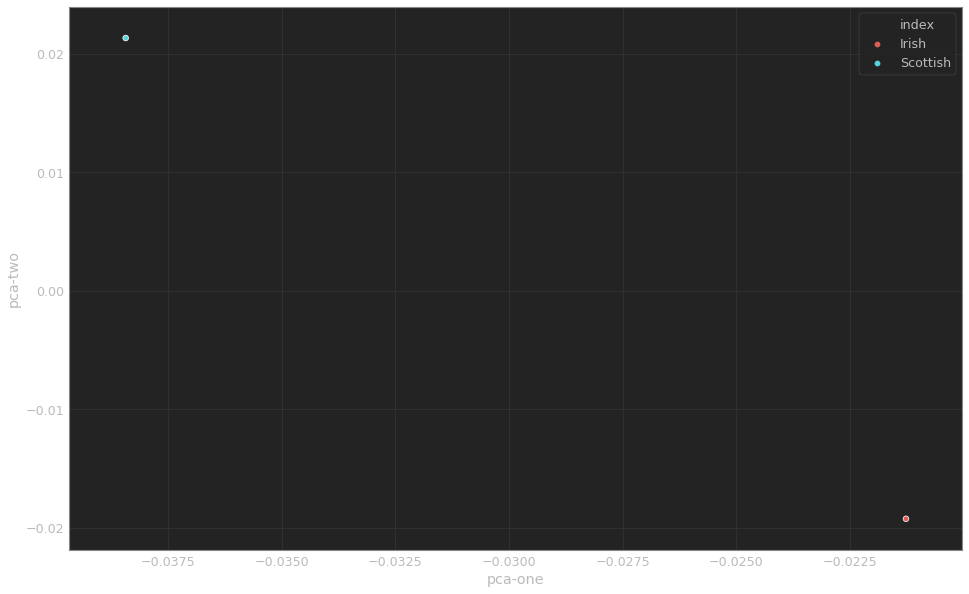

In [37]:
accs = ['American', 'Indian', 'Irish', 'Scottish']

whatevs = []
for i in range(len(accs)):
    for j in range(i+1, len(accs)):
        rndperm2 = [i,j]
        print(accs[i], accs[j])
        plt.figure(figsize=(16,10))
        sns_plot2 = sns.scatterplot(
        x="pca-one", y="pca-two",
        hue="index",
        palette=sns.color_palette("hls", 2),
        data=df.loc[rndperm2,:],
        legend="full",
        alpha=1.0
        )
        dist = np.sqrt((df['pca-one'][i] - df['pca-one'][j])**2 + (df['pca-two'][i] - df['pca-two'][j])**2)
        whatevs.append(dist)
        #sns_plot2.figure.savefig('{}{} - {}.png'.format(i, j, dist))

In [36]:
np.sum(whatevs)/len(whatevs)

0.0158088146821081

In [38]:
np.sum(whatevs)/len(whatevs)

0.11215478541621521

In [39]:
whatevs

[0.19109067823452489,
 0.13505778425140008,
 0.1681488414233822,
 0.08761537961312824,
 0.04695530776557805,
 0.04406072120927776]

In [40]:
[i**2 for i in whatevs]

[0.03651564730813072,
 0.018240605086897732,
 0.028274032872025737,
 0.007676454744752567,
 0.002204800927360154,
 0.0019413471534816989]

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551815
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.18427348136901855 seconds


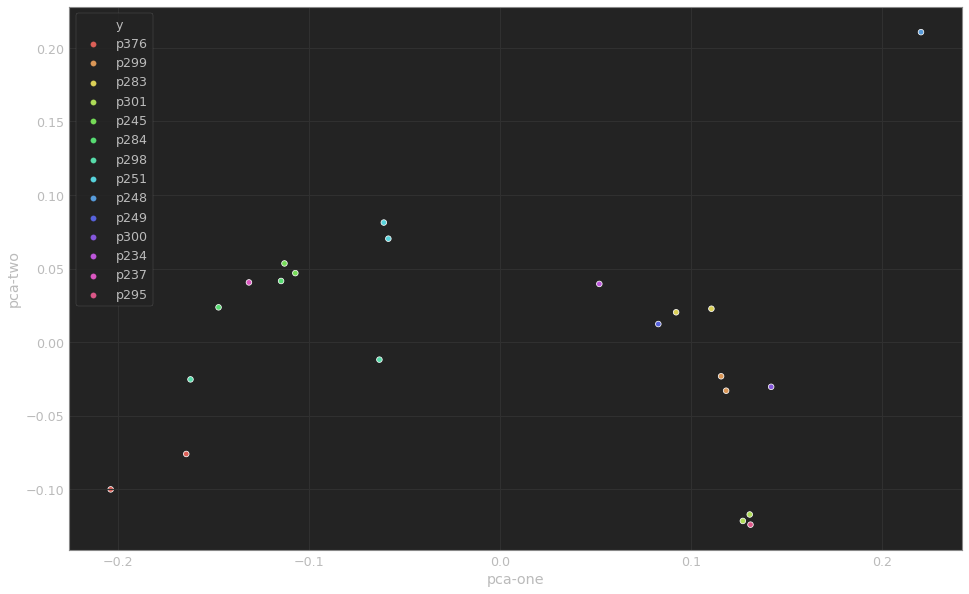

<Figure size 1152x720 with 0 Axes>

In [42]:
tsne_visualize(X, y)

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551819
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.16087889671325684 seconds


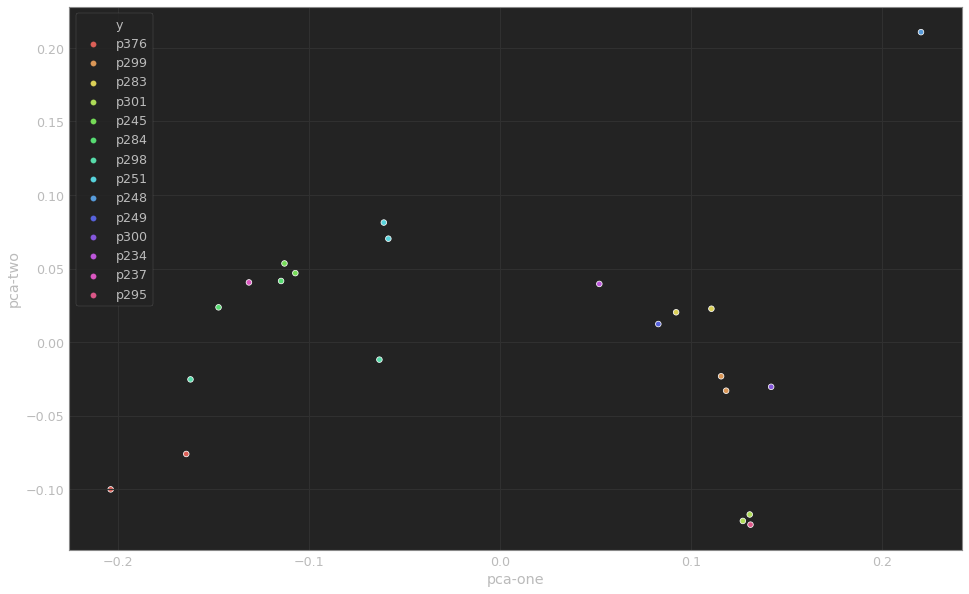

<Figure size 1152x720 with 0 Axes>

In [43]:
tsne_visualize(X, y)

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551819
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.14165544509887695 seconds


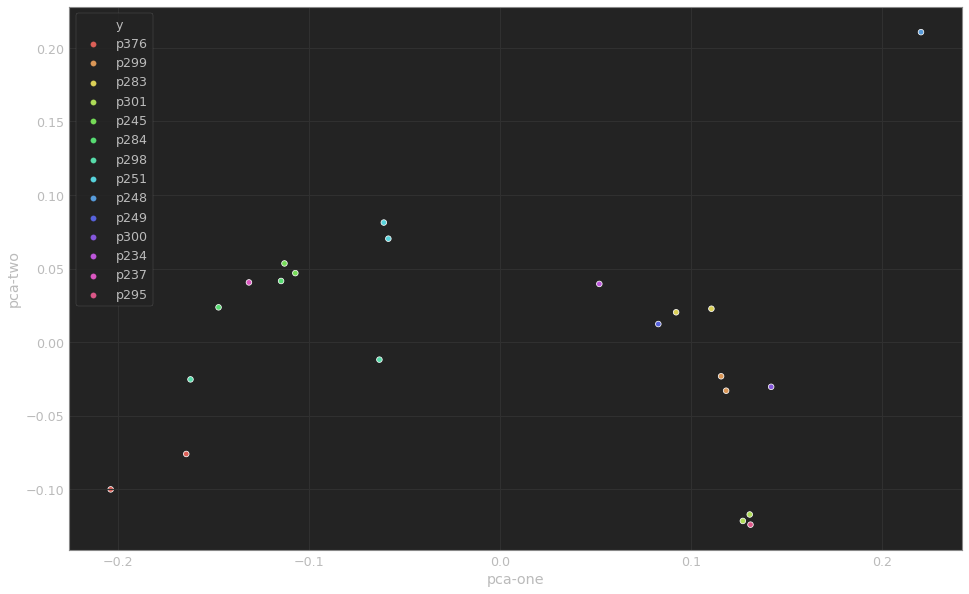

<Figure size 1152x720 with 0 Axes>

In [44]:
tsne_visualize(X, y)

Size of the dataframe: (22, 258)
Explained variation per principal component: [0.6140105  0.22361195 0.07259732]
(22, 256)
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.551819
[t-SNE] KL divergence after 900 iterations: 0.425877
t-SNE done! Time elapsed: 0.15058016777038574 seconds


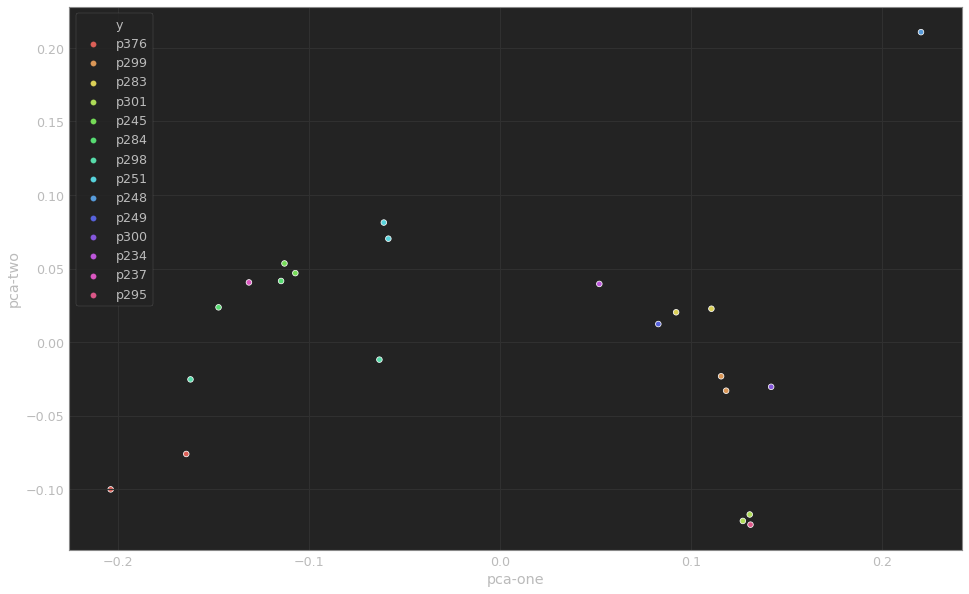

<Figure size 1152x720 with 0 Axes>

In [49]:
tsne_visualize(X, y)

In [59]:
pca = PCA(n_components=3)

array([[ 2.02909393e+01, -2.64707127e+01, -1.99331703e+01],
       [-4.98939544e-01, -1.47841825e+01,  1.67141380e+01],
       [ 5.49169769e+01,  1.36487017e+01,  1.15841913e+01],
       [ 6.68065414e+01,  1.83504999e+00,  2.51923442e+00],
       [ 6.16068382e+01,  1.56751931e+00, -1.18767560e+00],
       [ 1.58490543e+01, -1.73385601e+01,  1.57831848e+00],
       [ 1.59853637e+00, -6.33093834e+00,  2.97420998e+01],
       [ 2.30127163e+01, -1.98130322e+01,  2.56670551e+01],
       [ 3.43278275e+01, -1.07816935e+01,  5.86195135e+00],
       [-7.10167456e+00, -2.30731049e+01, -2.44185886e+01],
       [-2.86180520e+00,  2.15116615e+01,  8.75409222e+00],
       [-2.77860088e+01, -1.91719761e+01,  4.96013689e+00],
       [-1.40560369e+01,  2.83372669e+01, -7.53189707e+00],
       [-3.00184536e+01,  1.04009686e+01, -2.08259945e+01],
       [-2.50758915e+01, -2.28281555e+01, -2.81658821e+01],
       [-1.97043324e+01, -1.60979786e+01, -1.89660492e+01],
       [-2.59778862e+01, -2.39029713e+01

In [64]:
import torchviz

In [68]:
pre_positive_speaker_embs, pre_positive_accent_embs = get_both_embs(file_name)
pre_positive_speaker_embs, pre_positive_accent_embs = Variable(torch.from_numpy(pre_positive_speaker_embs)).to('cpu'), Variable(torch.from_numpy(pre_positive_accent_embs)).to('cpu')

RuntimeError: size mismatch, m1: [1 x 100], m2: [256 x 100] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

In [69]:
pre_positive_accent_embs.shape

torch.Size([1, 100])

In [70]:
pre_positive_speaker_embs.shape

torch.Size([1, 256])

In [10]:
from pytorch2keras.converter import pytorch_to_keras

DEBUG:graphviz.backend:run ['dot', '-Tsvg']


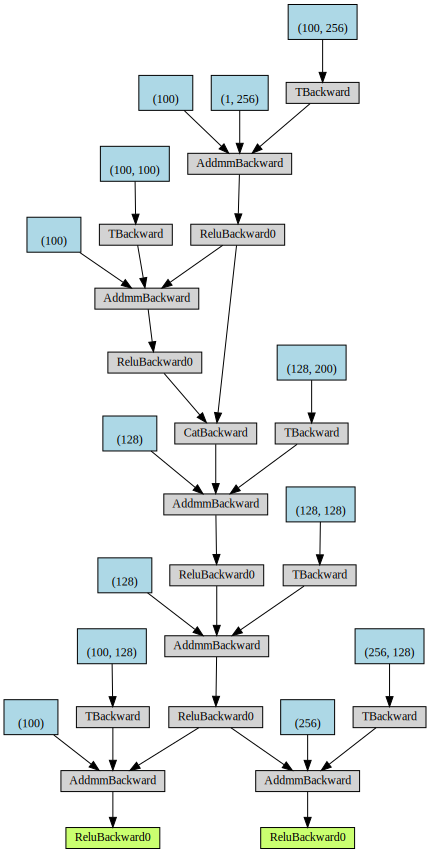

In [33]:
x1 = torch.zeros(1,100, dtype=torch.float, requires_grad=True)
x2 = torch.zeros(1,256, dtype=torch.float, requires_grad=True)
ae = AutoEncoder()
out = ae.forward(x2,x1)
torchviz.make_dot(out)

In [90]:
pytorch_total_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)

In [91]:
pytorch_total_params

124220

In [32]:
import onnx
import torchviz

In [28]:
x1 = torch.randn(batch_size, 1, 100, requires_grad=True)
x1 = torch.randn(batch_size, 1, 256, requires_grad=True)


NameError: name 'batch_size' is not defined

In [34]:
torch.onnx.export(ae,
          (x1,x2),
          'test.onnx',
          export_params=True)

RuntimeError: size mismatch, m1: [1 x 100], m2: [256 x 100] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136

In [48]:
%matplotlib.use('Agg')

UsageError: Line magic function `%matplotlib.use('Agg')` not found.
